In [1]:
import numpy as np
from glob import glob
import nibabel as nib
from matplotlib import pyplot as plt
import keras

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
!ls /kaggle/input/tp-1-dlim

iSeg-2017-Testing  iSeg-2017-Training


In [3]:
data_path = "/kaggle/input/tp-1-dlim"

In [4]:
test_paths = sorted(glob(f"{data_path}/*Test*/*.img"))
labels_paths = sorted(glob(f"{data_path}/*Training*/*-label*.img"))
train_paths = sorted([i for i in glob(f"{data_path}/*Training*/*.img") if i not in labels_paths])

In [5]:
for i in train_paths:
    print(f'train {i}')
print("-"* 80)

for i in labels_paths:
    print(f'labels {i}')
print("-"* 80)
for i in test_paths:
    print(f'test {i}')

train /kaggle/input/tp-1-dlim/iSeg-2017-Training/subject-1-T1.img
train /kaggle/input/tp-1-dlim/iSeg-2017-Training/subject-1-T2.img
train /kaggle/input/tp-1-dlim/iSeg-2017-Training/subject-10-T1.img
train /kaggle/input/tp-1-dlim/iSeg-2017-Training/subject-10-T2.img
train /kaggle/input/tp-1-dlim/iSeg-2017-Training/subject-2-T1.img
train /kaggle/input/tp-1-dlim/iSeg-2017-Training/subject-2-T2.img
train /kaggle/input/tp-1-dlim/iSeg-2017-Training/subject-3-T1.img
train /kaggle/input/tp-1-dlim/iSeg-2017-Training/subject-3-T2.img
train /kaggle/input/tp-1-dlim/iSeg-2017-Training/subject-4-T1.img
train /kaggle/input/tp-1-dlim/iSeg-2017-Training/subject-4-T2.img
train /kaggle/input/tp-1-dlim/iSeg-2017-Training/subject-5-T1.img
train /kaggle/input/tp-1-dlim/iSeg-2017-Training/subject-5-T2.img
train /kaggle/input/tp-1-dlim/iSeg-2017-Training/subject-6-T1.img
train /kaggle/input/tp-1-dlim/iSeg-2017-Training/subject-6-T2.img
train /kaggle/input/tp-1-dlim/iSeg-2017-Training/subject-7-T1.img
train /k

In [6]:
len(test_paths), len(train_paths), len(labels_paths)

(26, 20, 10)

In [7]:
img = nib.load(train_paths[0]).get_fdata()
print(img.shape, img.dtype)

(144, 192, 256, 1) float64


In [8]:
labels = [nib.load(path).get_fdata().astype('uint8') for path in labels_paths]
labels = [np.concatenate((i == 0, i == 10, i == 150, i == 250), axis=3) for i in labels]
labels[0].shape

(144, 192, 256, 4)

In [9]:
training_data = [np.concatenate([nib.load(train_paths[i]).get_fdata(),nib.load(train_paths[i + 1]).get_fdata()], axis=3) for i in range(0, len(train_paths), 2)]
training_data[0].shape

(144, 192, 256, 2)

51.400000000000006


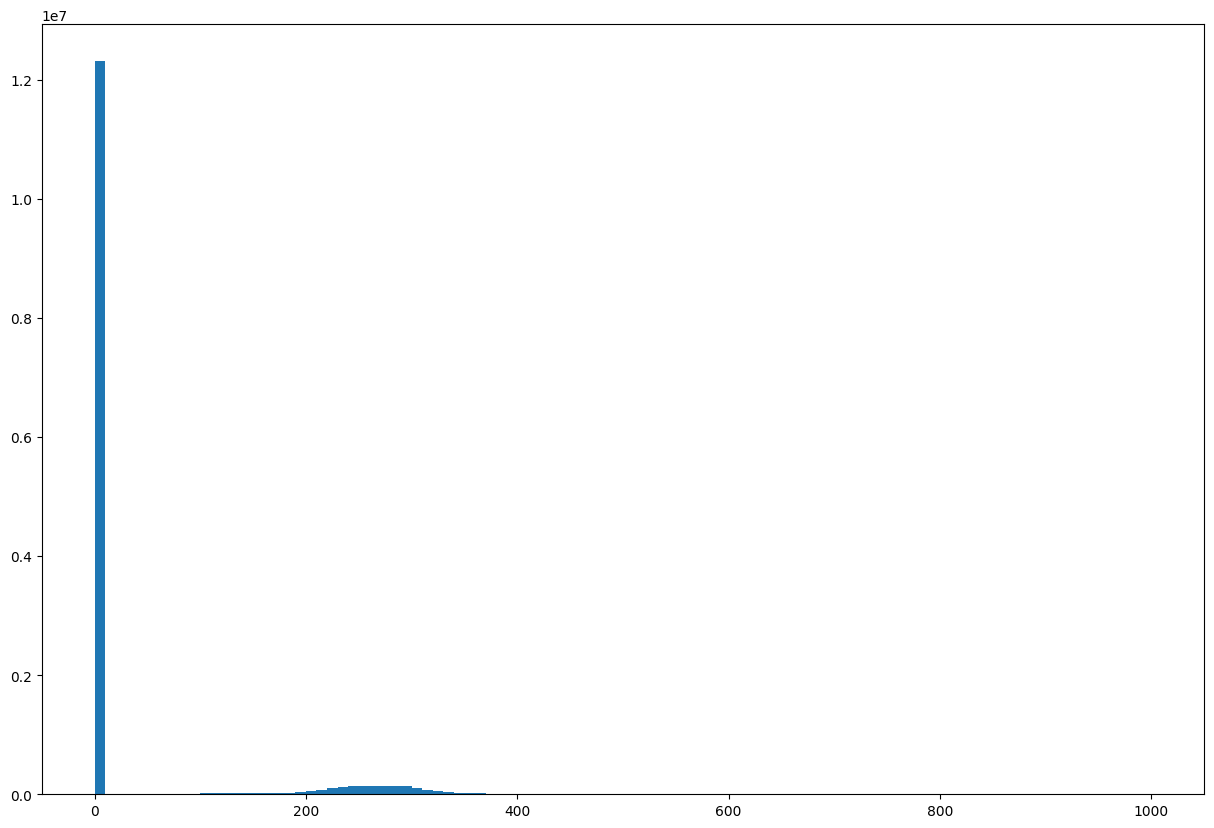

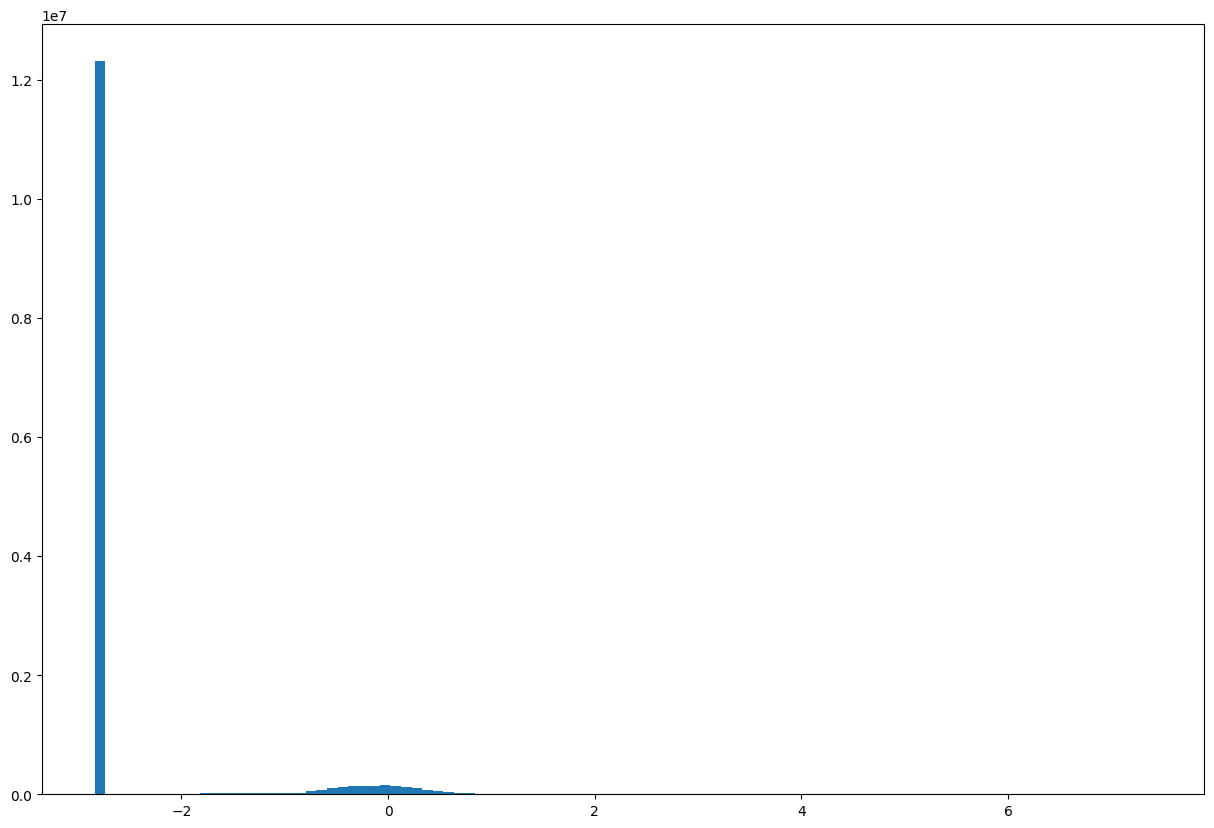

In [10]:
test = training_data[0].copy()

def normalize(array: np.array, show_plot=False) -> np.array:
    ret = array.copy()
    percent = 5
    uni = np.unique(ret)
    if show_plot:
        print(np.percentile(uni,percent))
        plt.figure(figsize=(15,10))
        plt.hist(ret.flatten(), bins=100)
        plt.show()
    ret2 = ret[ret > np.percentile(uni,percent)]
    ret = (ret - ret2.mean()) / ret2.std()
    if show_plot:
        plt.figure(figsize=(15,10))
        plt.hist(ret.flatten(), bins=100)
        plt.show()
    return ret

test = normalize(test, show_plot=True)

In [11]:
training_data = [normalize(i) for i in training_data]

In [12]:
input_shape = training_data[0].shape[1:]
input_shape

(192, 256, 2)

In [13]:
from tensorflow.keras.layers import Input, SeparableConv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose, Concatenate, Dropout, Conv2D
from tensorflow.keras.models import Model

def downconv(input, nb_filters):
    conv = SeparableConv2D(nb_filters, (3, 3), activation='relu', padding='same')(input)
    conv = BatchNormalization()(conv)
    conv = SeparableConv2D(nb_filters, (3, 3), activation='relu', padding='same')(conv)
    conv = BatchNormalization()(conv)
    pool = MaxPooling2D(pool_size=(2, 2))(conv)
    return conv, pool

def midconv(input, nb_filters):
    conv = SeparableConv2D(nb_filters, (3, 3), activation='relu', padding='same')(input)
    conv = BatchNormalization()(conv)
    conv = SeparableConv2D(nb_filters, (3, 3), activation='relu', padding='same')(conv)
    conv = BatchNormalization()(conv)
    return conv

def upconv(input, nb_filters, concat_layer):
    conv = Conv2DTranspose(nb_filters, (2, 2), strides=(2, 2), padding='same')(input)
    conv = Concatenate()([conv, concat_layer])
    conv = SeparableConv2D(nb_filters, (3, 3), activation='relu', padding='same')(conv)
    conv = BatchNormalization()(conv)
    conv = SeparableConv2D(nb_filters, (3, 3), activation='relu', padding='same')(conv)
    conv = BatchNormalization()(conv)
    return conv


In [14]:
def create_model():
    inputs = Input(shape=input_shape)

    c1, p1 = downconv(inputs, 32)
    c2, p2 = downconv(p1, 64)
    c3, p3 = downconv(p2, 128)
    c4, p4 = downconv(p3, 256)

    m = midconv(p4, 512)

    u1 = upconv(m, 256, c4)
    u2 = upconv(u1, 128, c3)
    u3 = upconv(u2, 64, c2)
    u4 = upconv(u3, 32, c1)

    outputs = Conv2D(4, (1, 1), padding='same', activation='sigmoid')(u4)

    return Model(inputs, outputs)
    
model = create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 256, 2  0           []                               
                                )]                                                                
                                                                                                  
 separable_conv2d (SeparableCon  (None, 192, 256, 32  114        ['input_1[0][0]']                
 v2D)                           )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 192, 256, 32  128        ['separable_conv2d[0][0]']       
 alization)                     )                                                             

In [15]:
class SlicesGenerator(keras.utils.Sequence):
    def __init__(self, data, gt, batch_size, batch_per_epoch, training=True,split=0.8):
        couple = list(zip(data, gt))
        split_idx = int(len(couple) * split)
        self.data = couple[:split_idx] if training else couple[split_idx:]
        self.batch_size = batch_size
        self.batch_per_epoch = batch_per_epoch
    def __len__(self):
        return self.batch_per_epoch
    def __getitem__(self, idx): # return a batch of data/gound true
        index = np.random.randint(low=0, high=len(self.data) - 1, size=self.batch_size) if len(self.data) - 1 > 0 else [0]*self.batch_size
        height = np.random.randint(low=0, high=143, size=self.batch_size)
        batch_x, batch_y = [self.data[index[i]][0][height[i], :, :, :] for i in range(self.batch_size)], [self.data[index[i]][1][height[i], :, :, :] for i in range(self.batch_size)]
        
        return np.array(batch_x), np.array(batch_y)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=10e-6):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

model.compile(optimizer="Adam",
                loss='binary_crossentropy',
                metrics=['accuracy', dice_coef_loss]
                )
start = 3
callback = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1, start_from_epoch=start)
callback2 = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True, verbose=1, start_from_epoch=start)
callback3 = EarlyStopping(monitor='val_dice_coef_loss', patience=20, restore_best_weights=True, verbose=1, start_from_epoch=start)

train_gen= SlicesGenerator(data=training_data, gt=labels, batch_size=32, batch_per_epoch=20, training=True,split=0.8)
test_gen= SlicesGenerator(data=training_data, gt=labels, batch_size=32, batch_per_epoch=20, training=False,split=0.8)

history = model.fit(train_gen, validation_data=test_gen, epochs=100,callbacks=[callback, callback2, callback3])
print("FINI 🎉🎉🎉")

In [ ]:
test_paths

In [17]:
test_data = [np.concatenate([nib.load(test_paths[i]).get_fdata(),nib.load(test_paths[i + 1]).get_fdata()], axis=3) for i in range(0, len(test_paths), 2)]
print(test_data[0].shape)
test_data = [normalize(i) for i in test_data]
print(test_data[0].shape)

(144, 192, 256, 2)
(144, 192, 256, 2)


In [18]:
def to_pred_format(arr : np.ndarray) -> np.ndarray:
    arr = arr.argmax(axis=3)
    arr[arr == 1] = 10
    arr[arr ==2] = 150
    arr[arr ==3] = 250
    print(arr.shape)
    print(np.unique(arr))
    return arr.astype("uint8")

In [23]:
data = test_data
data = {f'subject-{11+i}':d for i,d in enumerate(data)}
result = {k:to_pred_format(model.predict(data[k])) for k in data}
np.savez("/kaggle/working/brain_GJ.npz", **result)
!ls "/kaggle/working/"

5/5 [==============================] - 1s 87ms/step
(144, 192, 256)
[  0  10 150 250]
5/5 [==============================] - 0s 84ms/step
(144, 192, 256)
[  0  10 150 250]
5/5 [==============================] - 0s 84ms/step
(144, 192, 256)
[  0  10 150 250]
5/5 [==============================] - 0s 84ms/step
(144, 192, 256)
[  0  10 150 250]
5/5 [==============================] - 0s 84ms/step
(144, 192, 256)
[  0  10 150 250]
5/5 [==============================] - 0s 84ms/step
(144, 192, 256)
[  0  10 150 250]
5/5 [==============================] - 0s 84ms/step
(144, 192, 256)
[  0  10 150 250]
5/5 [==============================] - 0s 84ms/step
(144, 192, 256)
[  0  10 150 250]
5/5 [==============================] - 0s 85ms/step
(144, 192, 256)
[  0  10 150 250]
5/5 [==============================] - 0s 84ms/step
(144, 192, 256)
[  0  10 150 250]
5/5 [==============================] - 0s 84ms/step
(144, 192, 256)
[  0  10 150 250]
5/5 [==============================] - 0s 84ms/step
(1

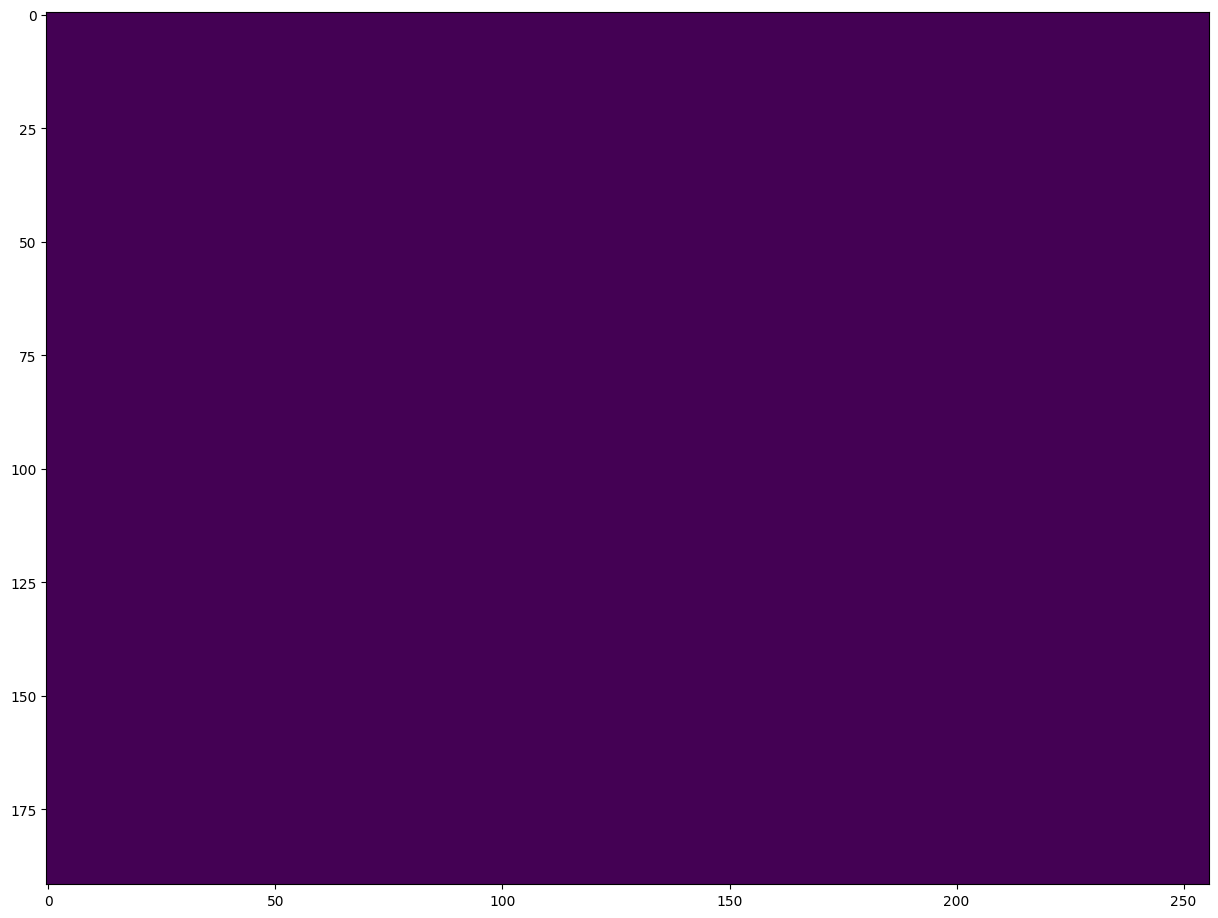

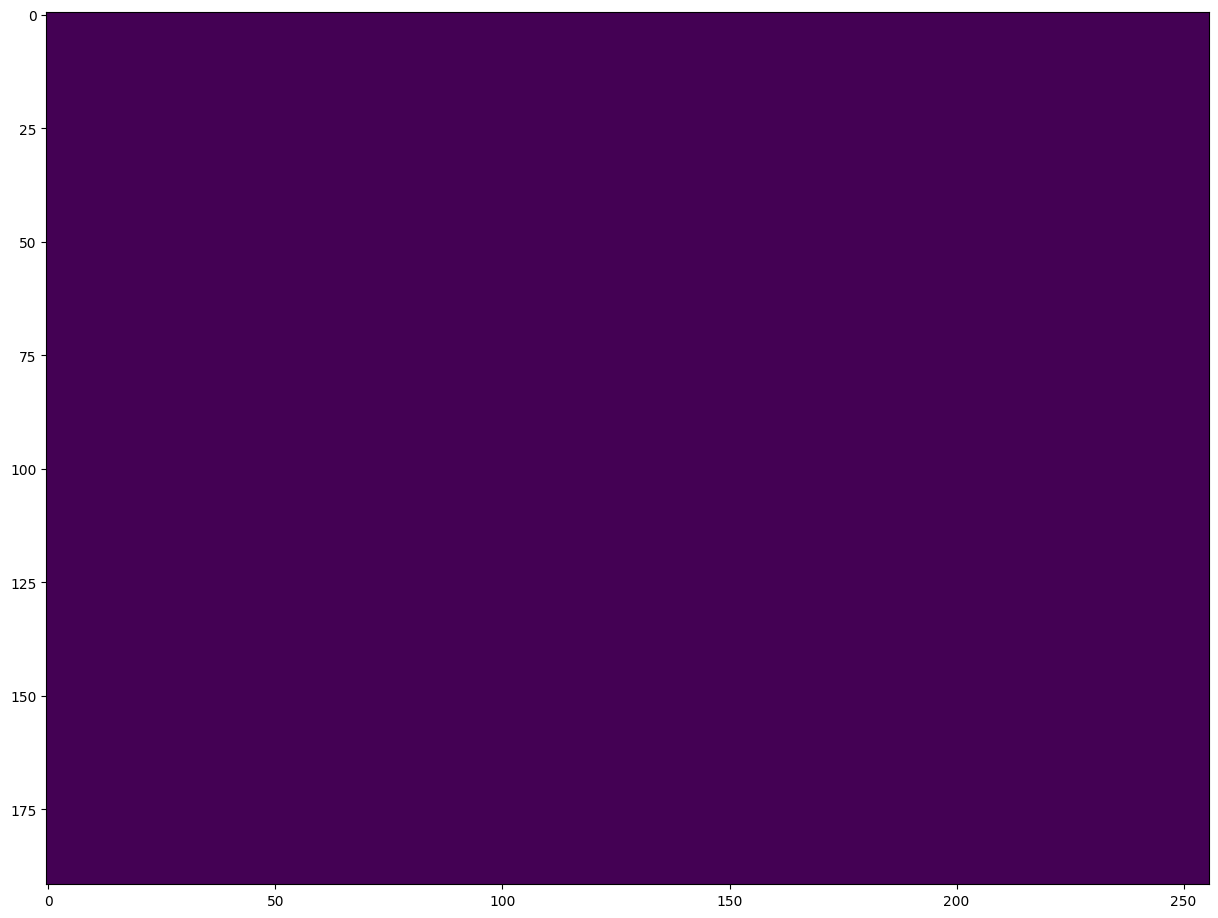

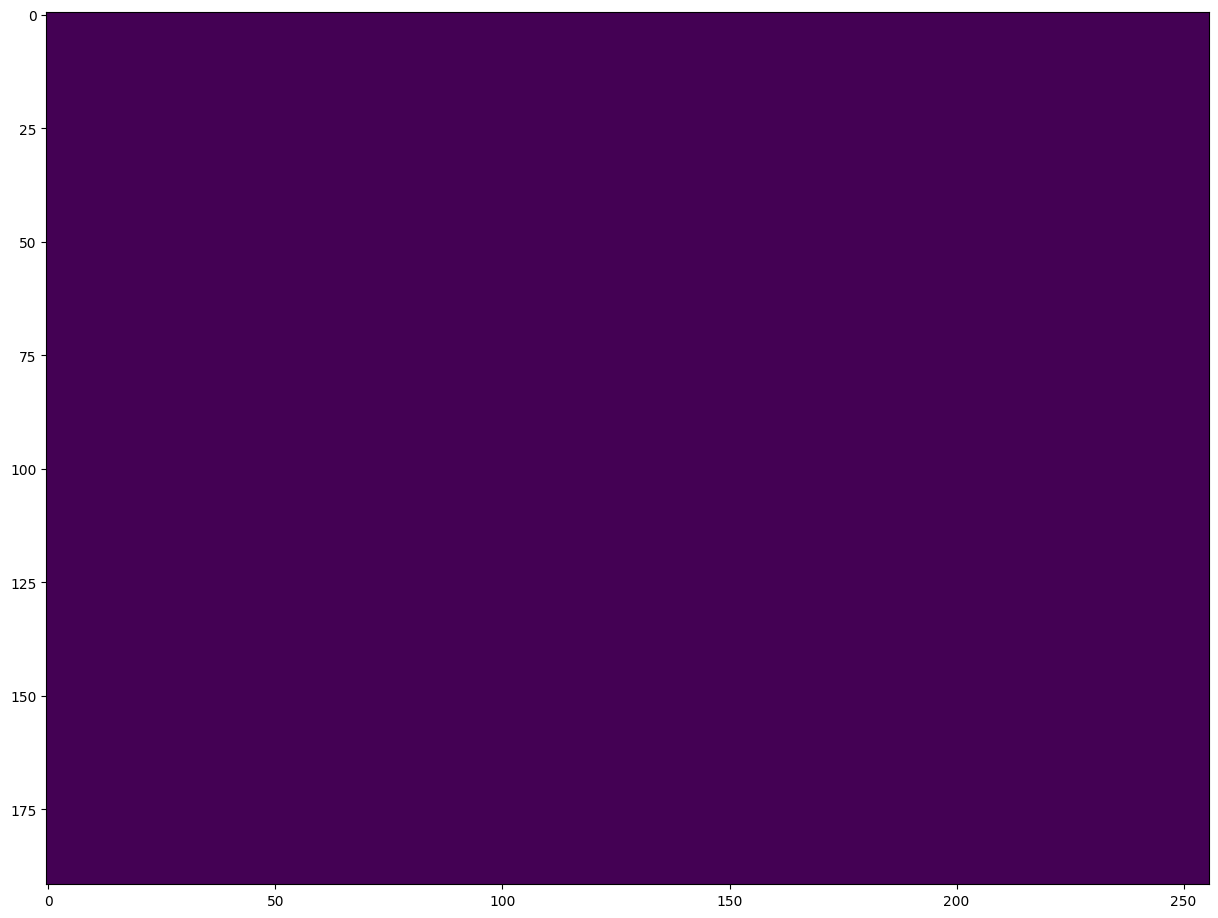

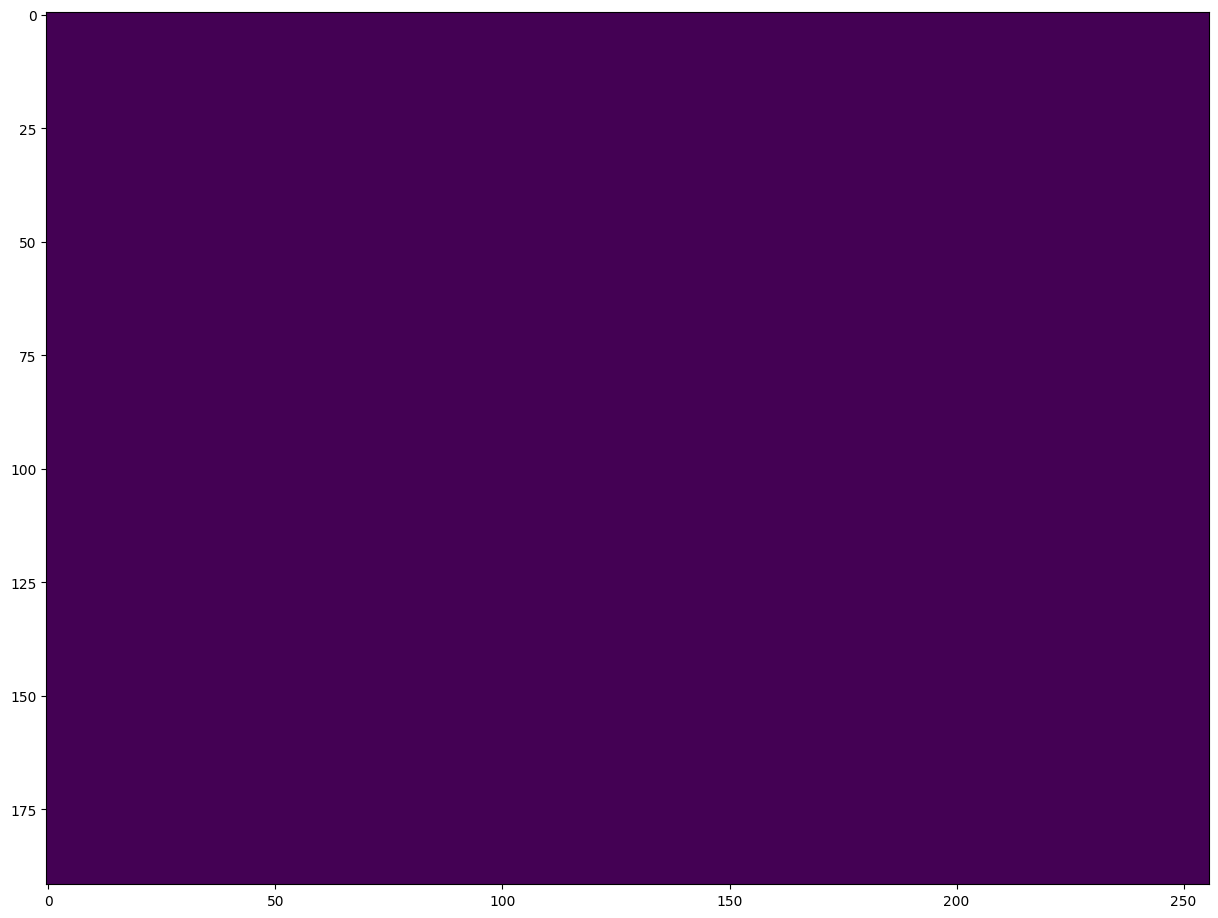

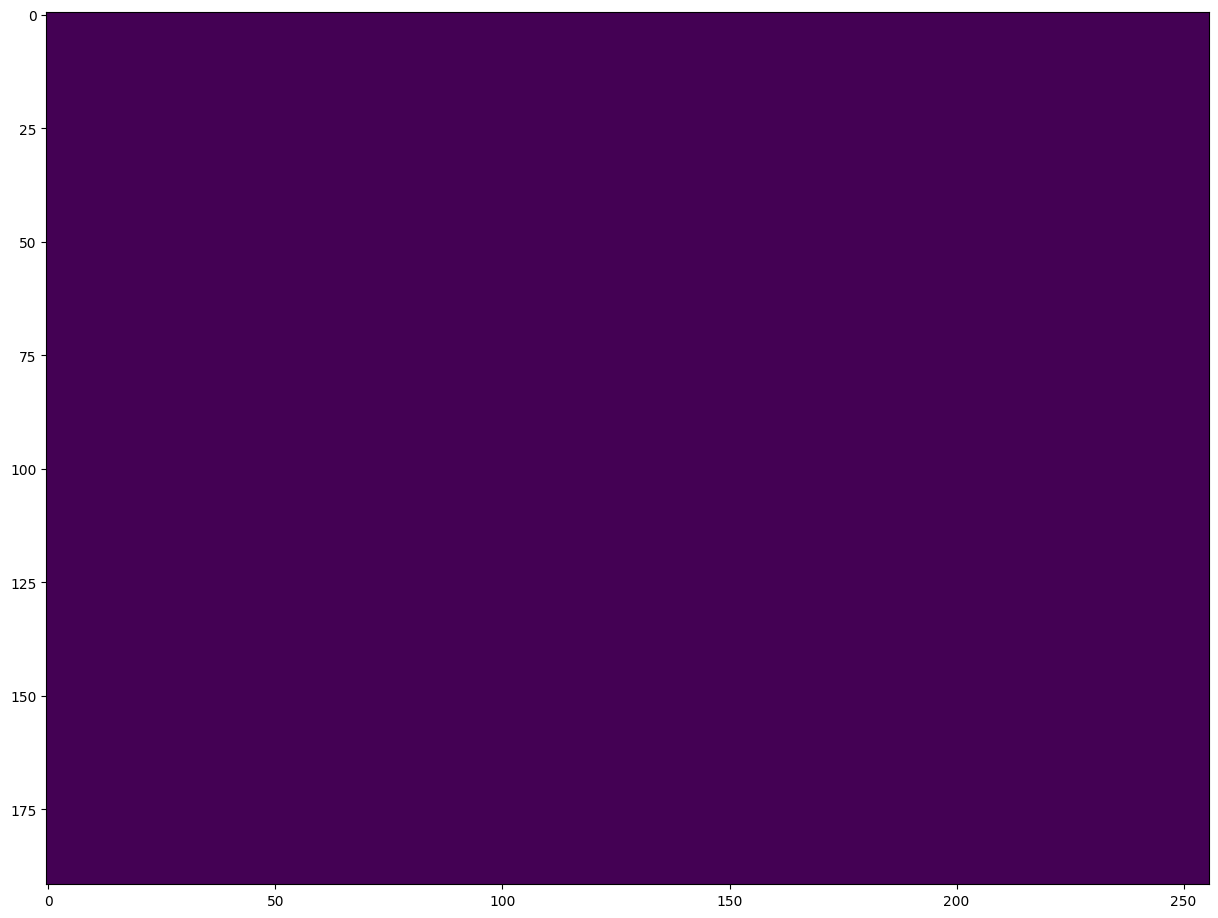

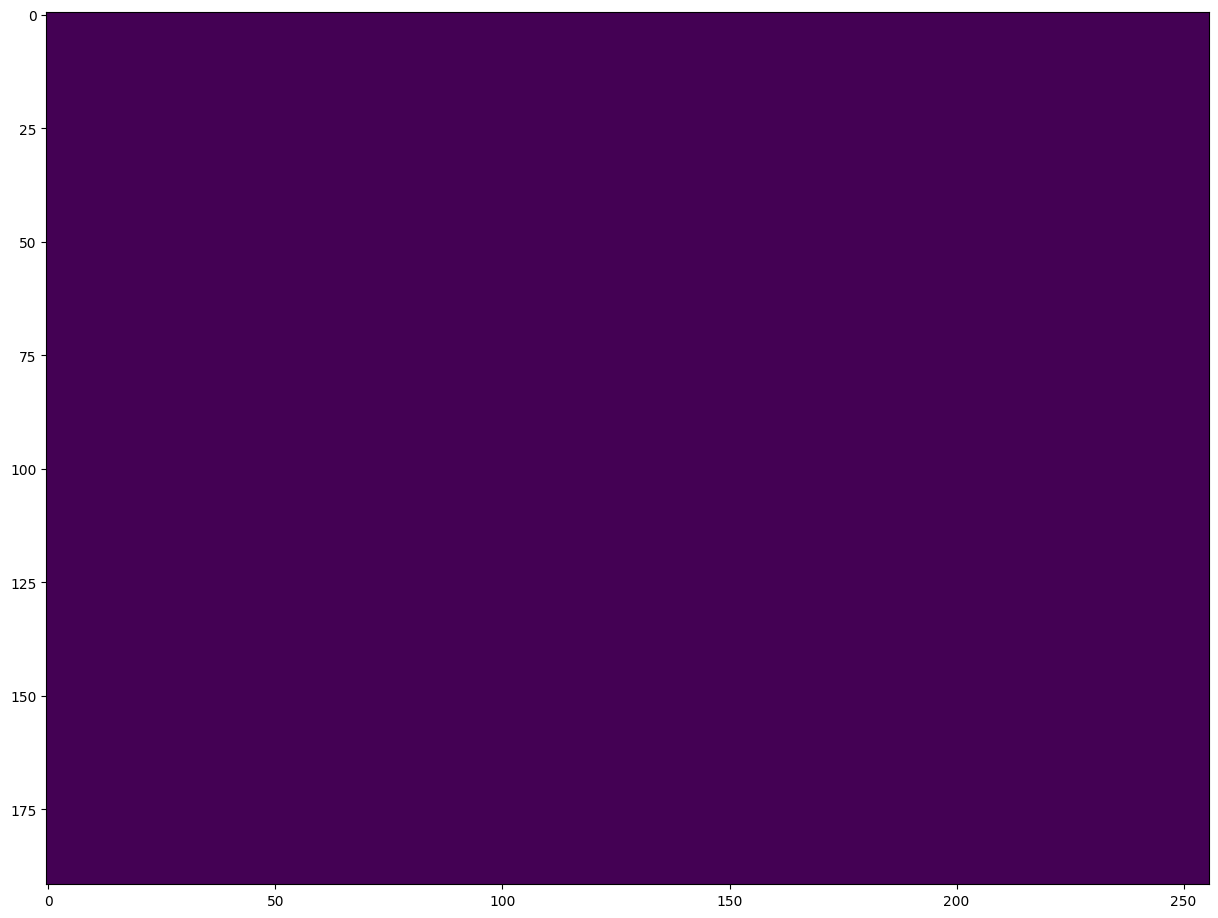

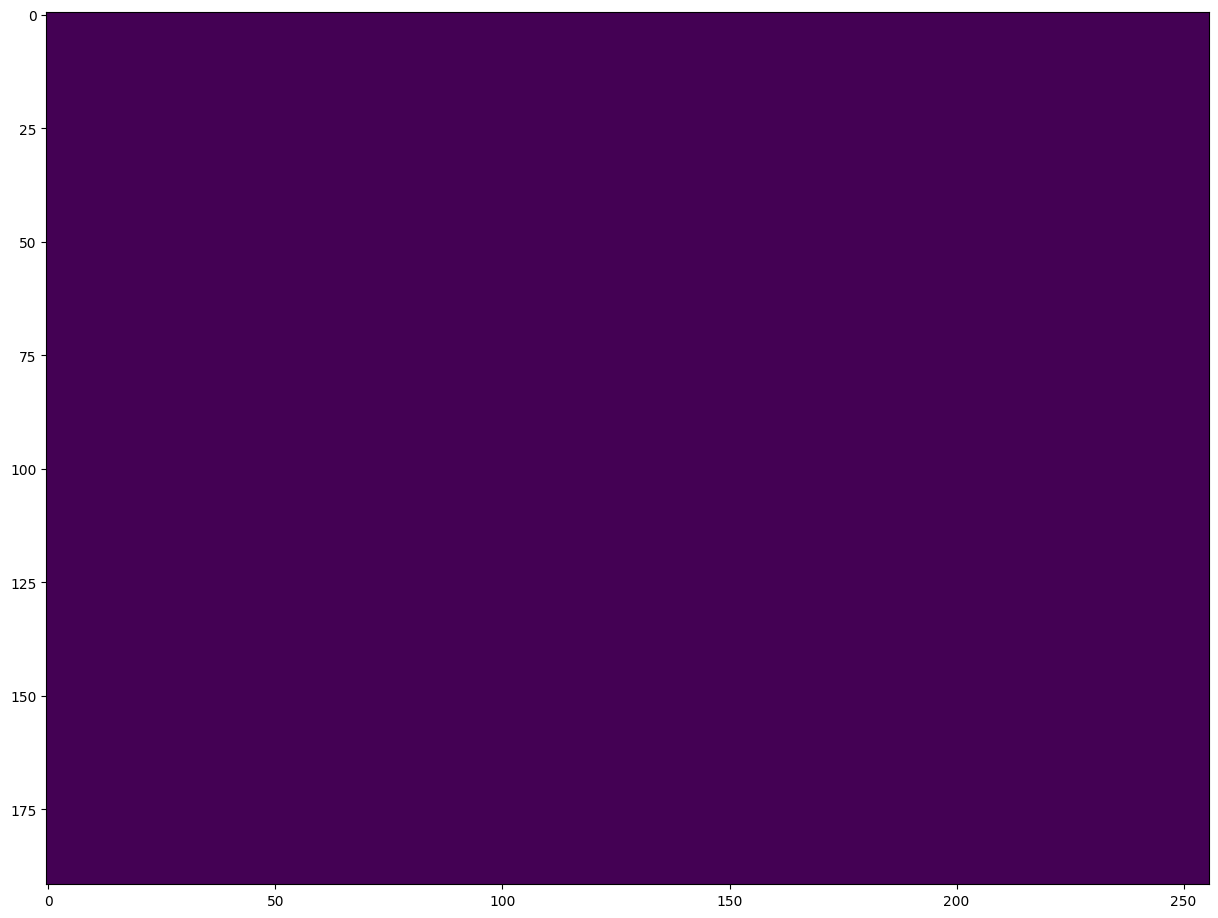

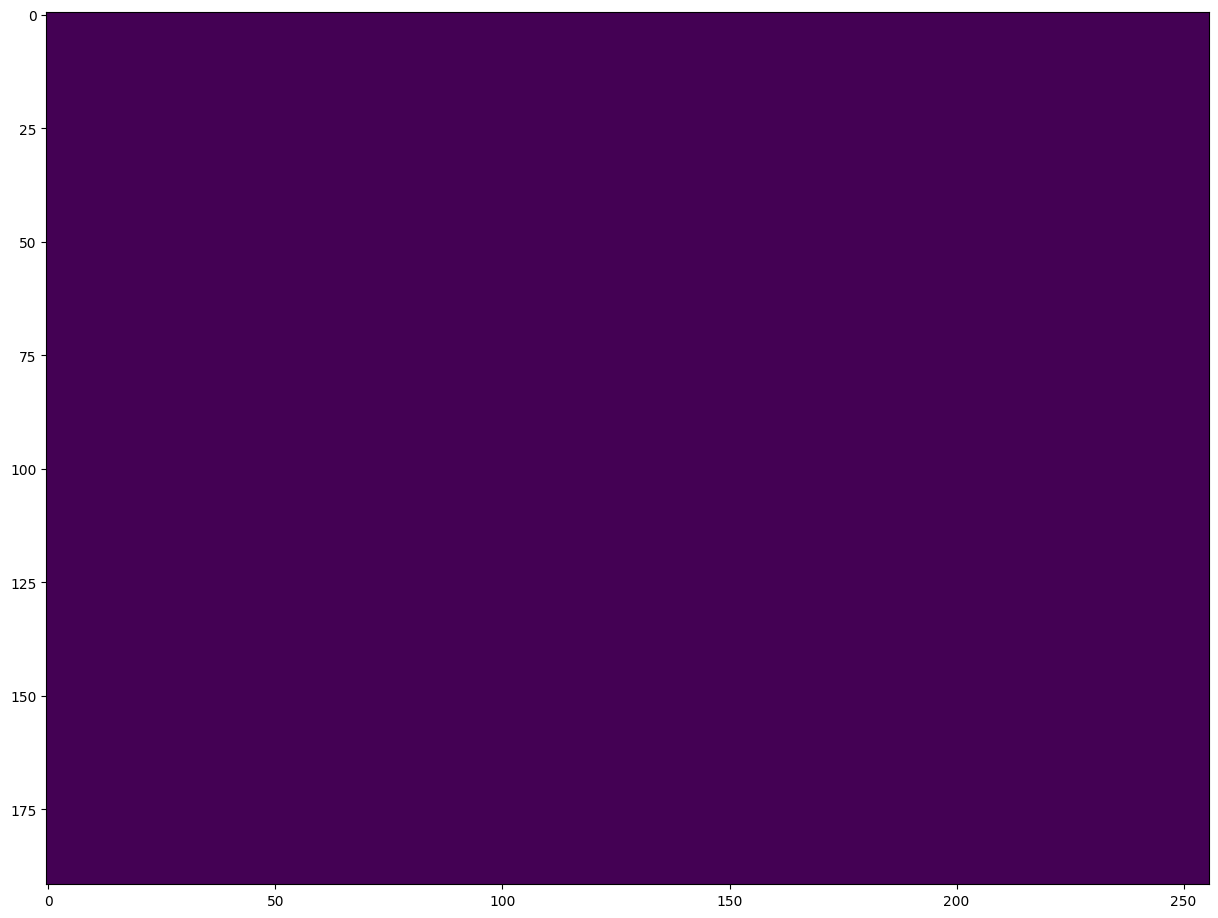

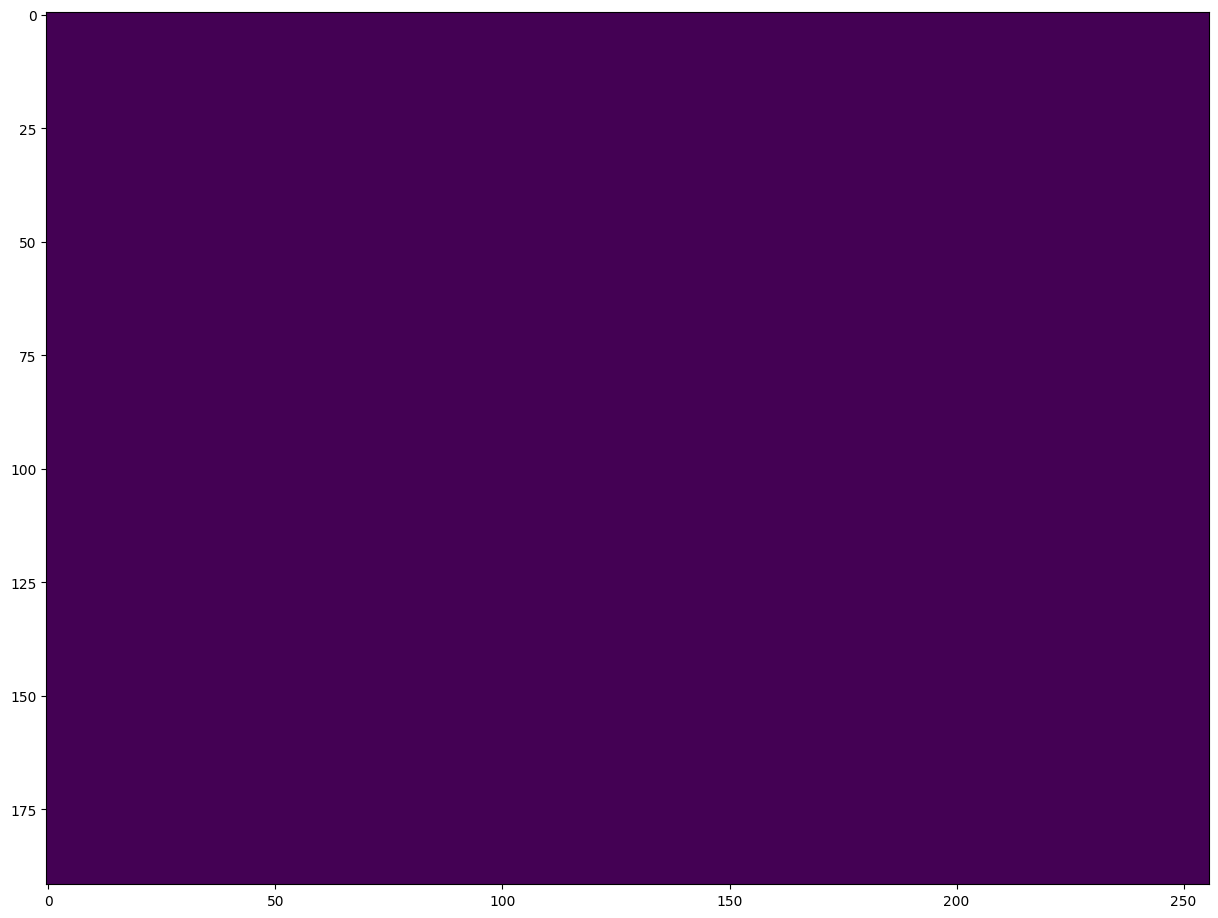

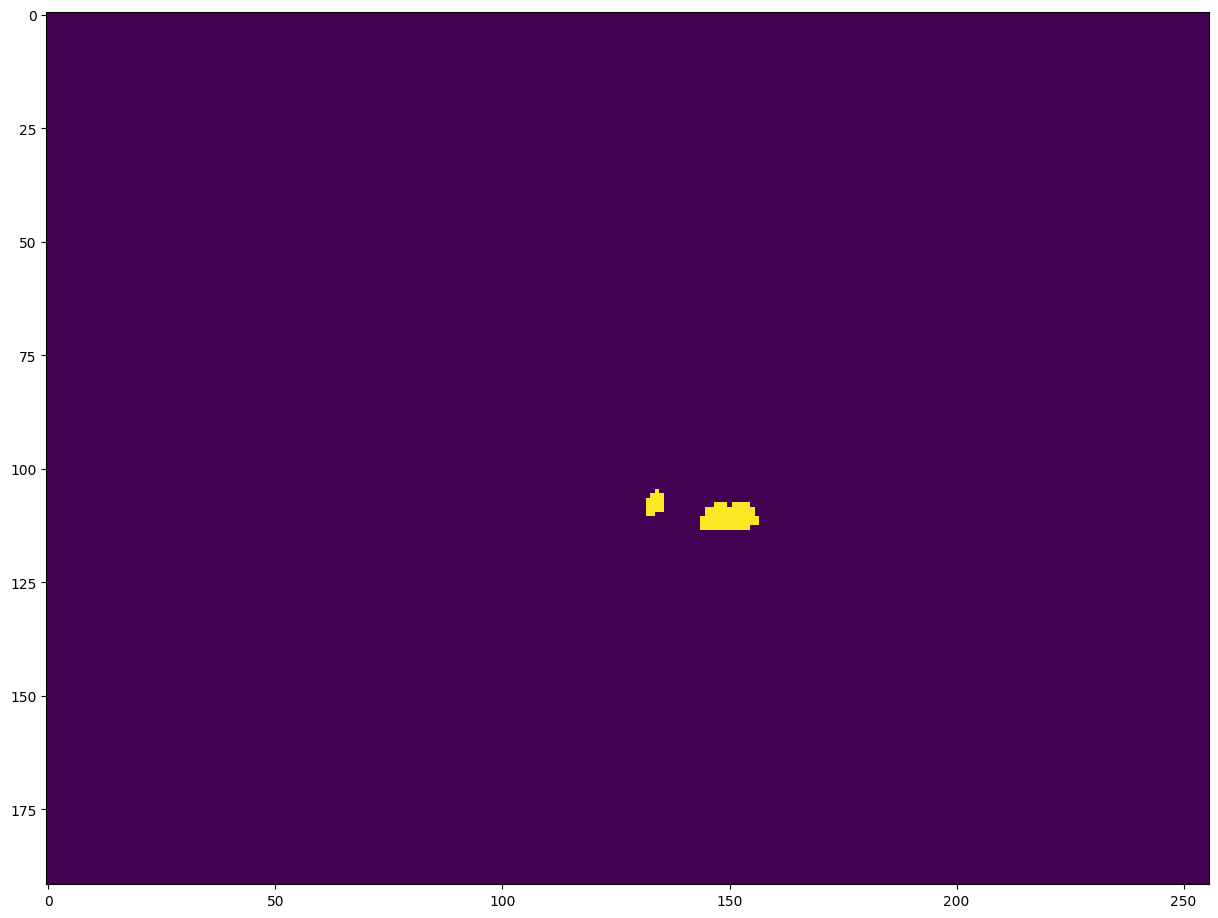

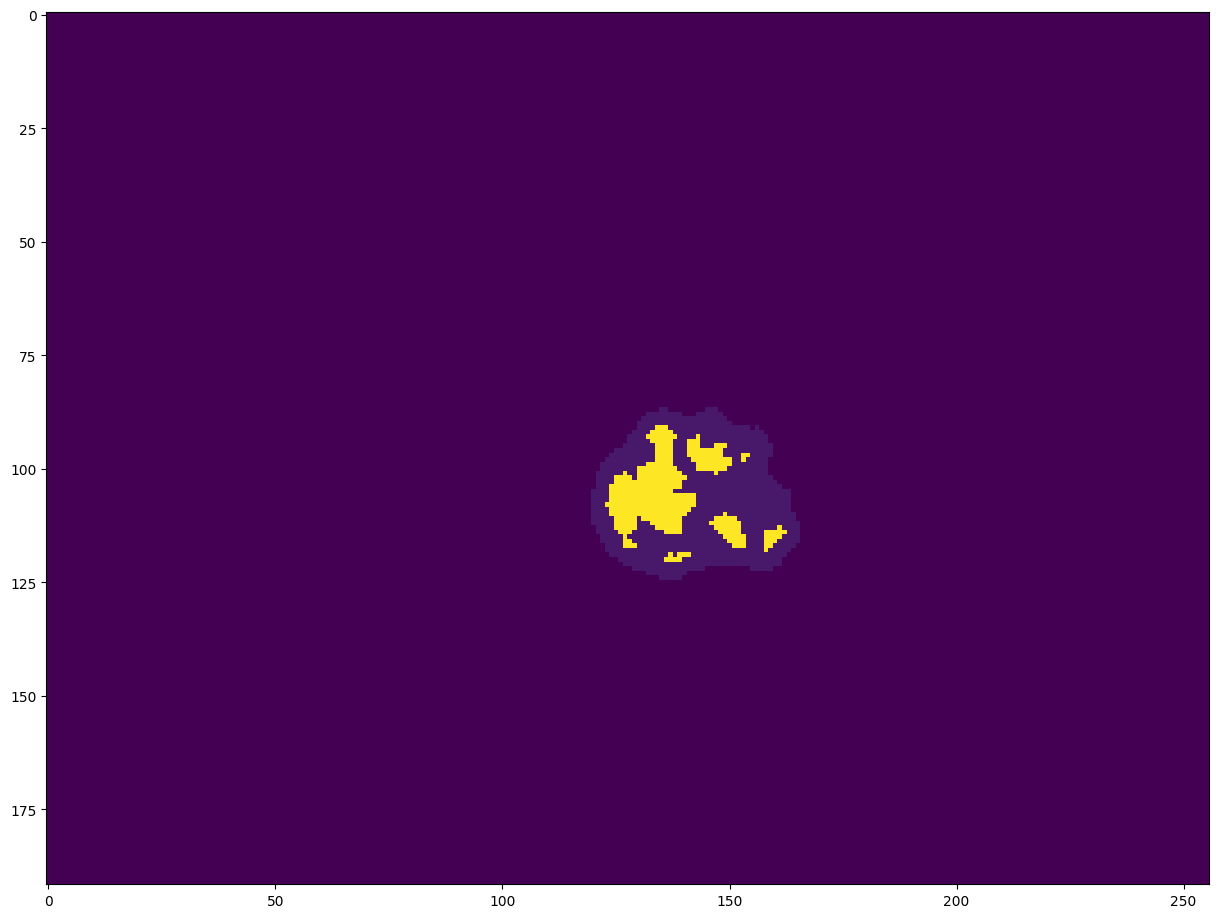

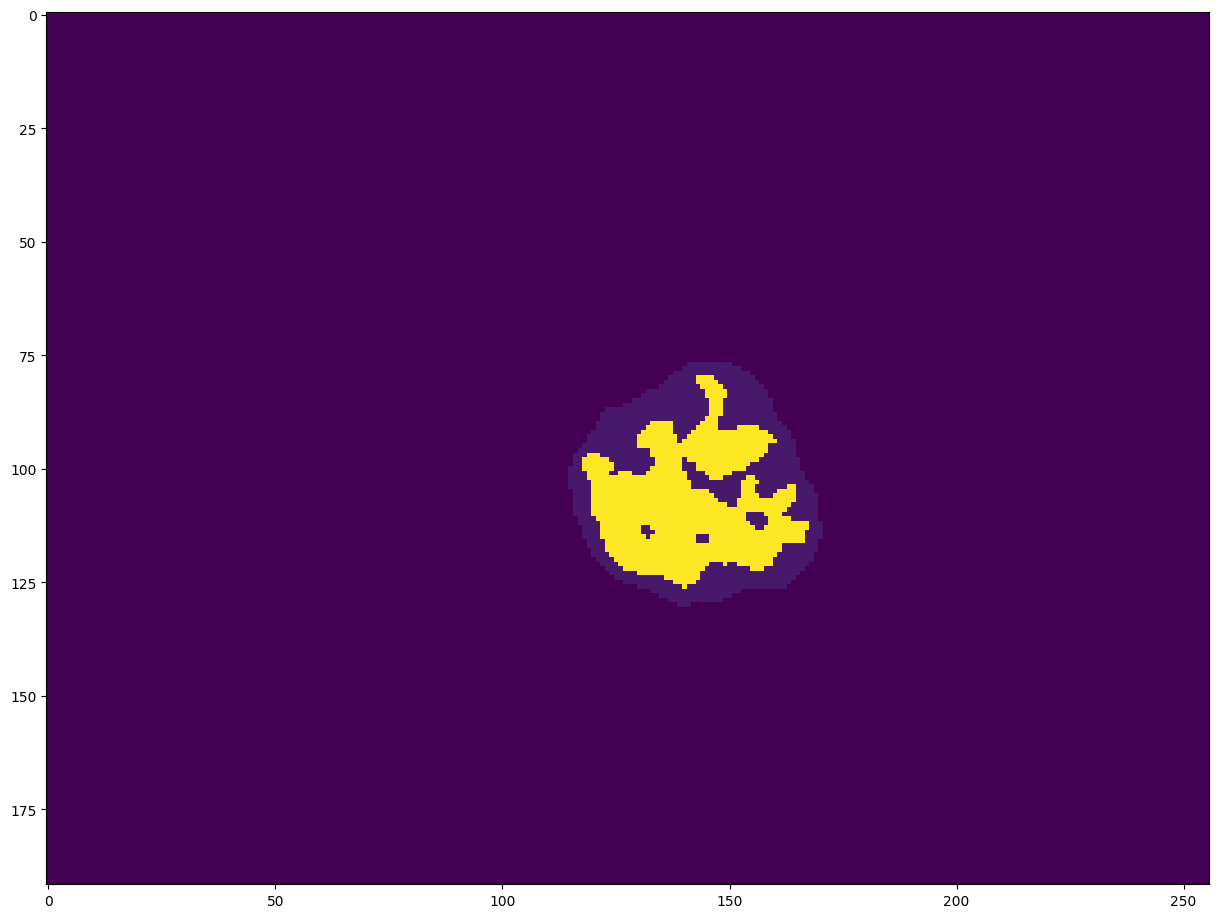

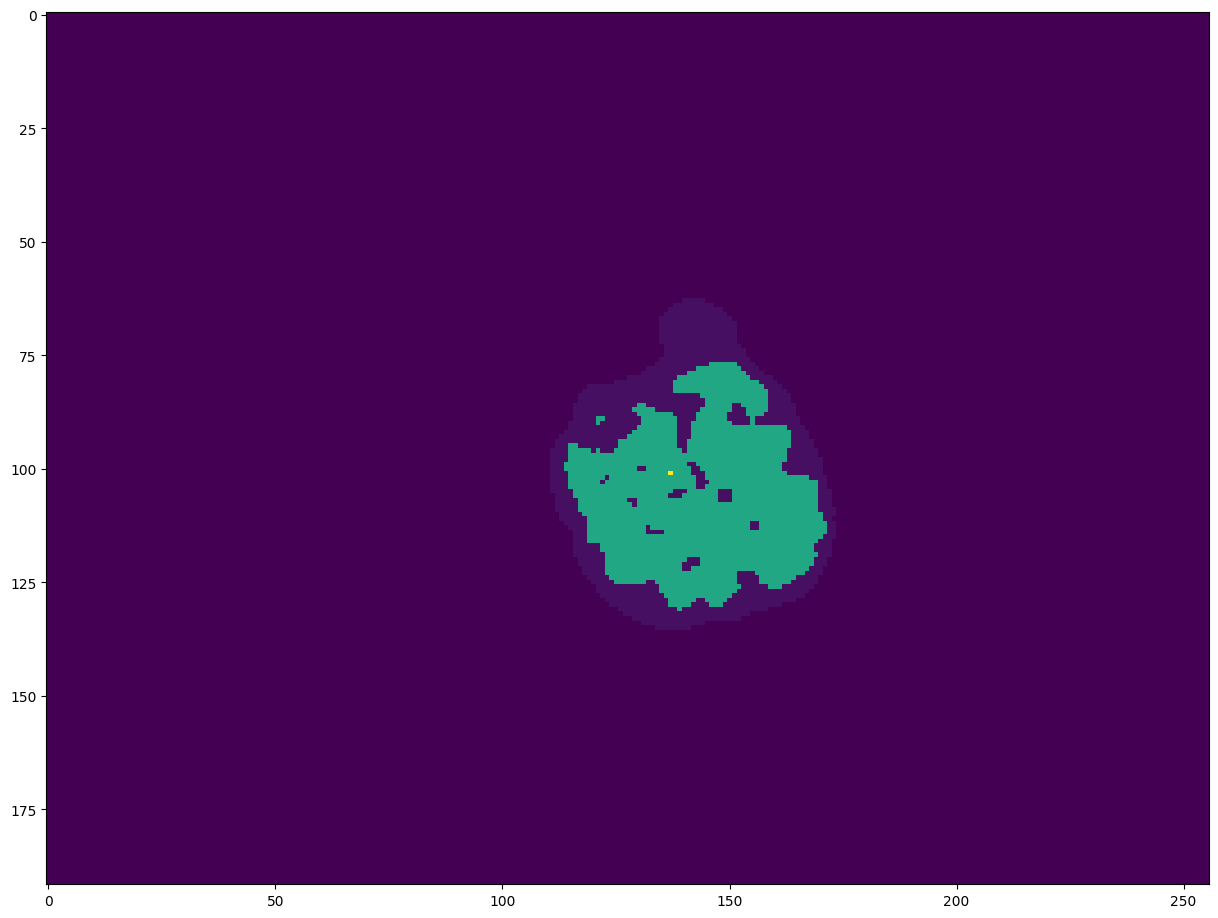

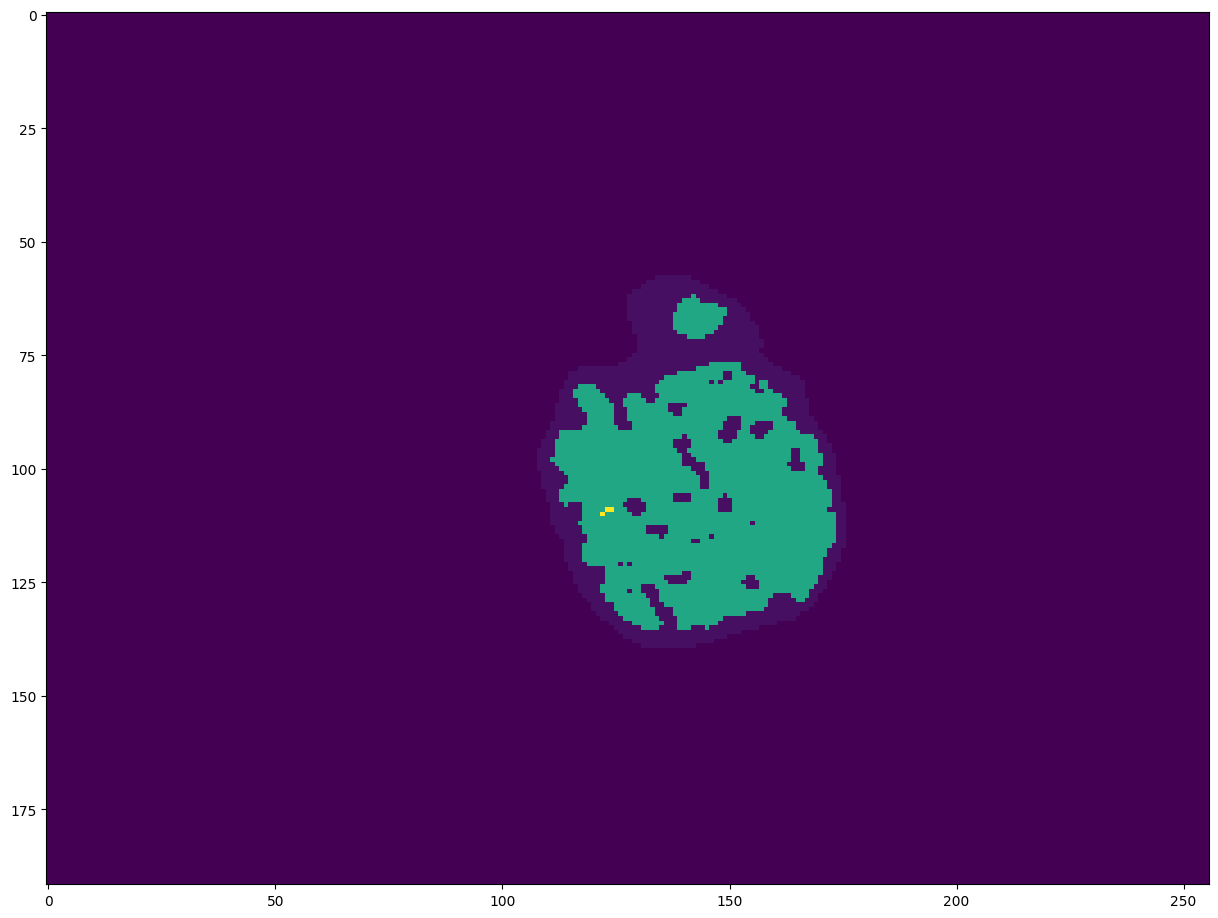

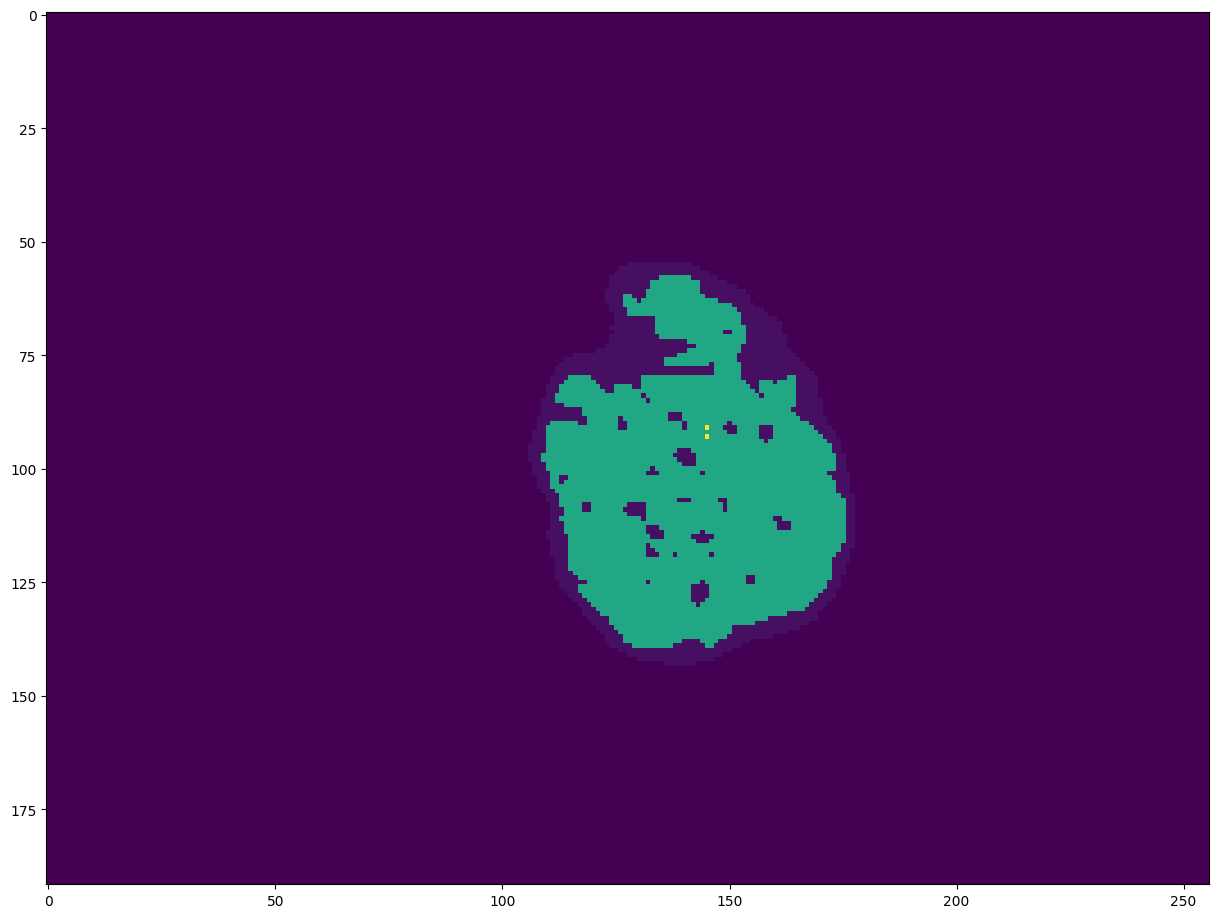

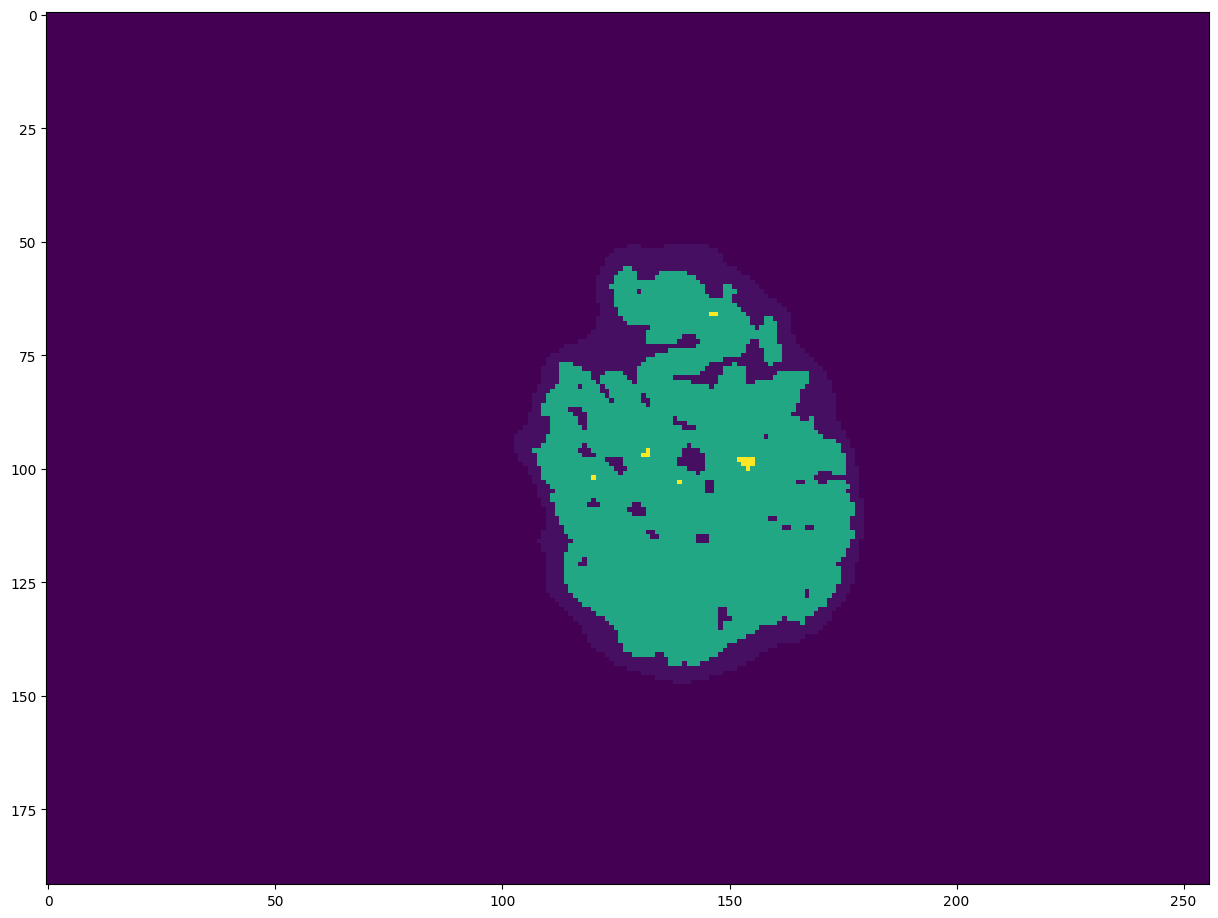

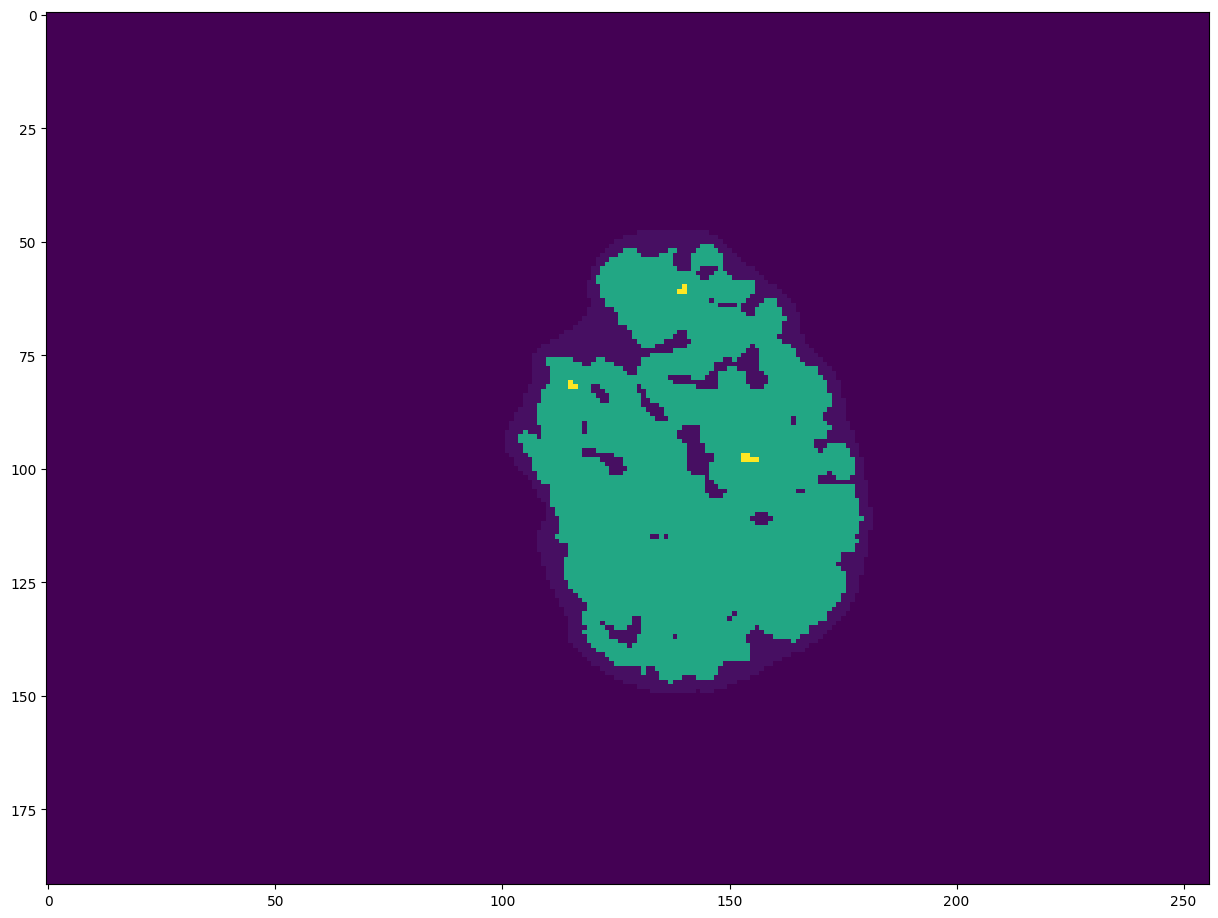

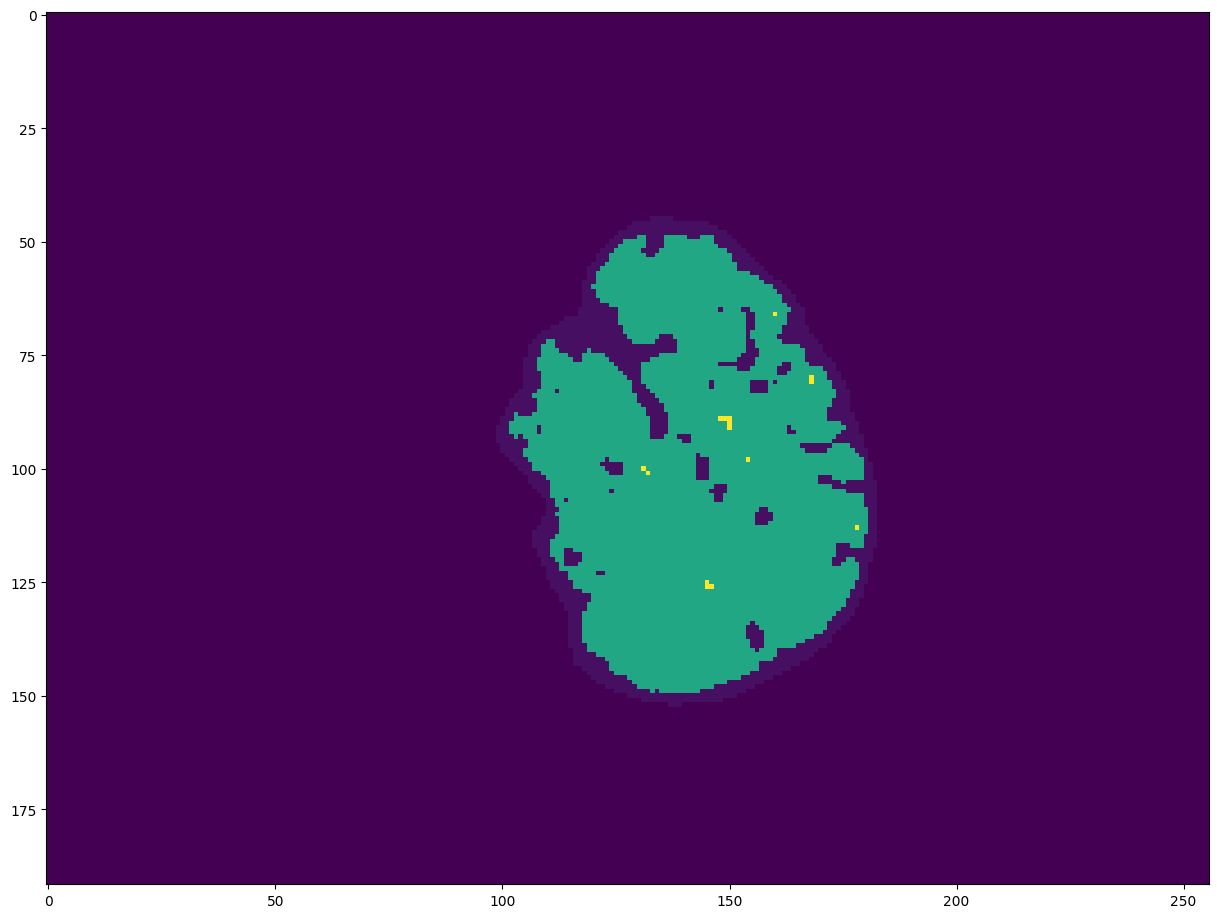

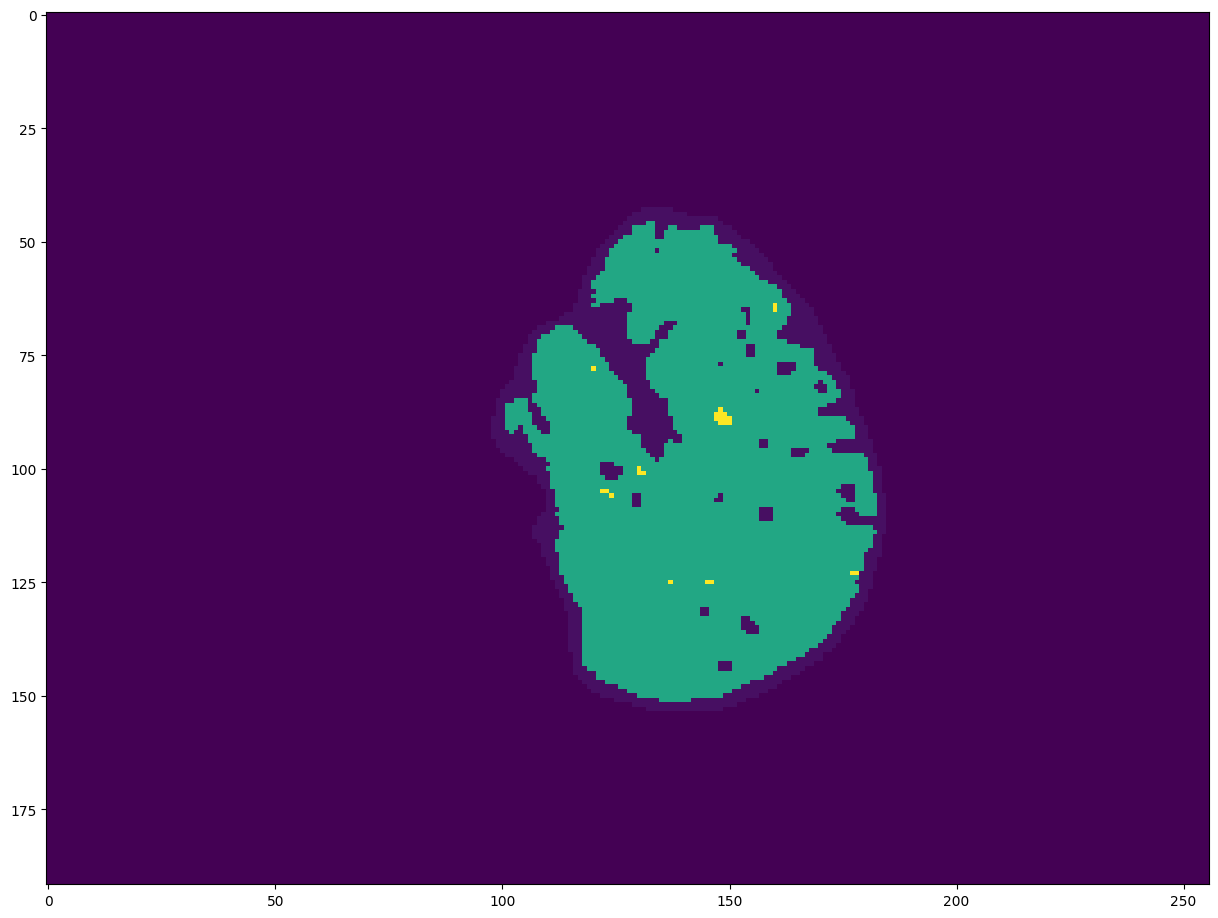

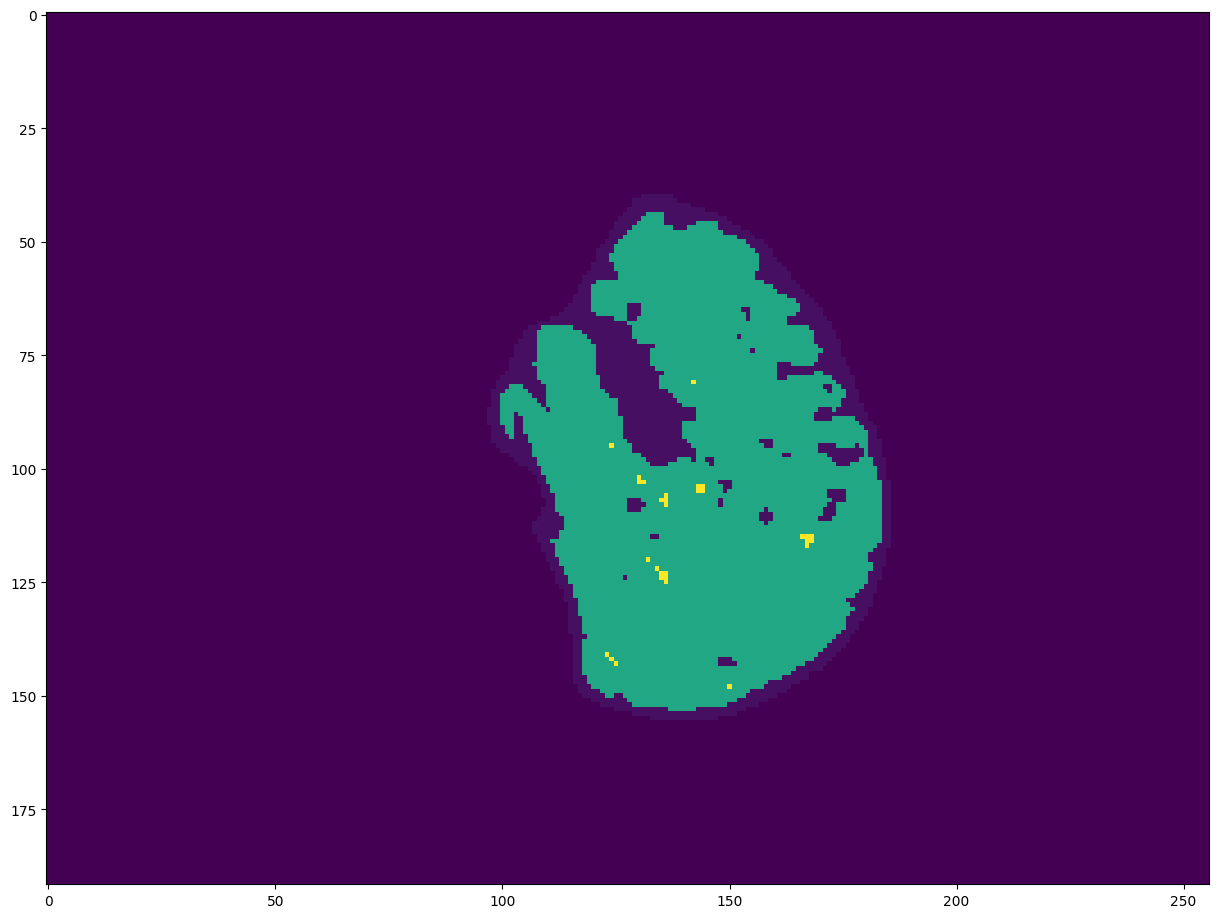

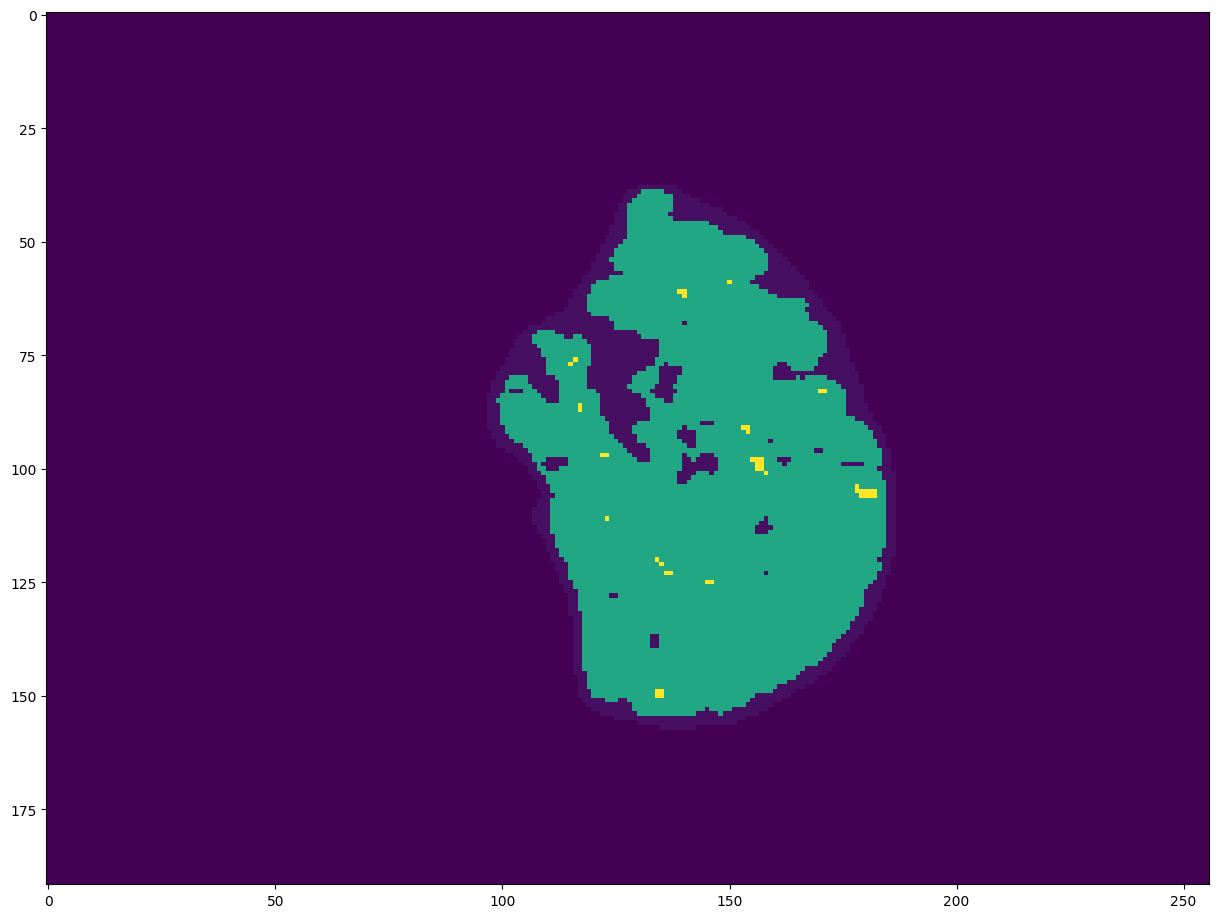

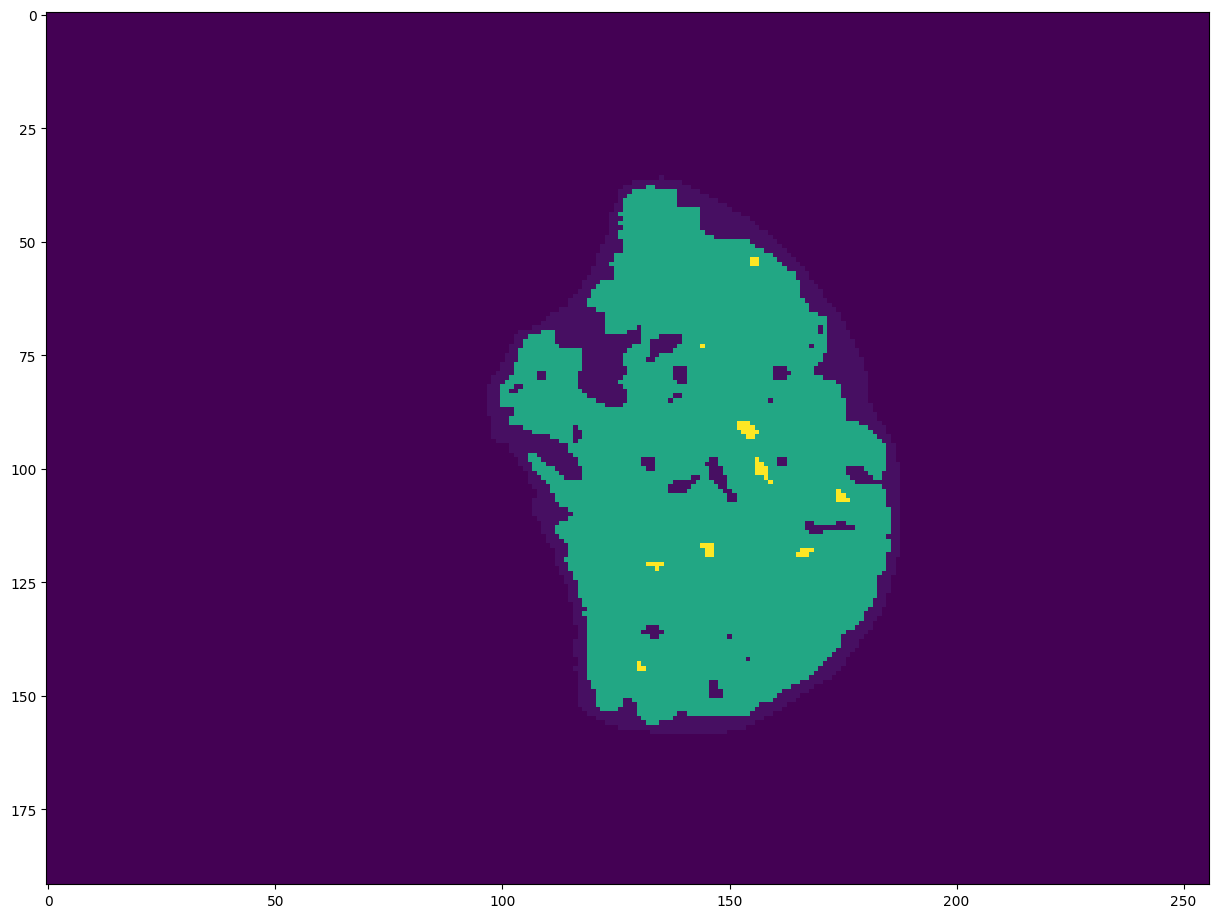

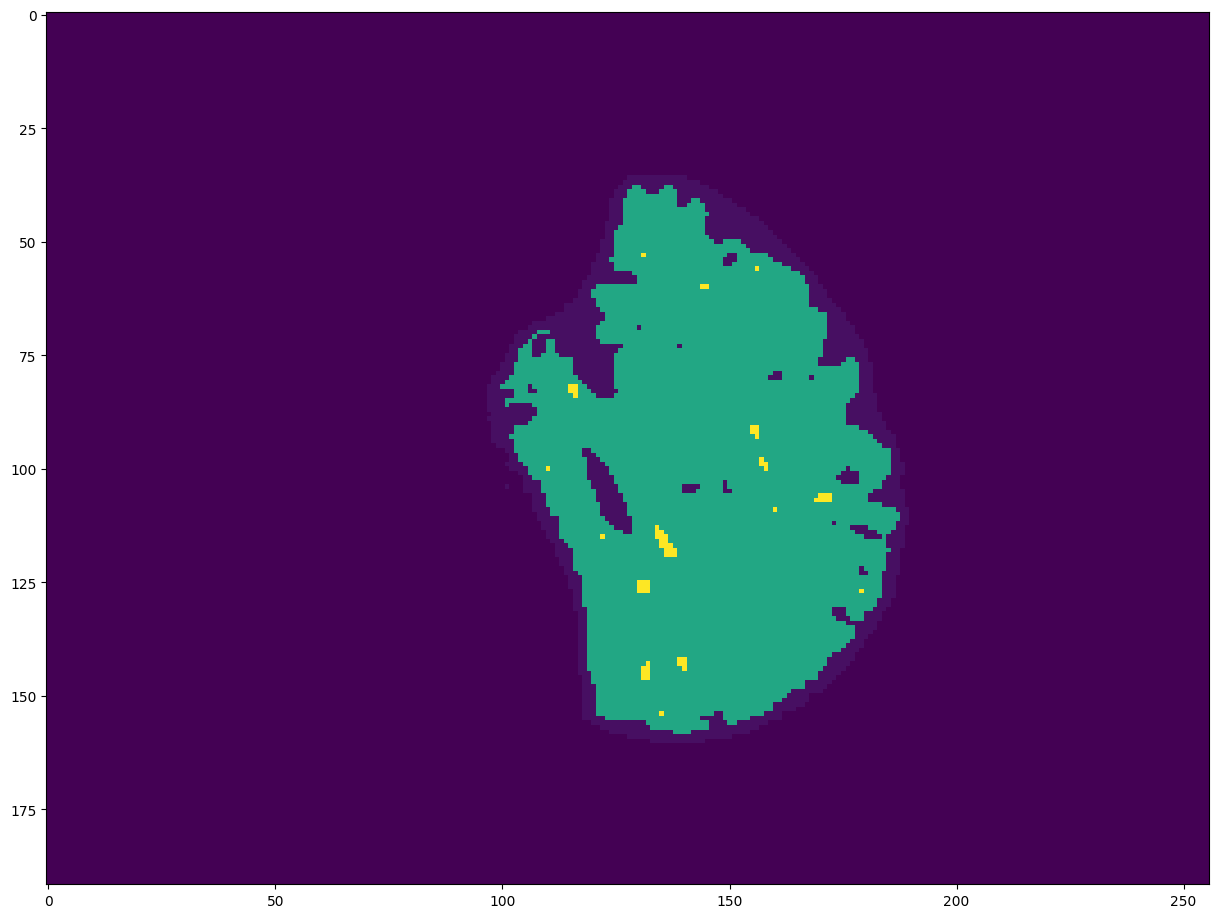

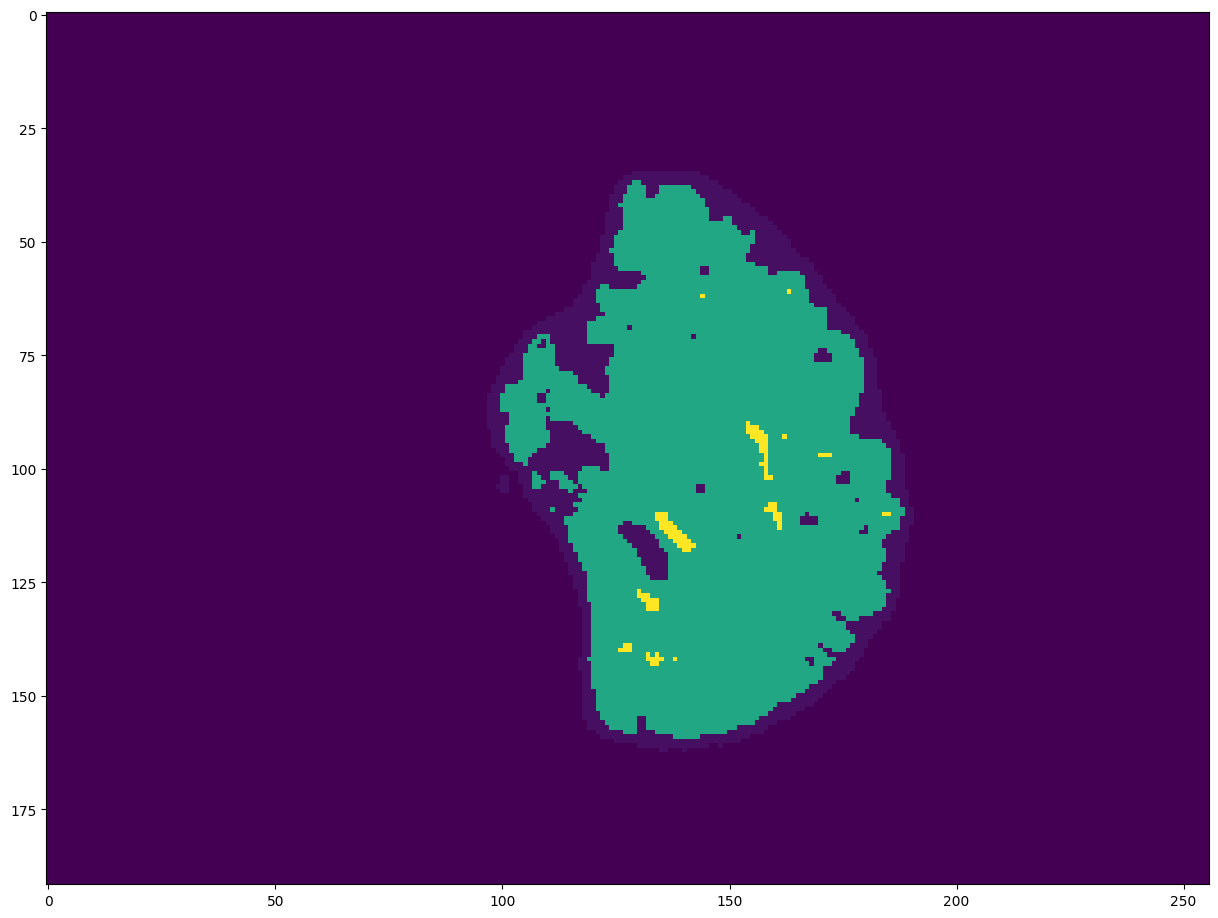

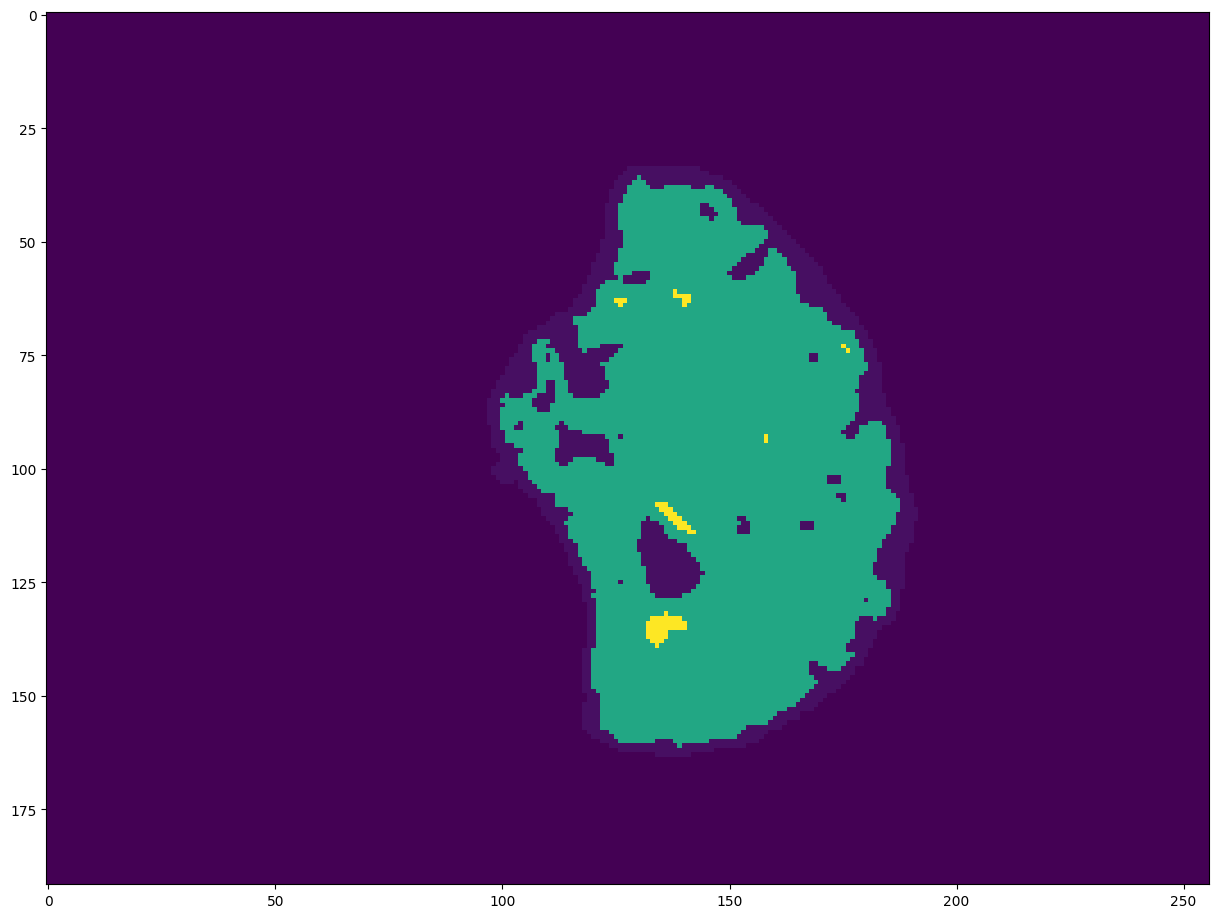

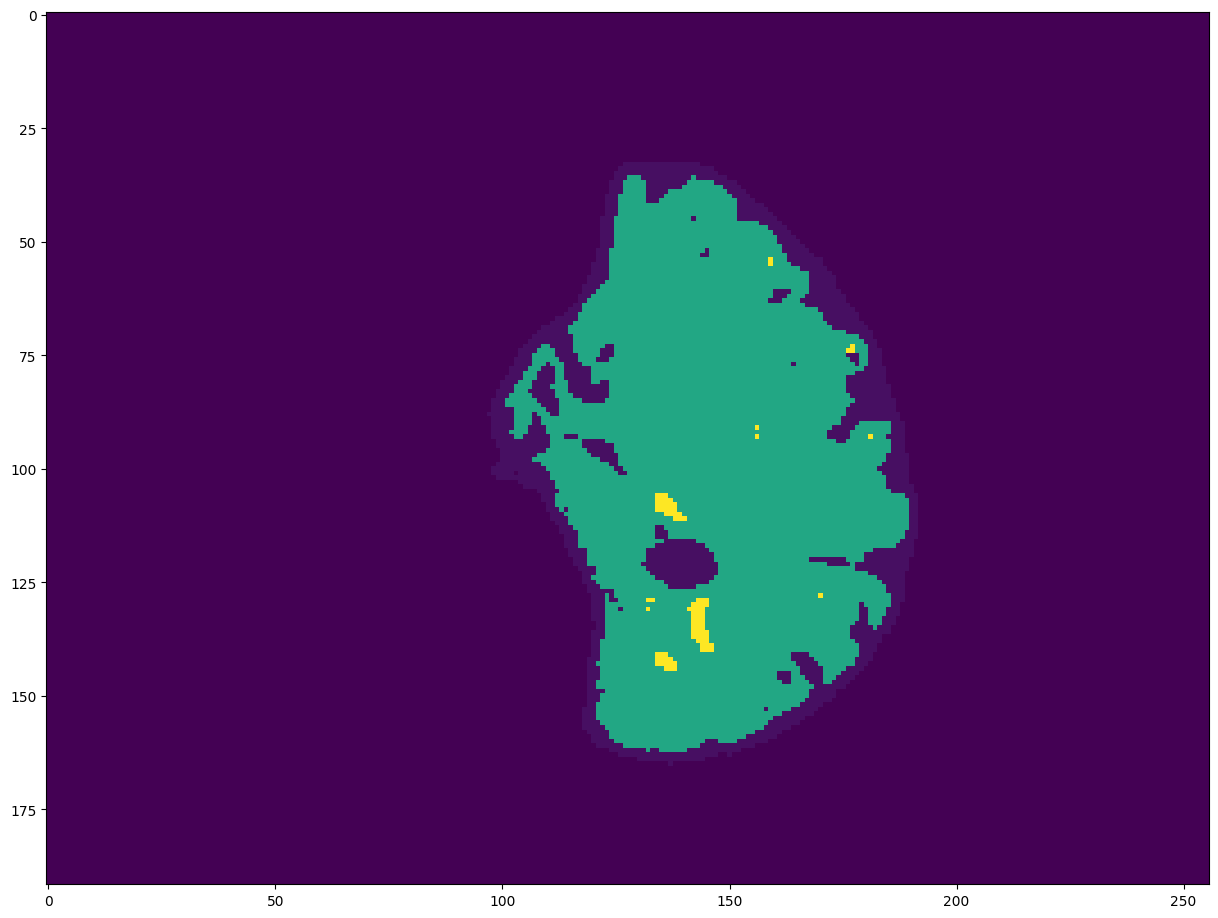

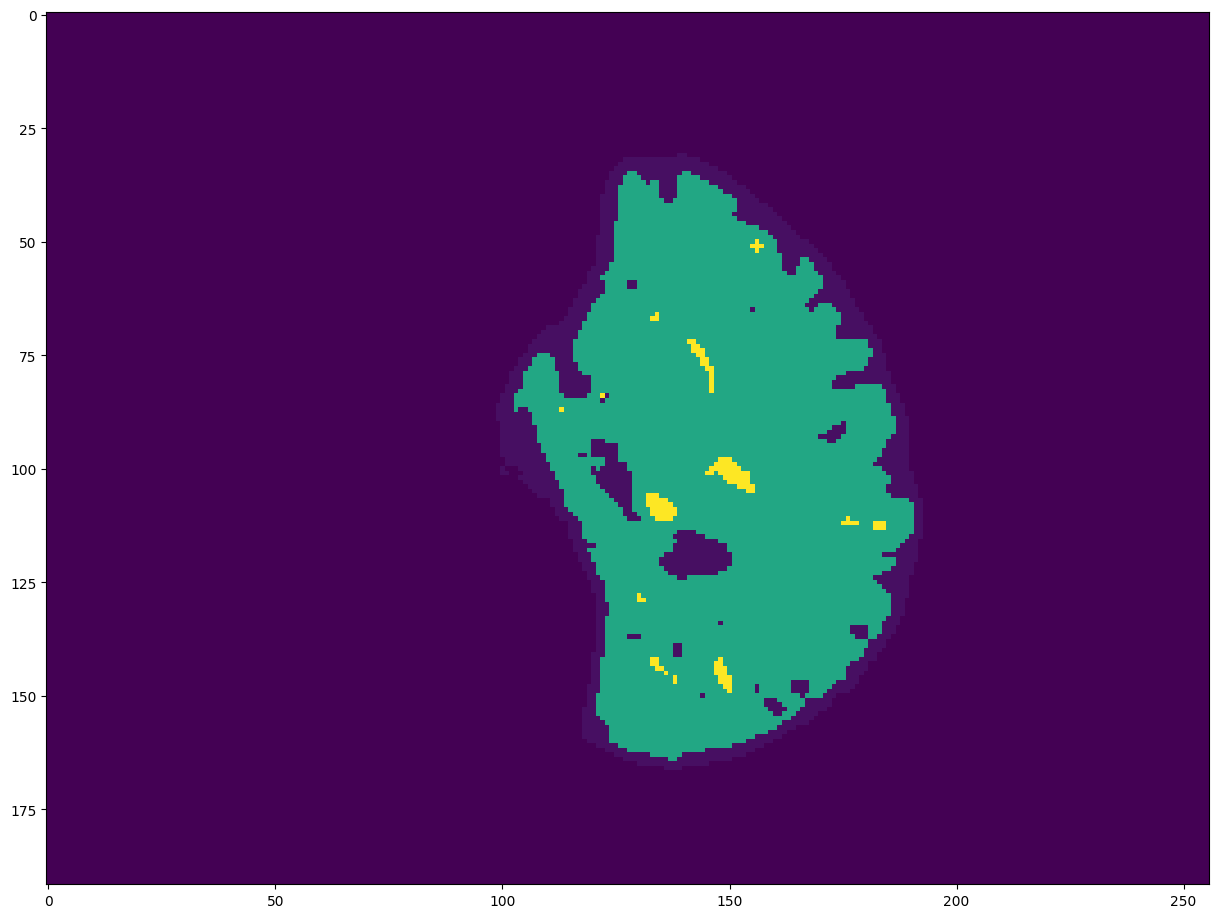

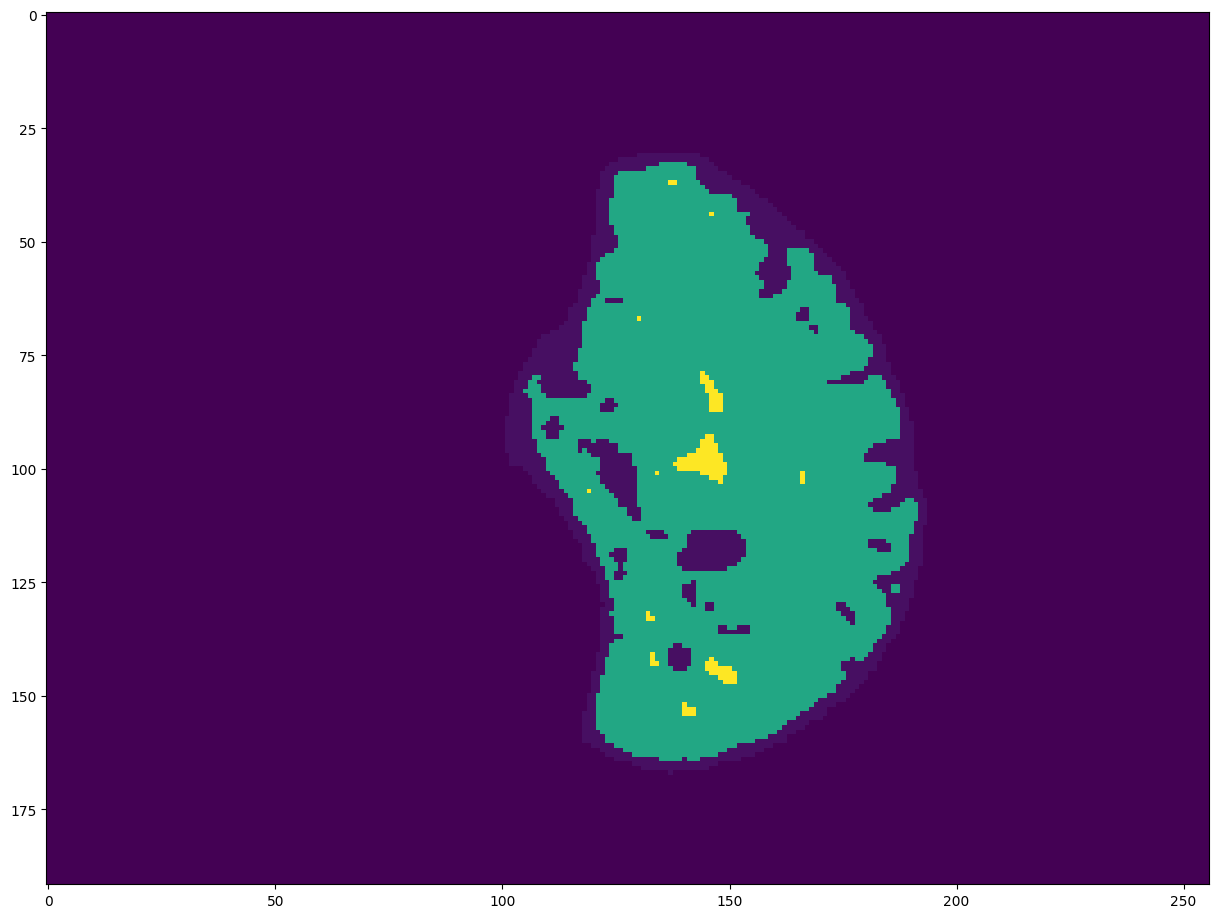

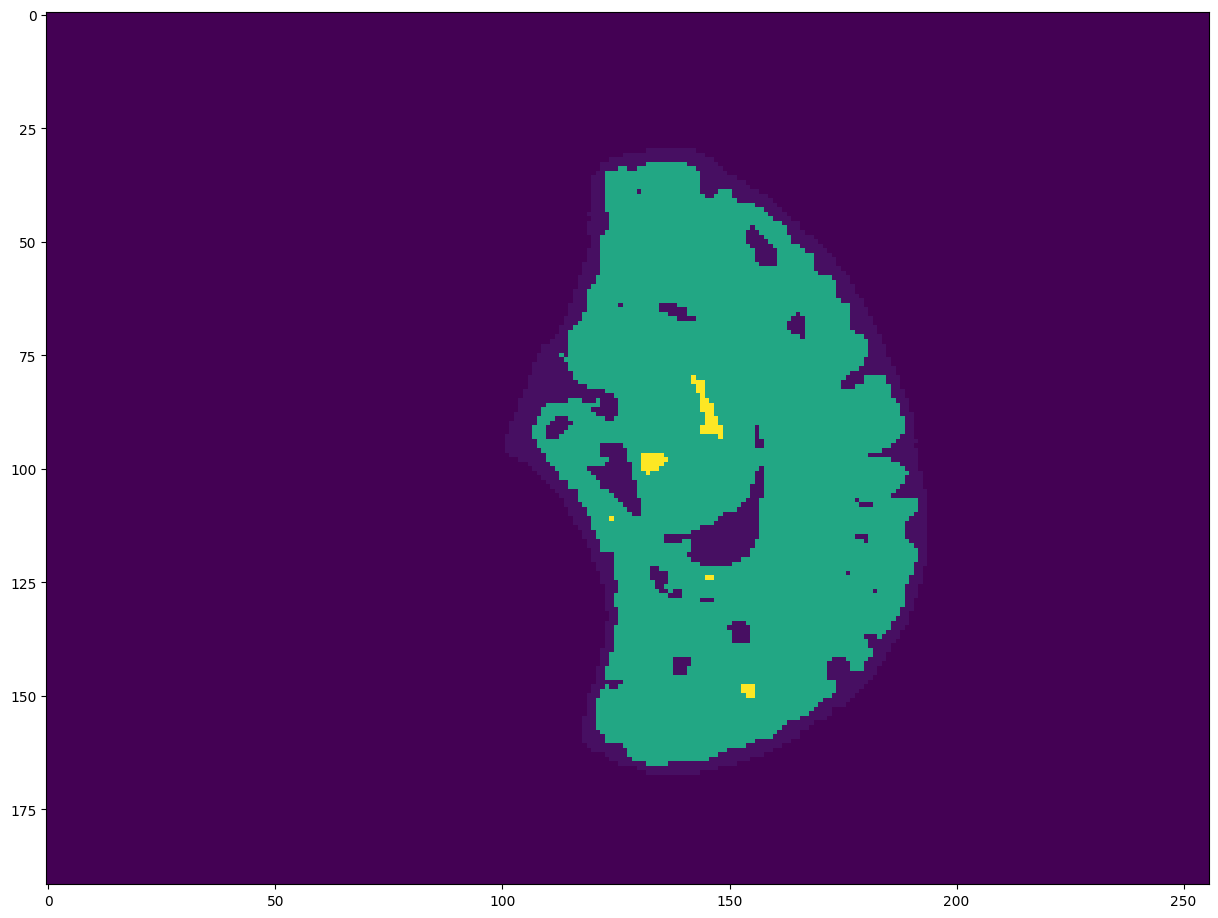

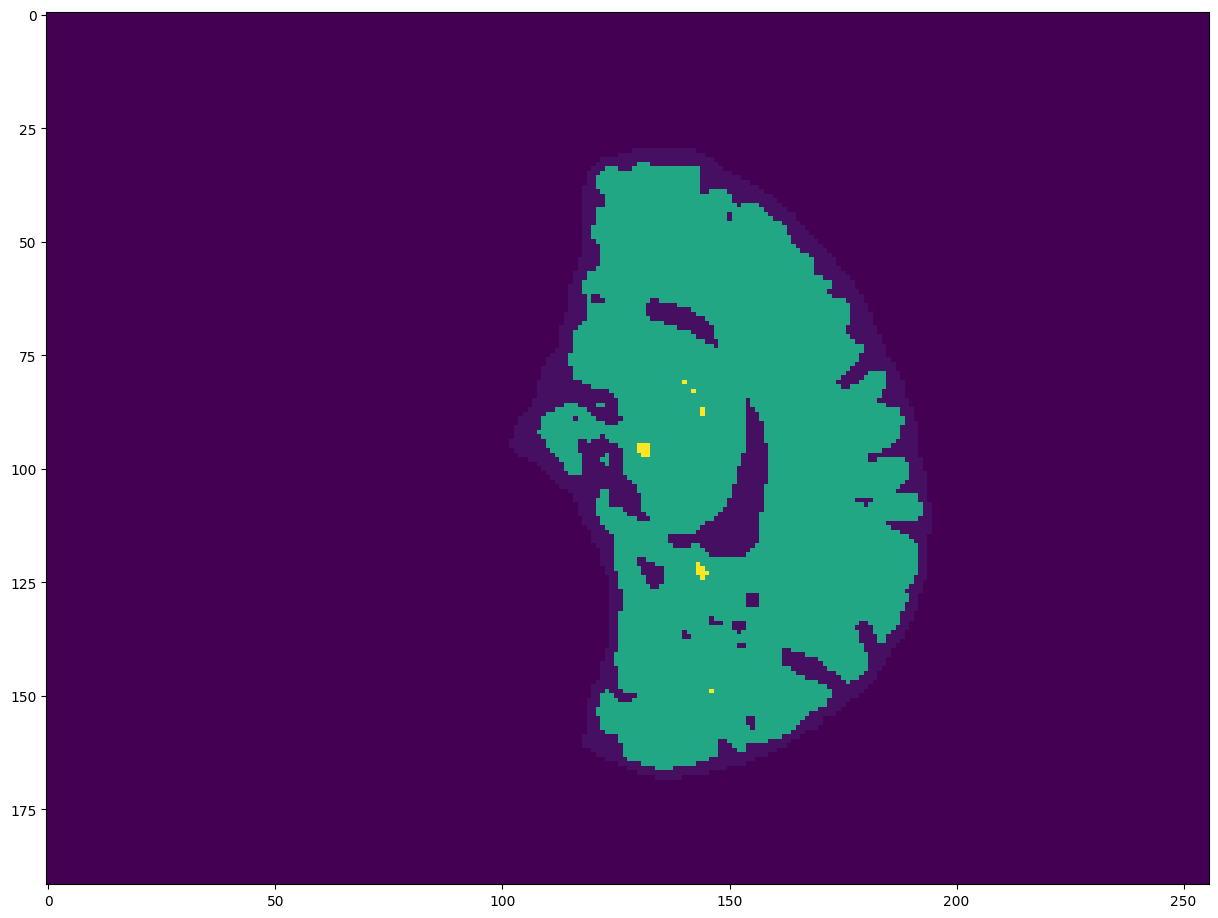

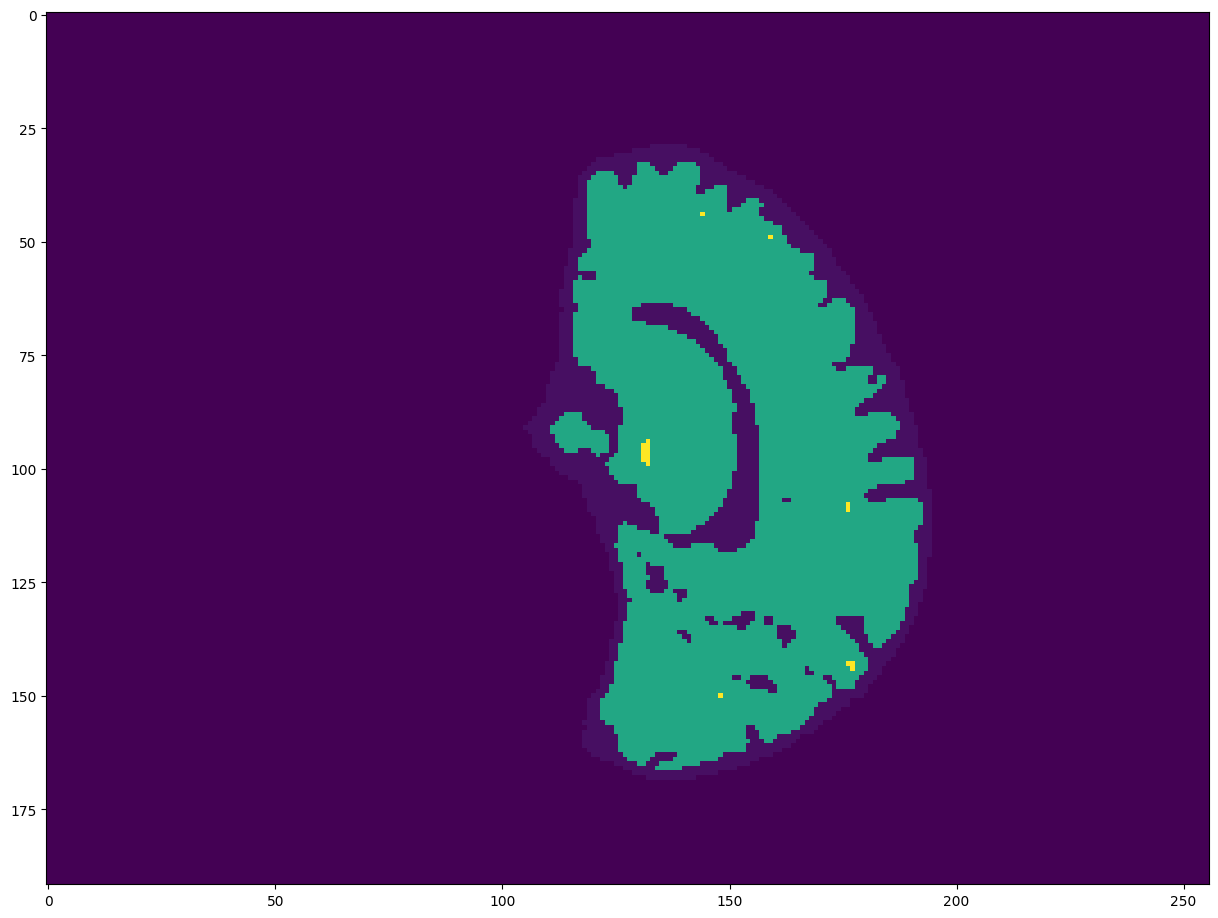

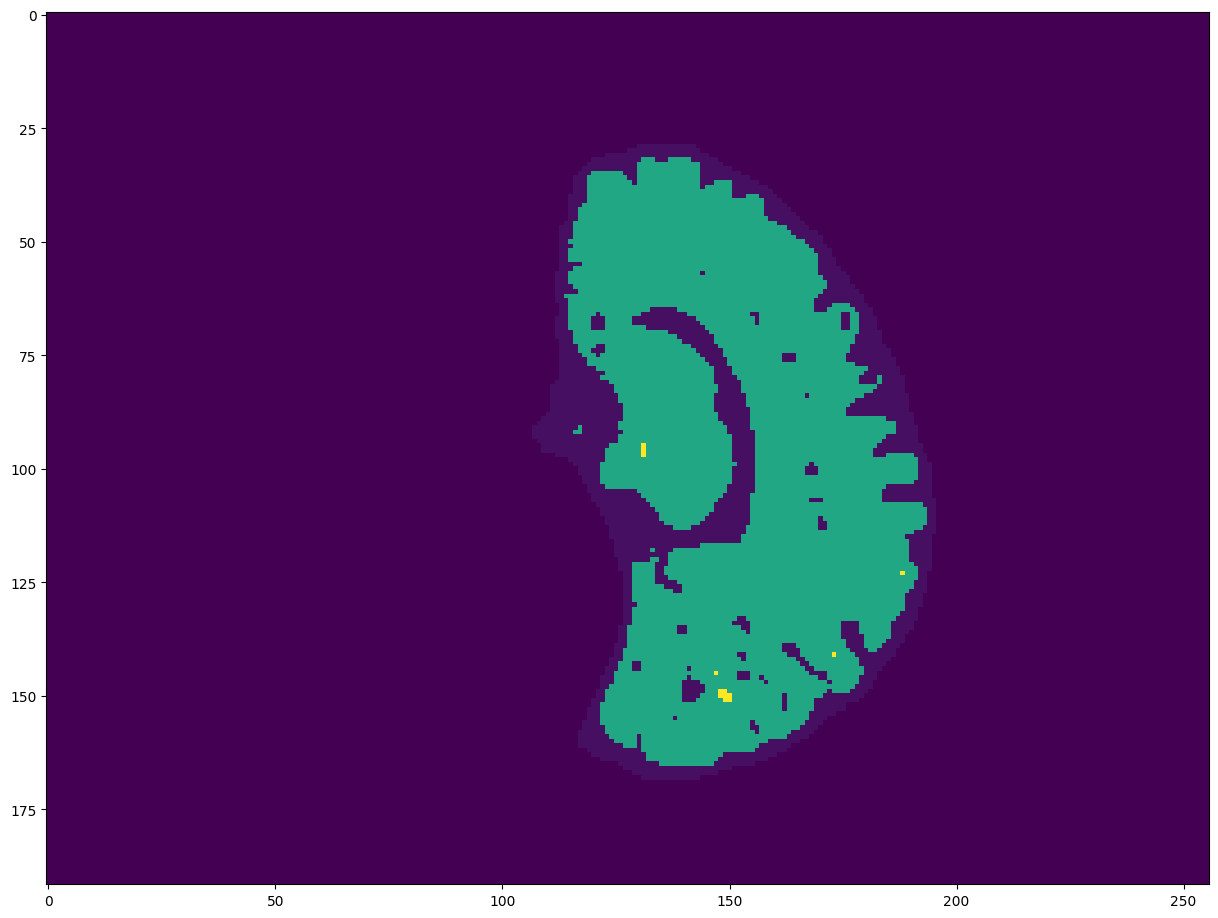

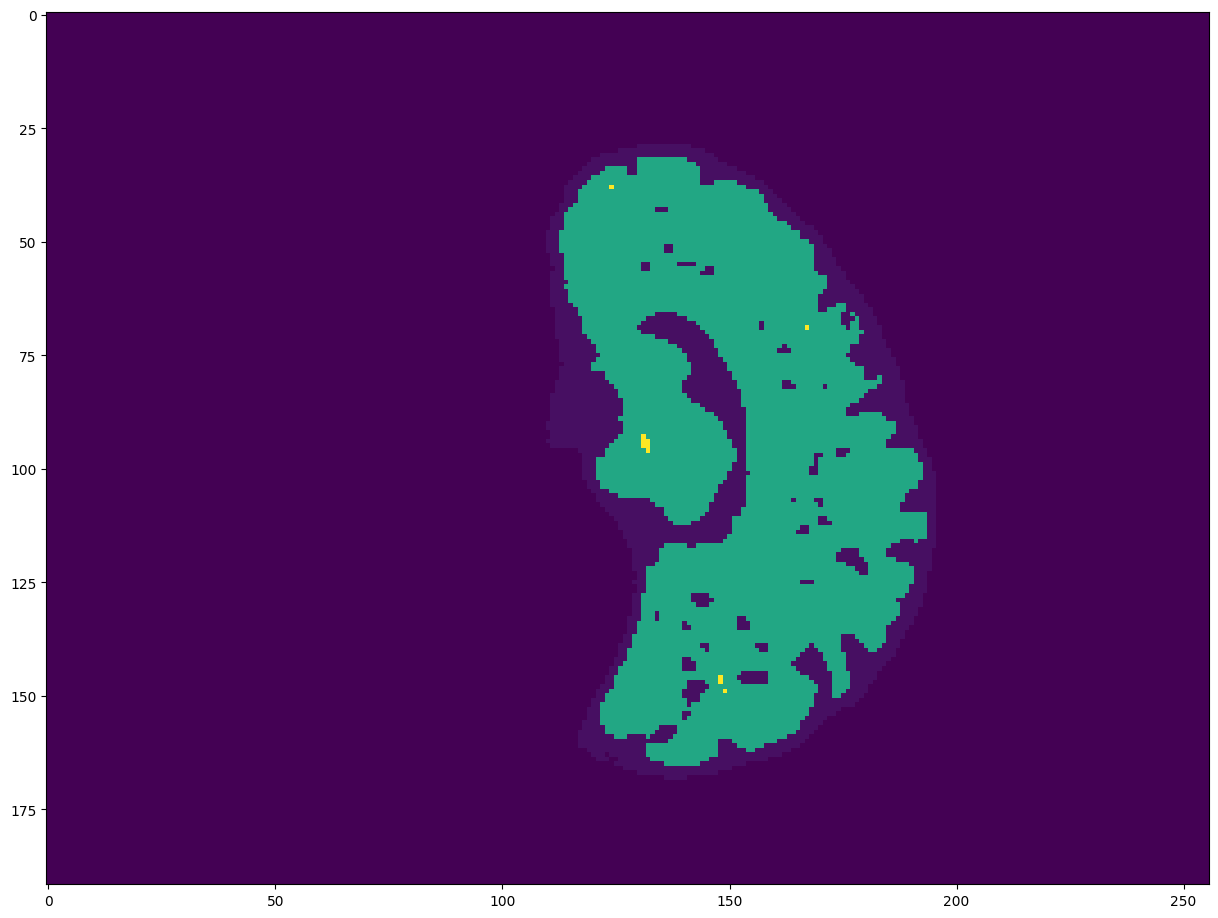

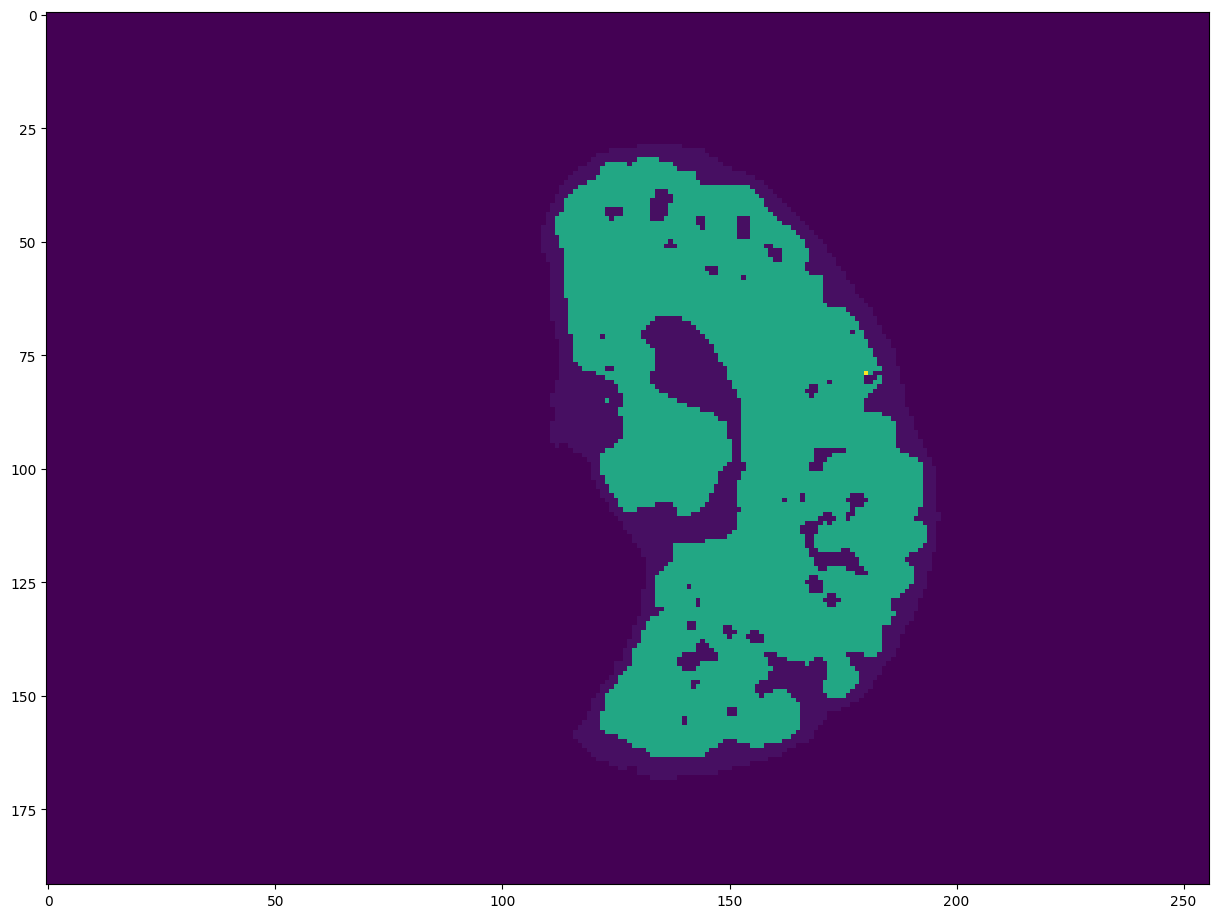

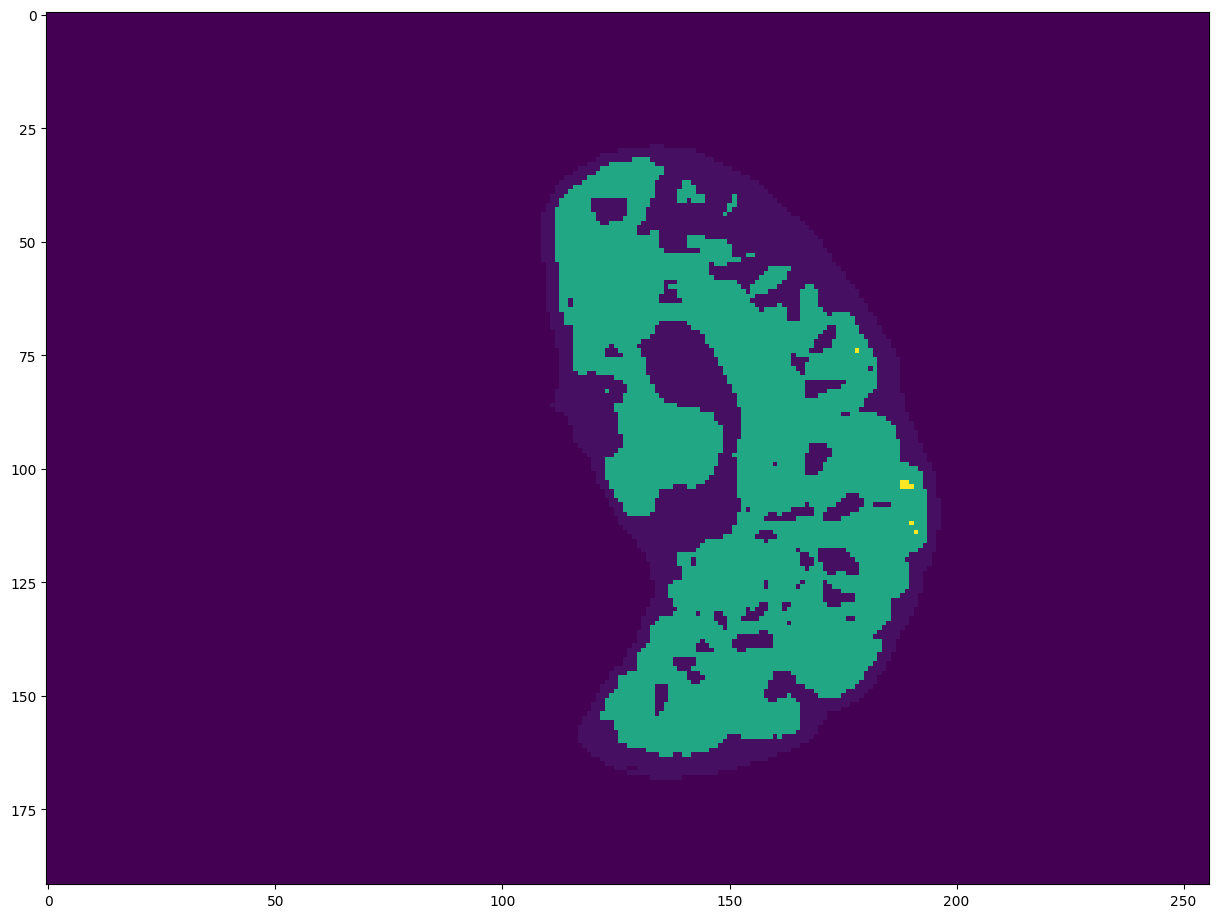

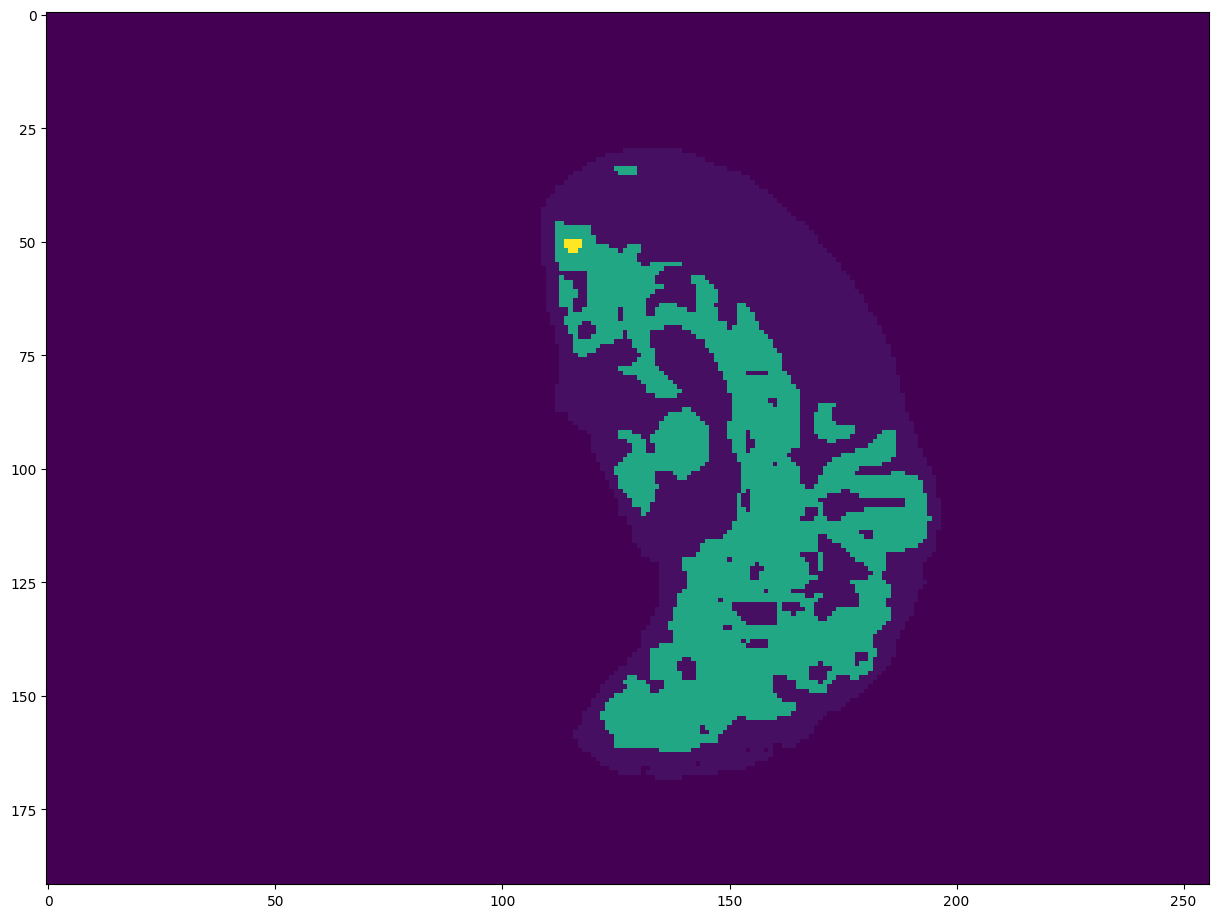

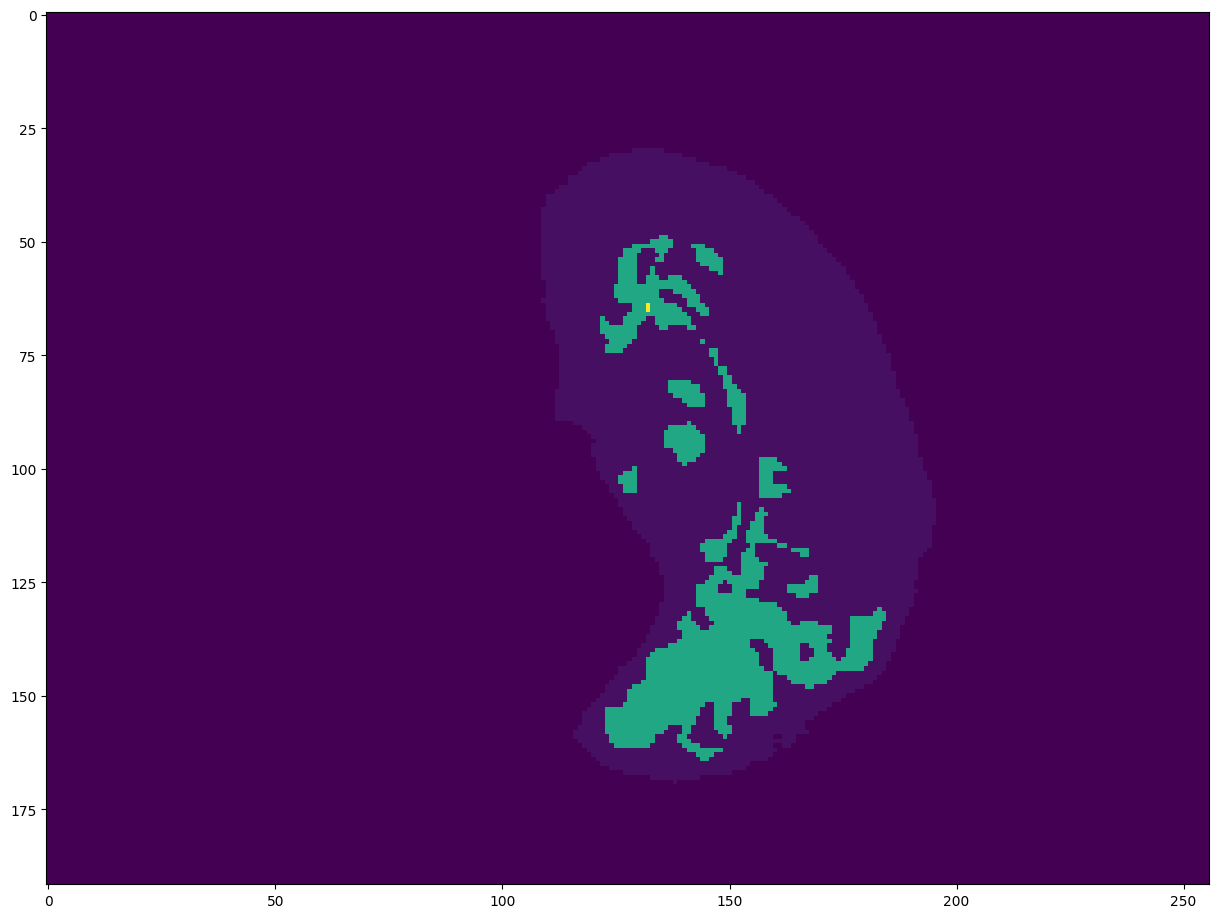

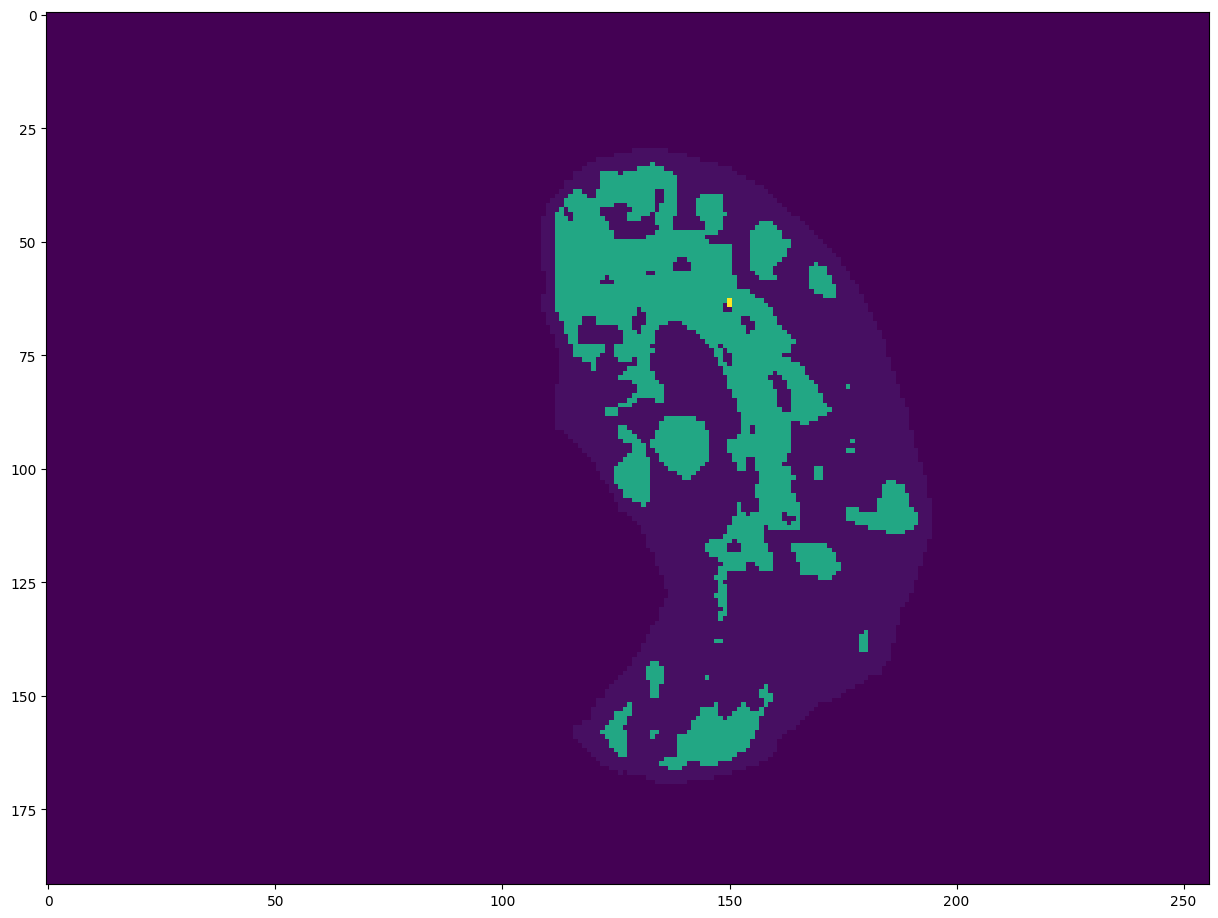

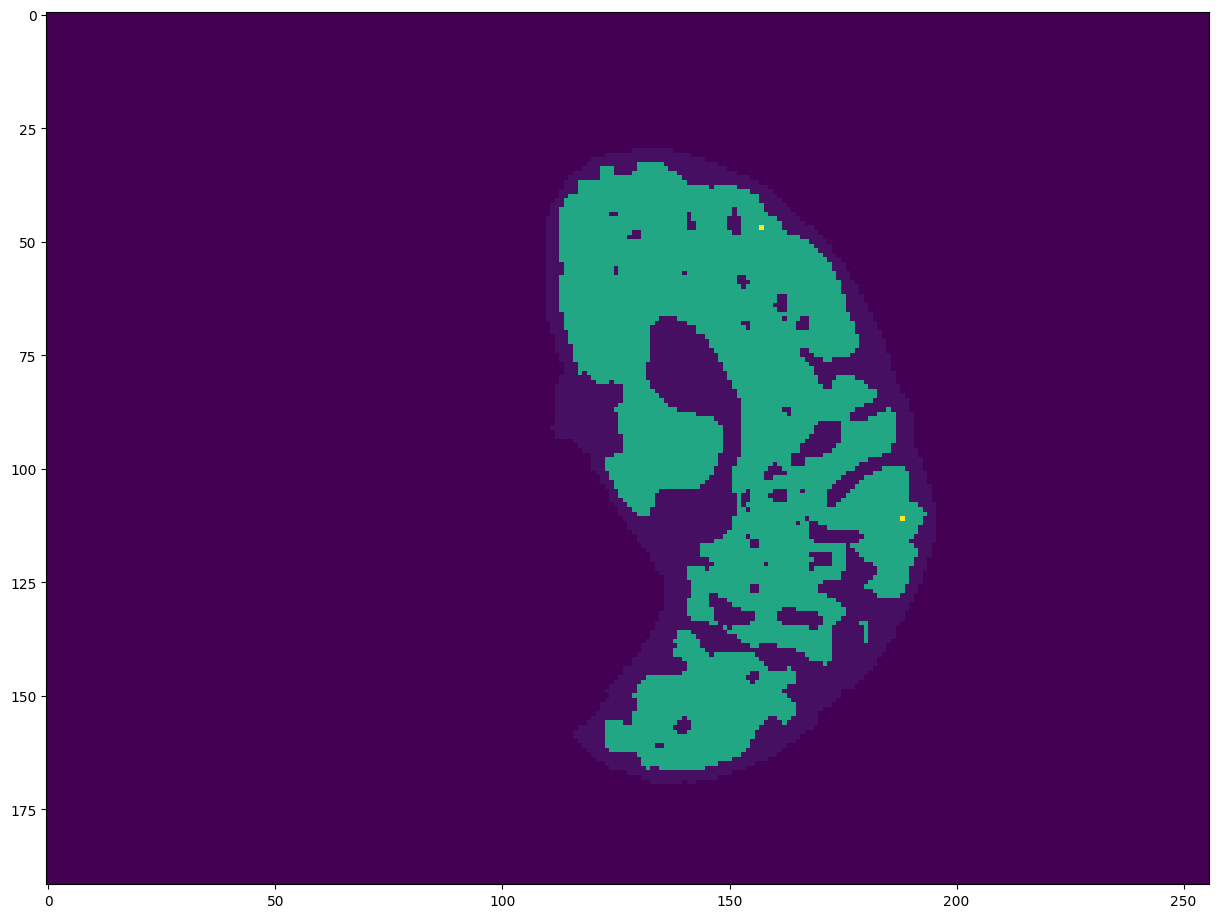

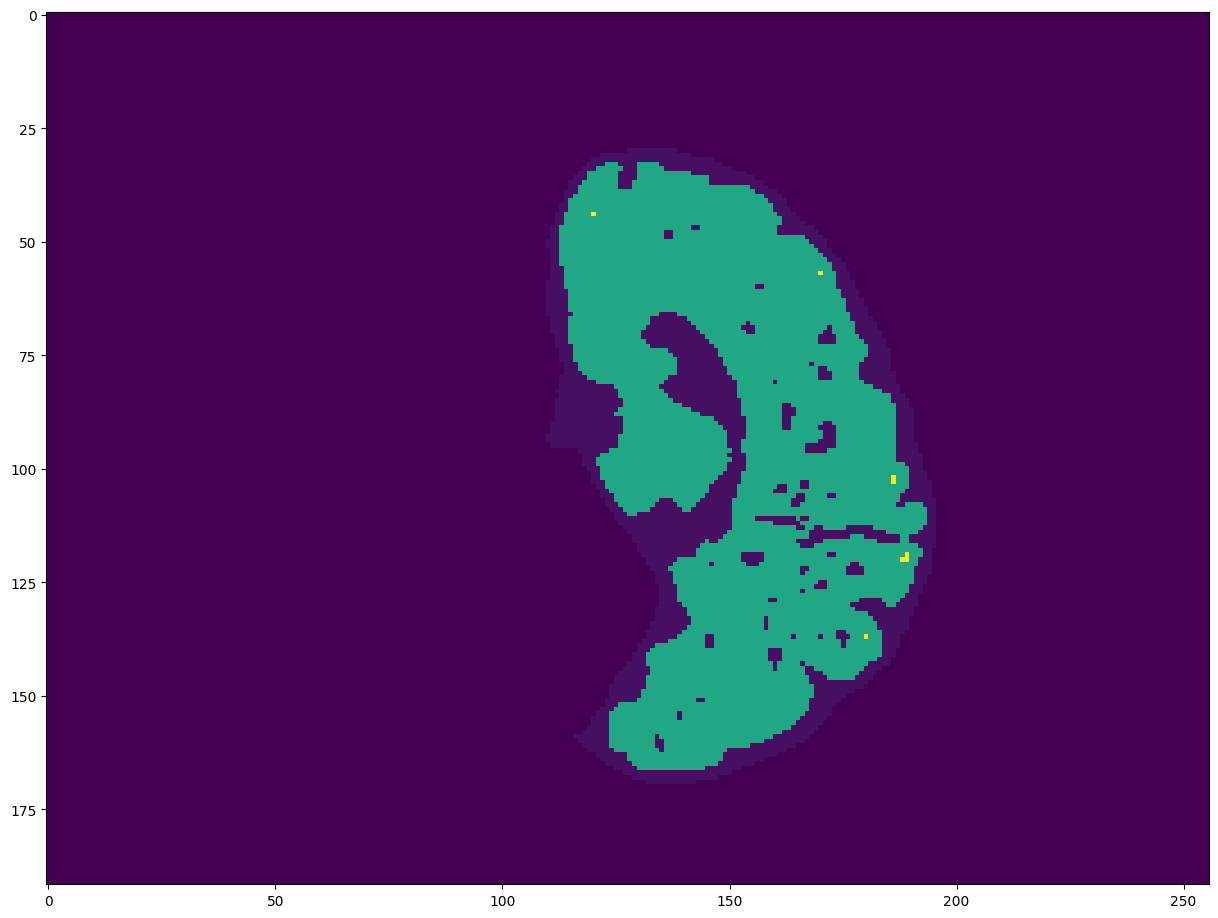

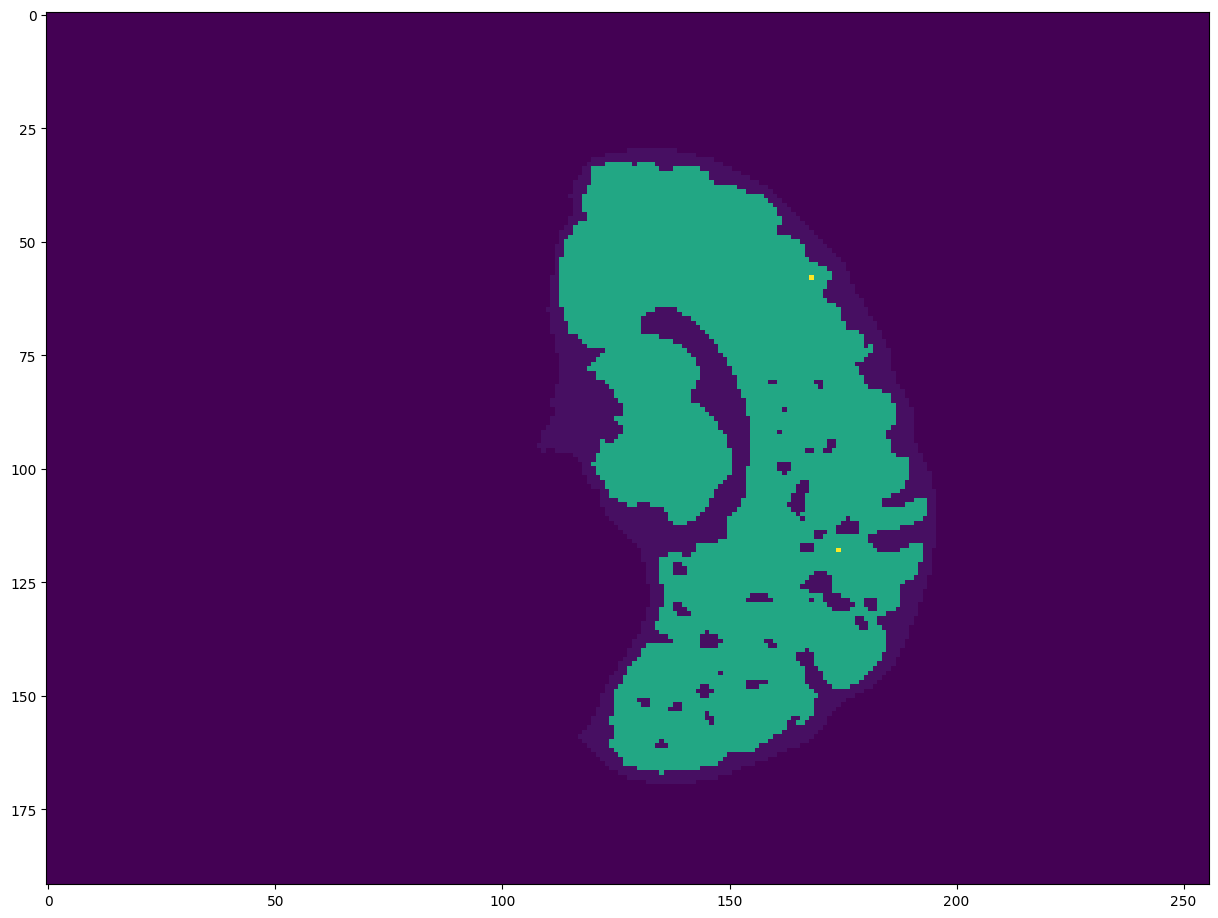

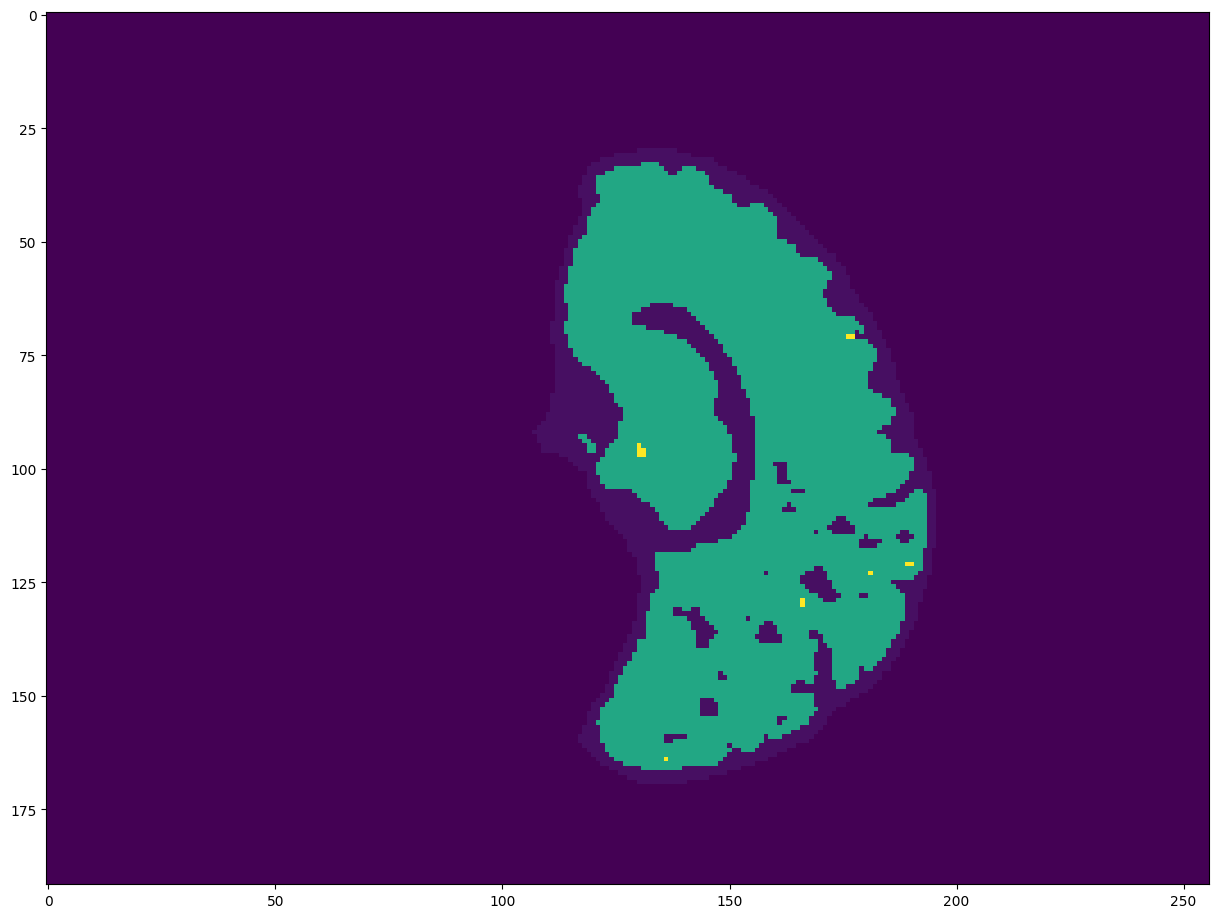

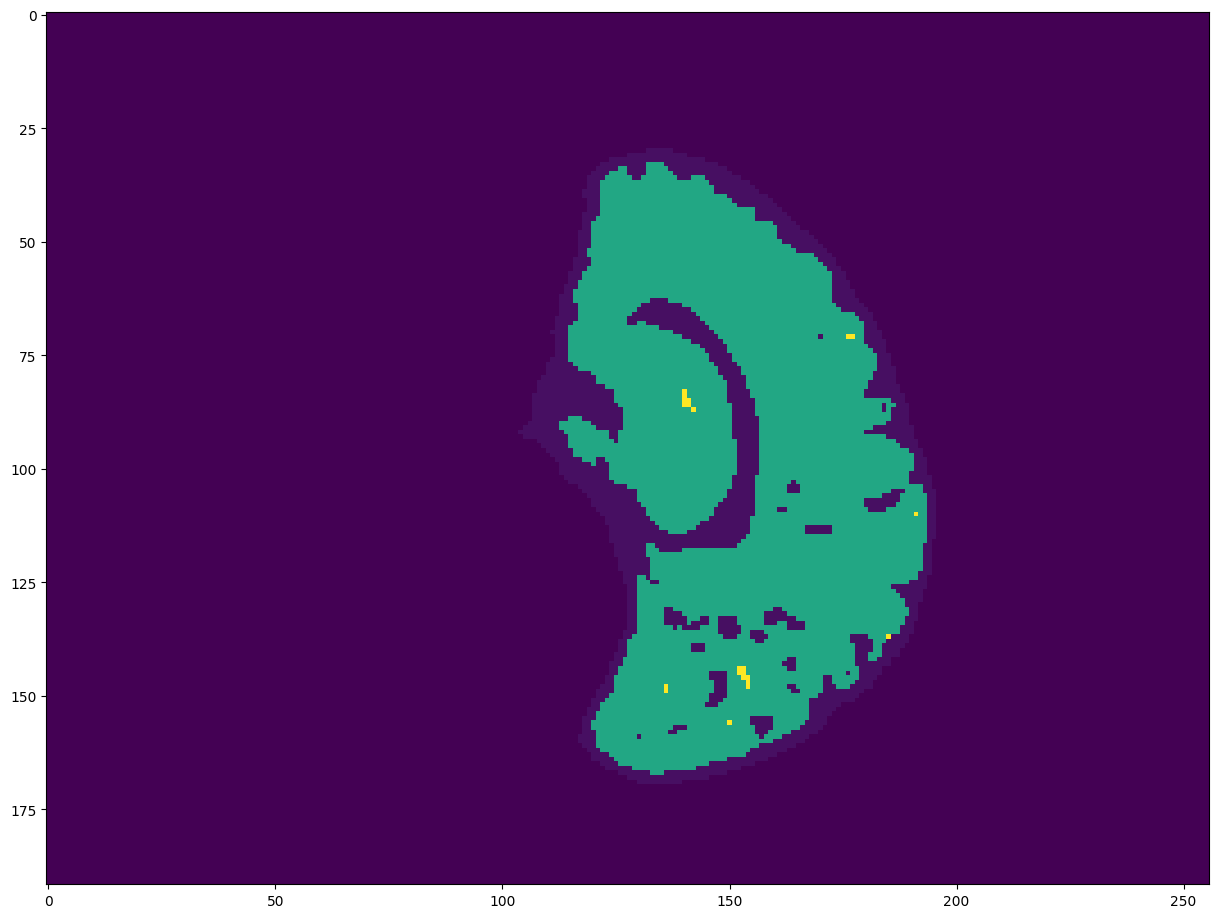

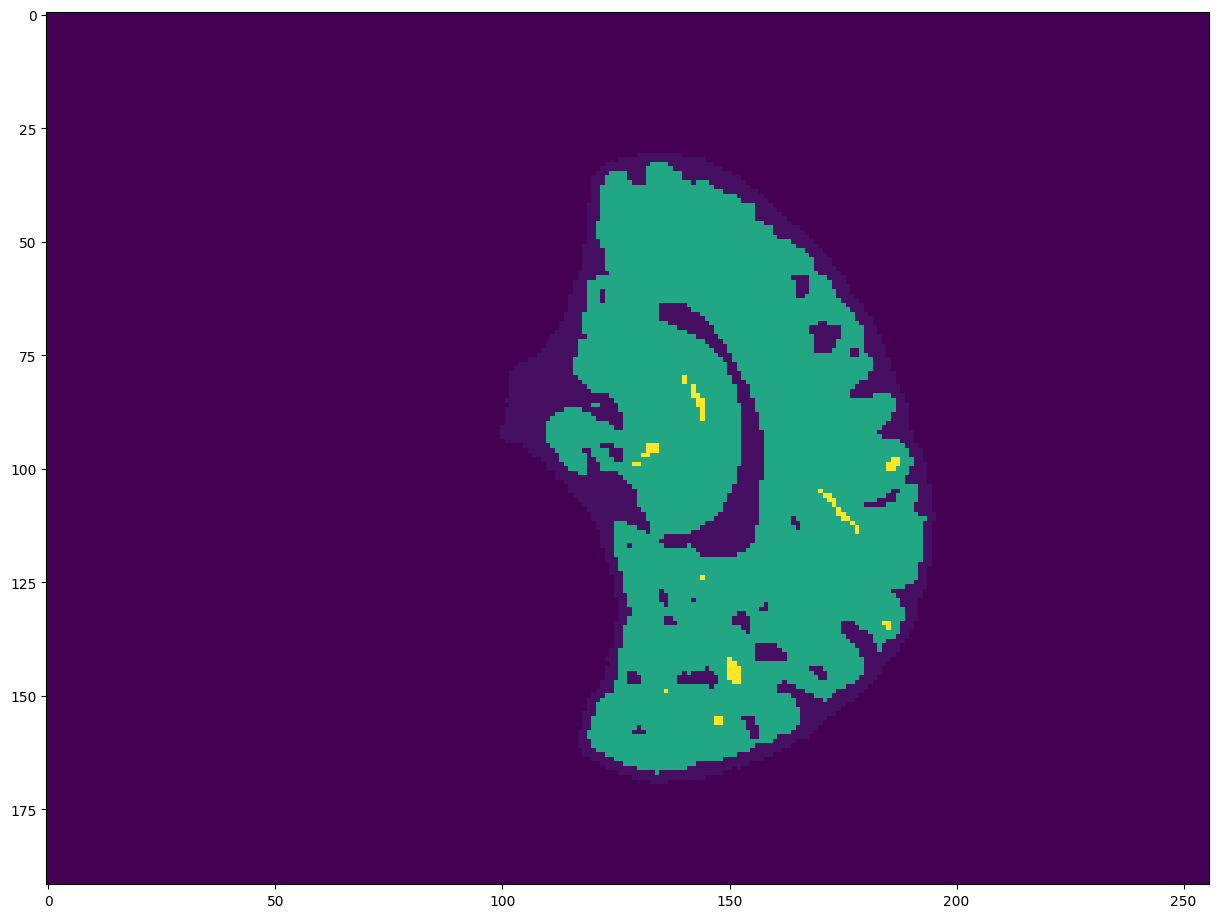

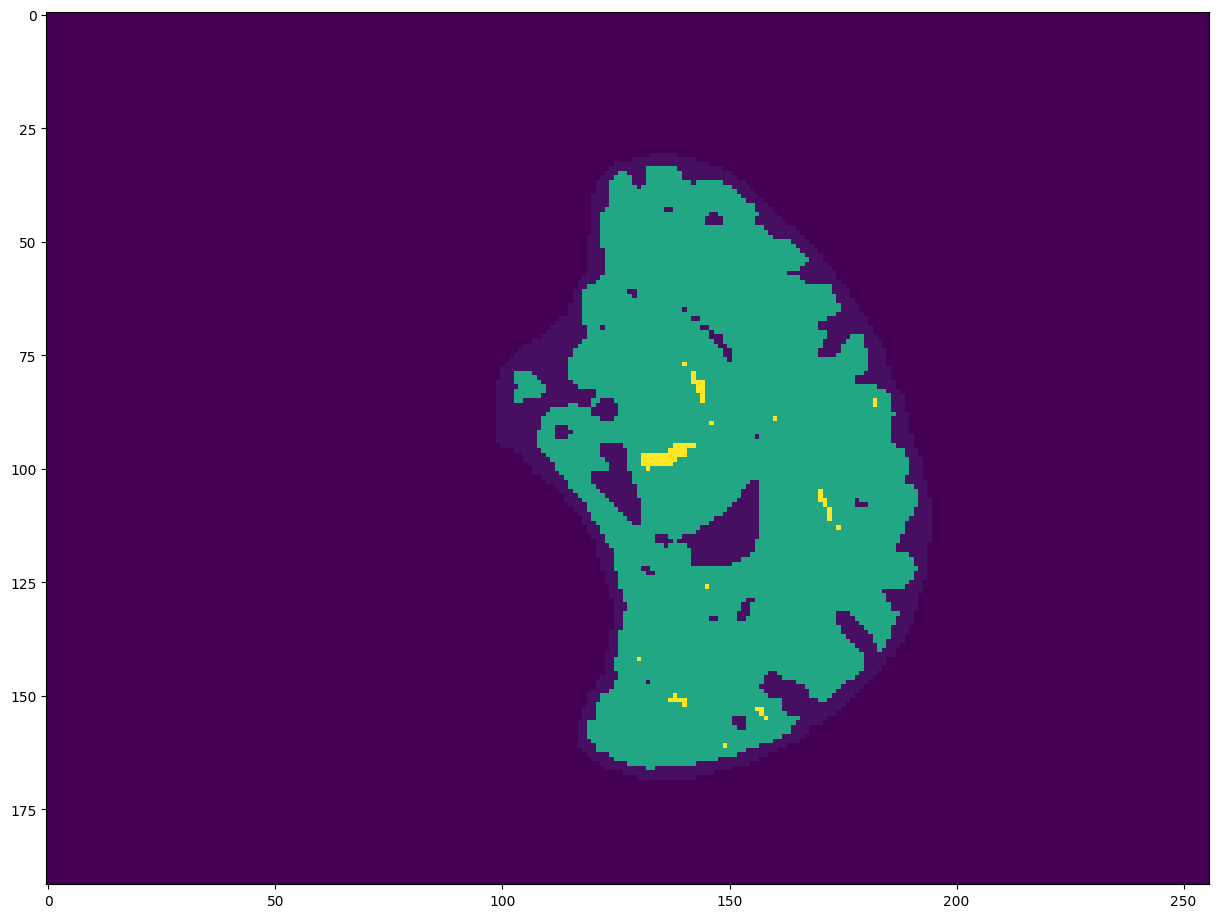

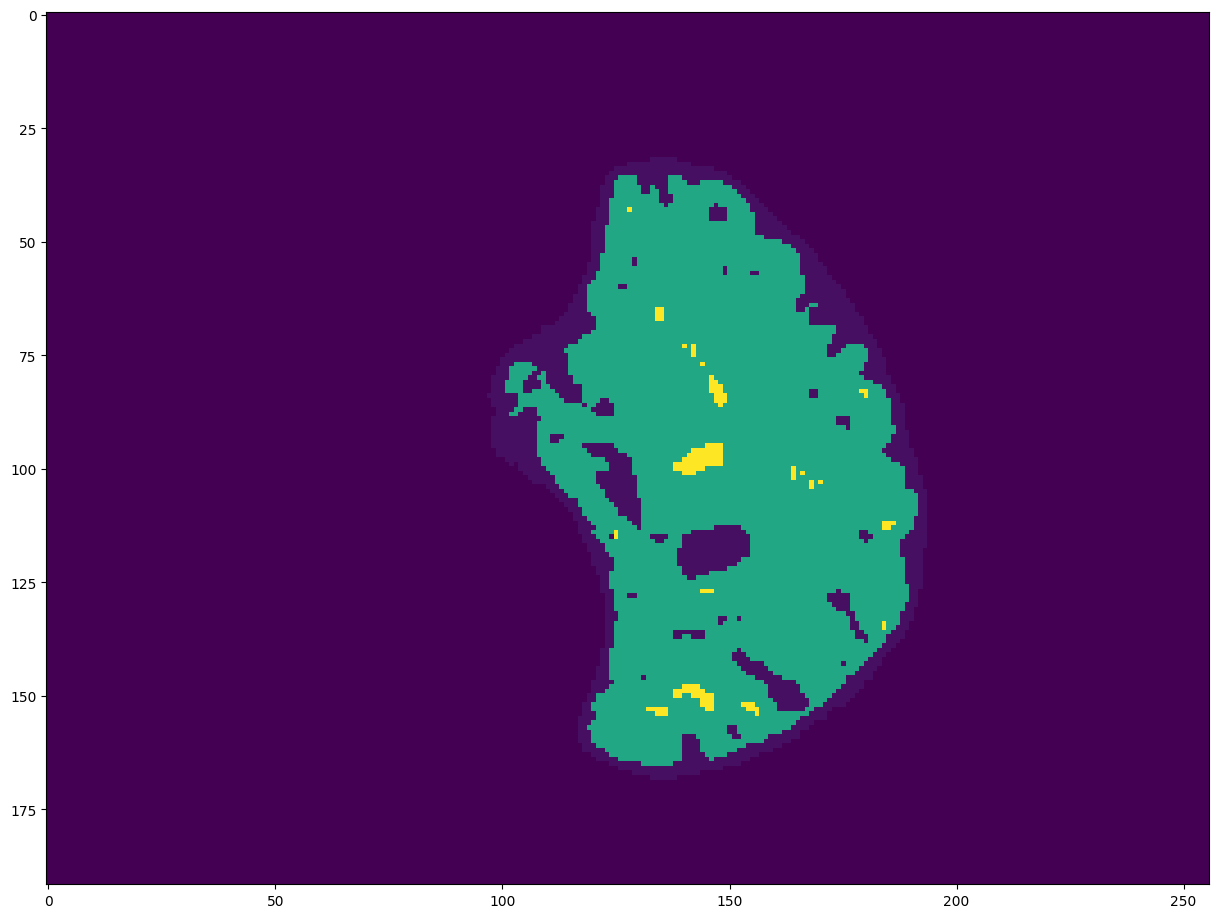

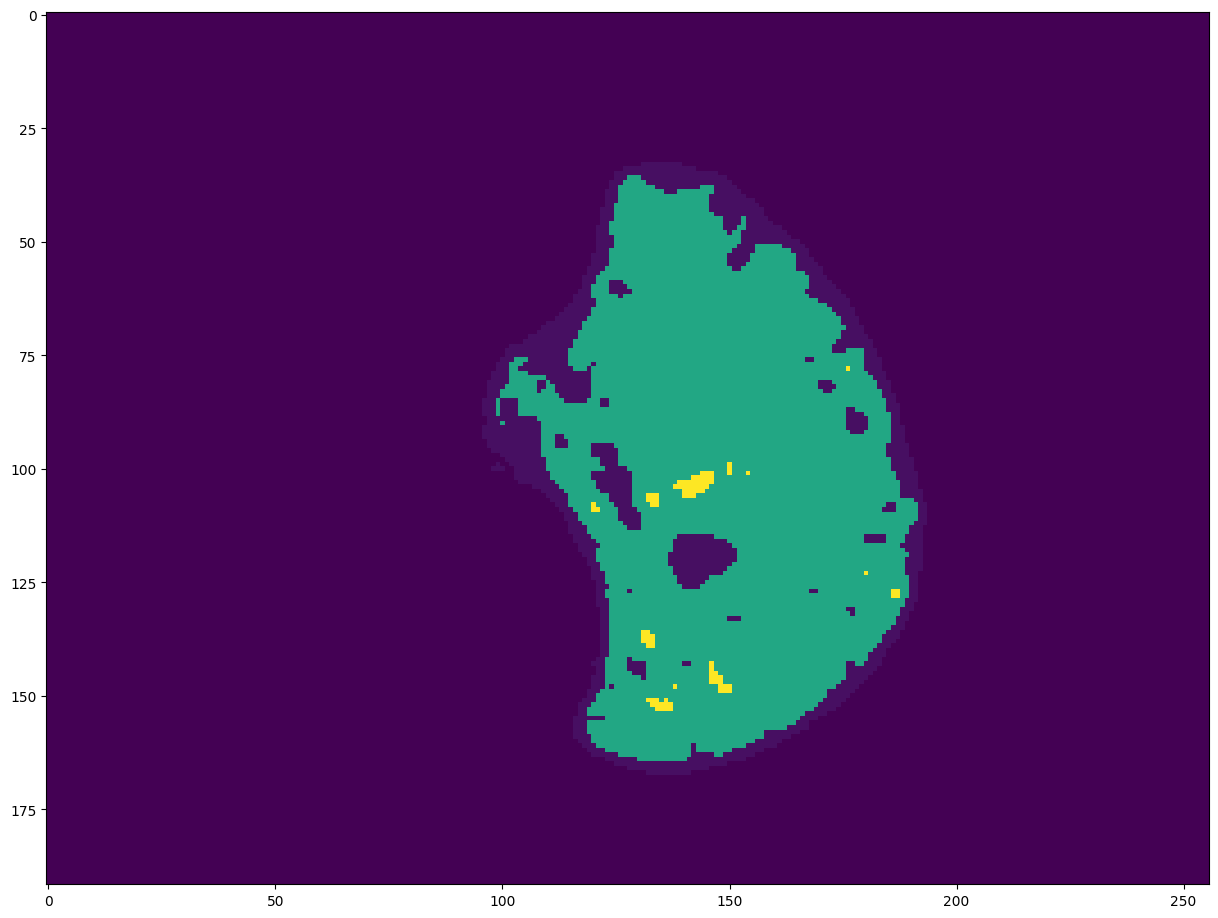

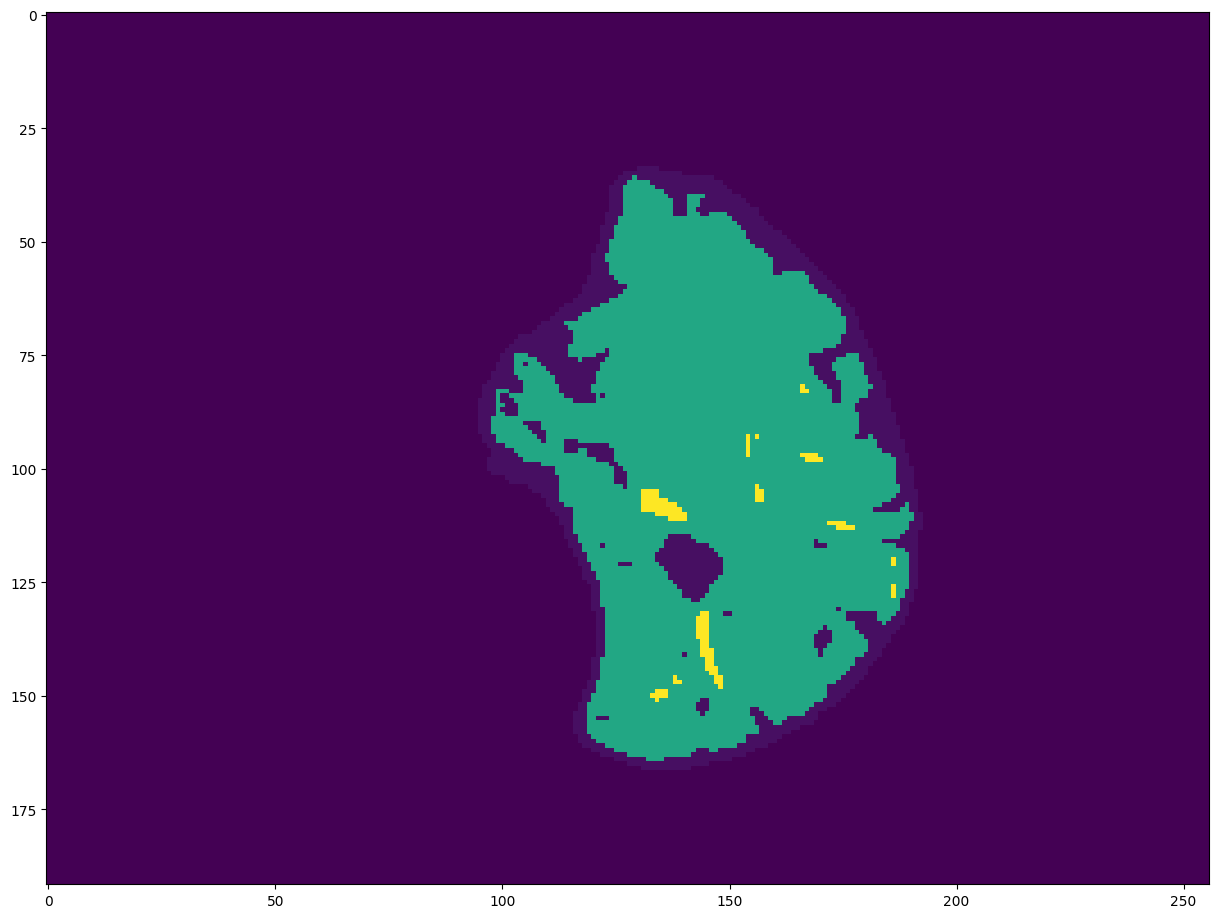

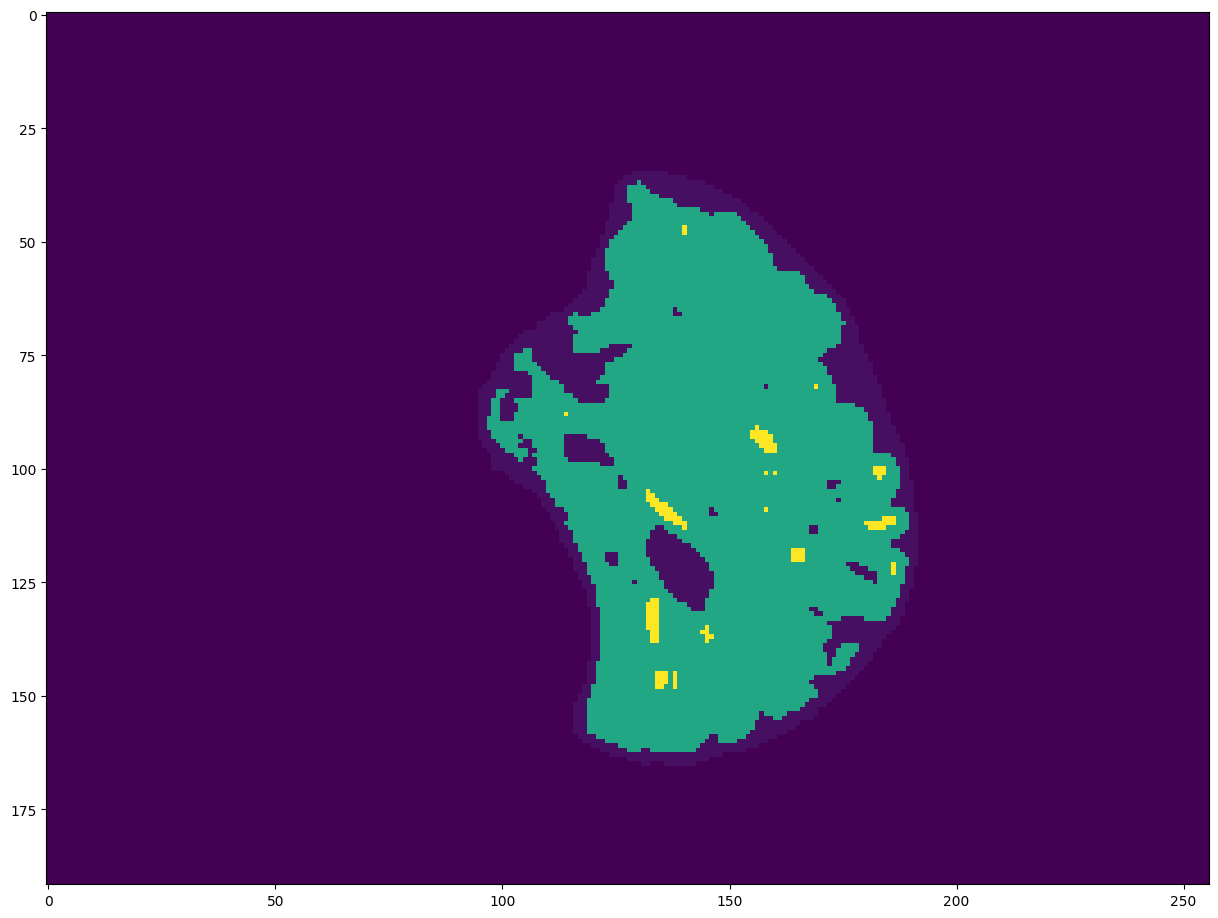

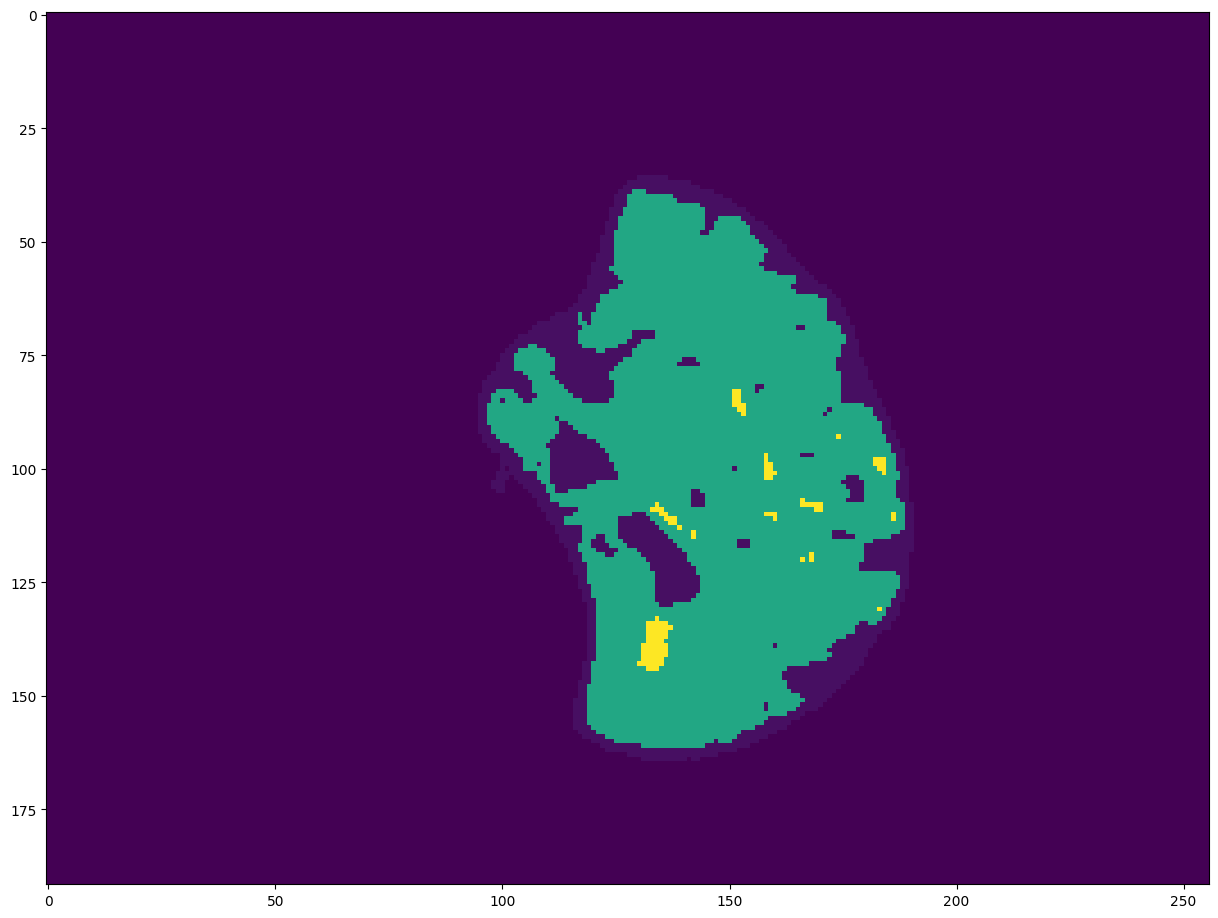

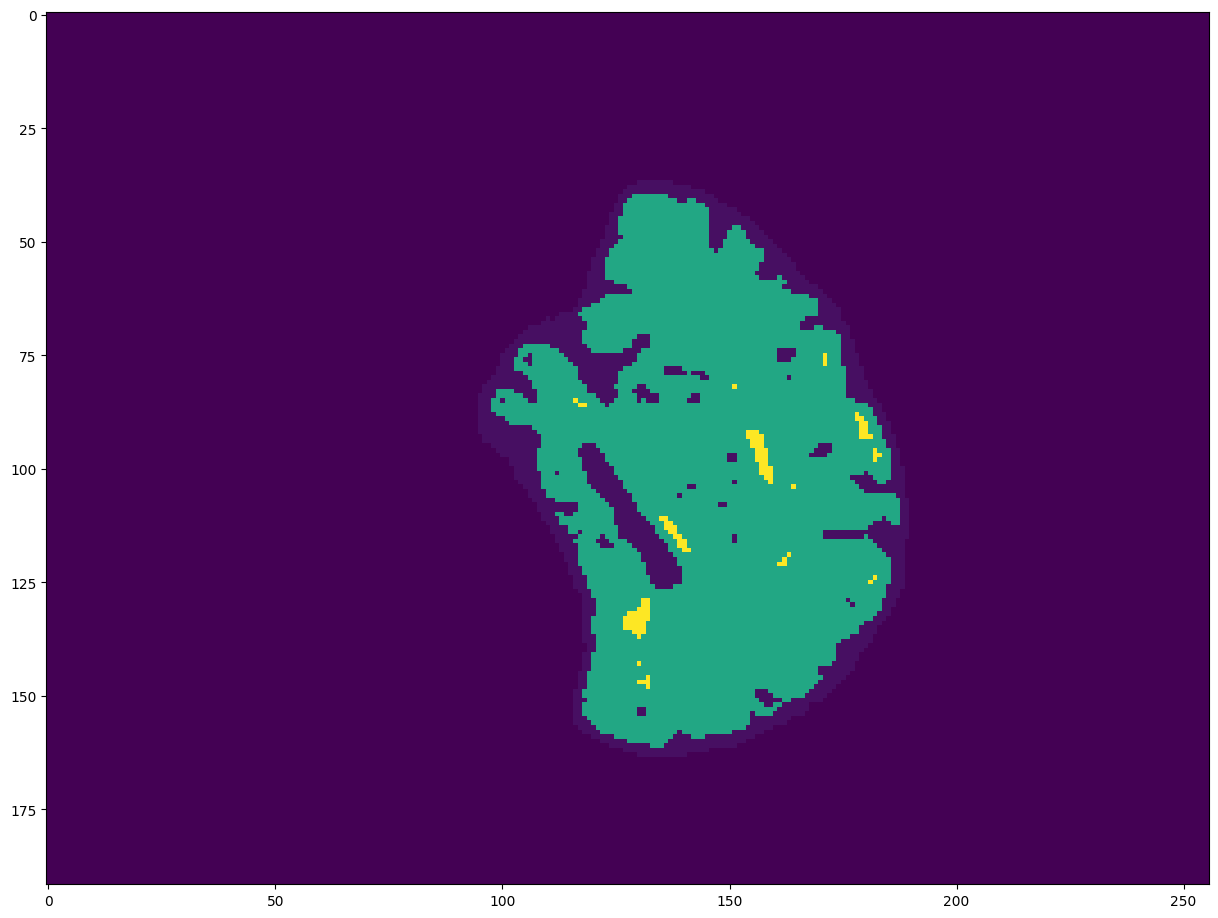

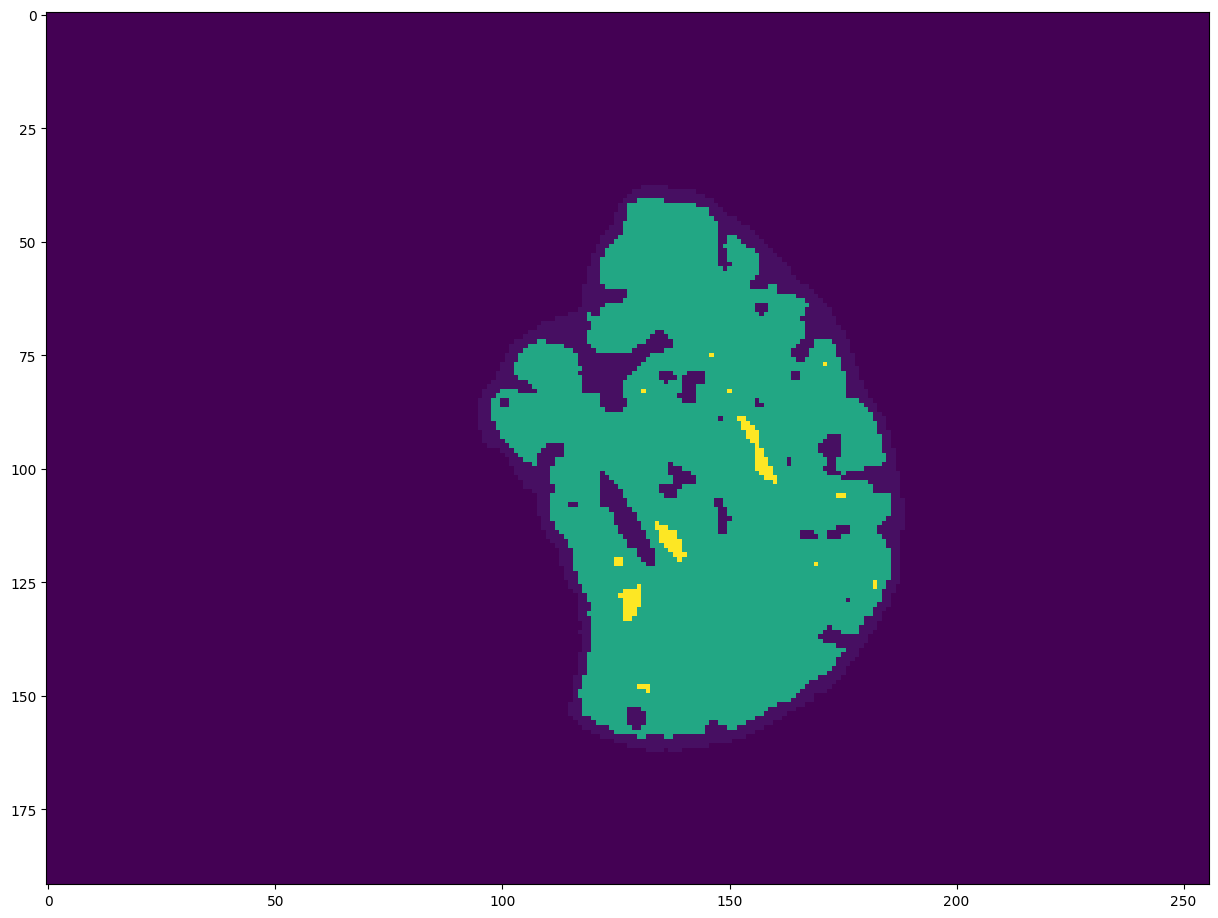

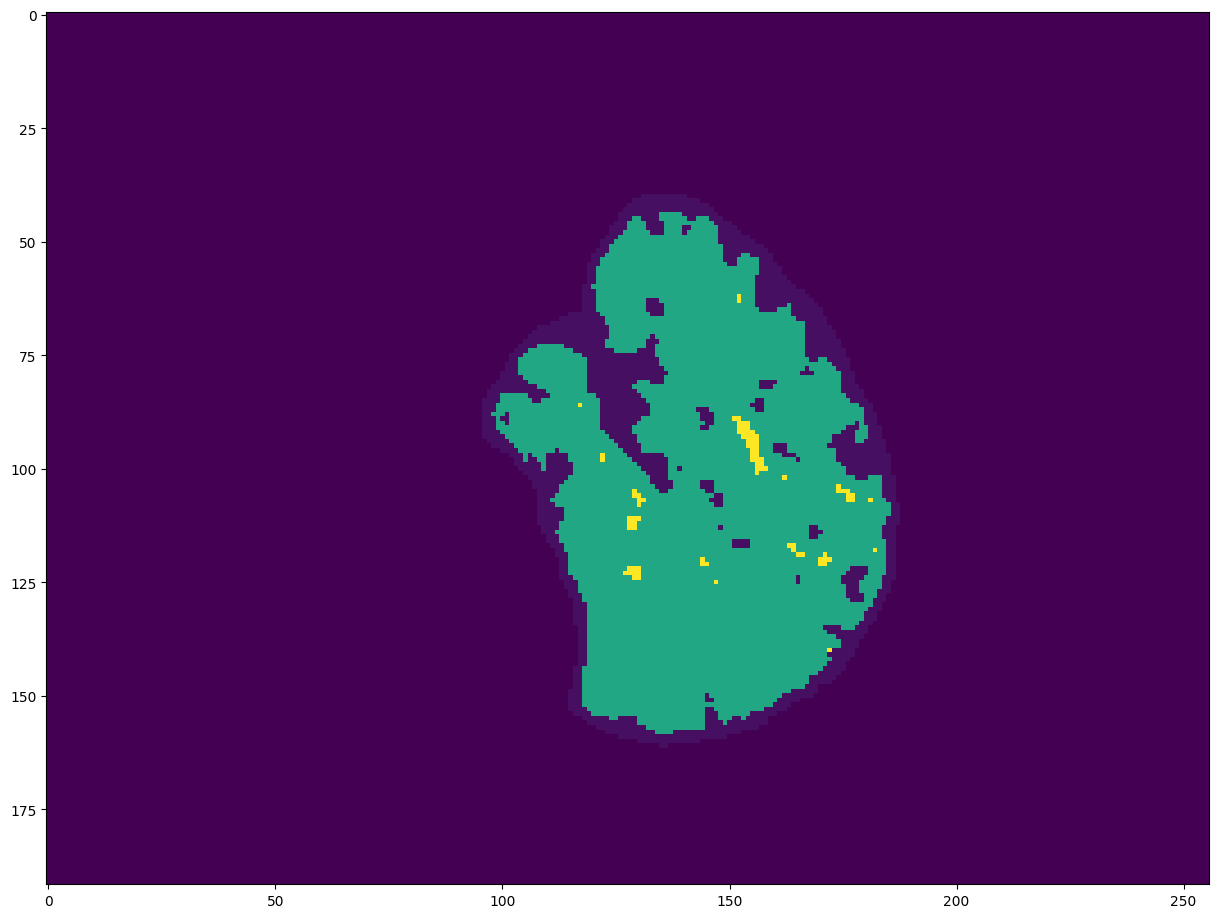

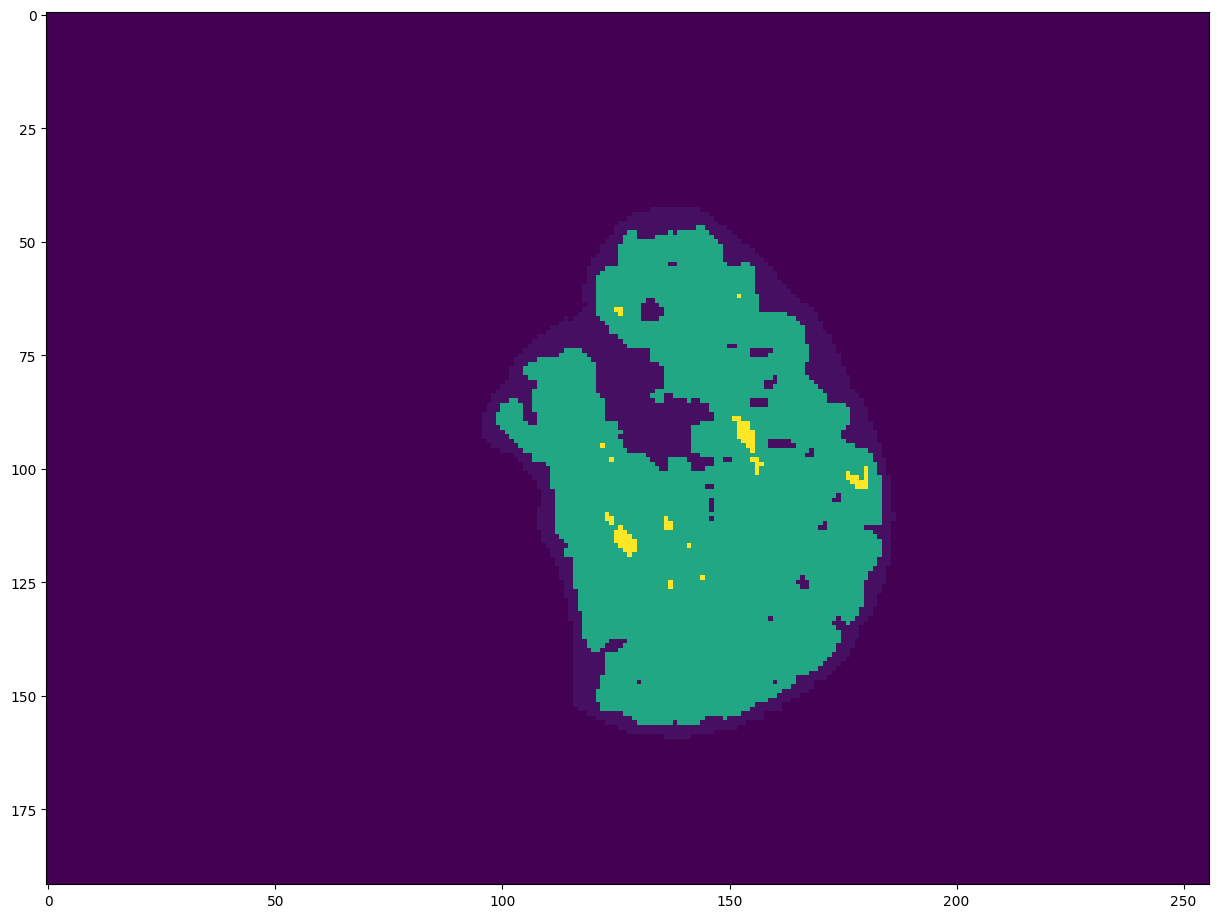

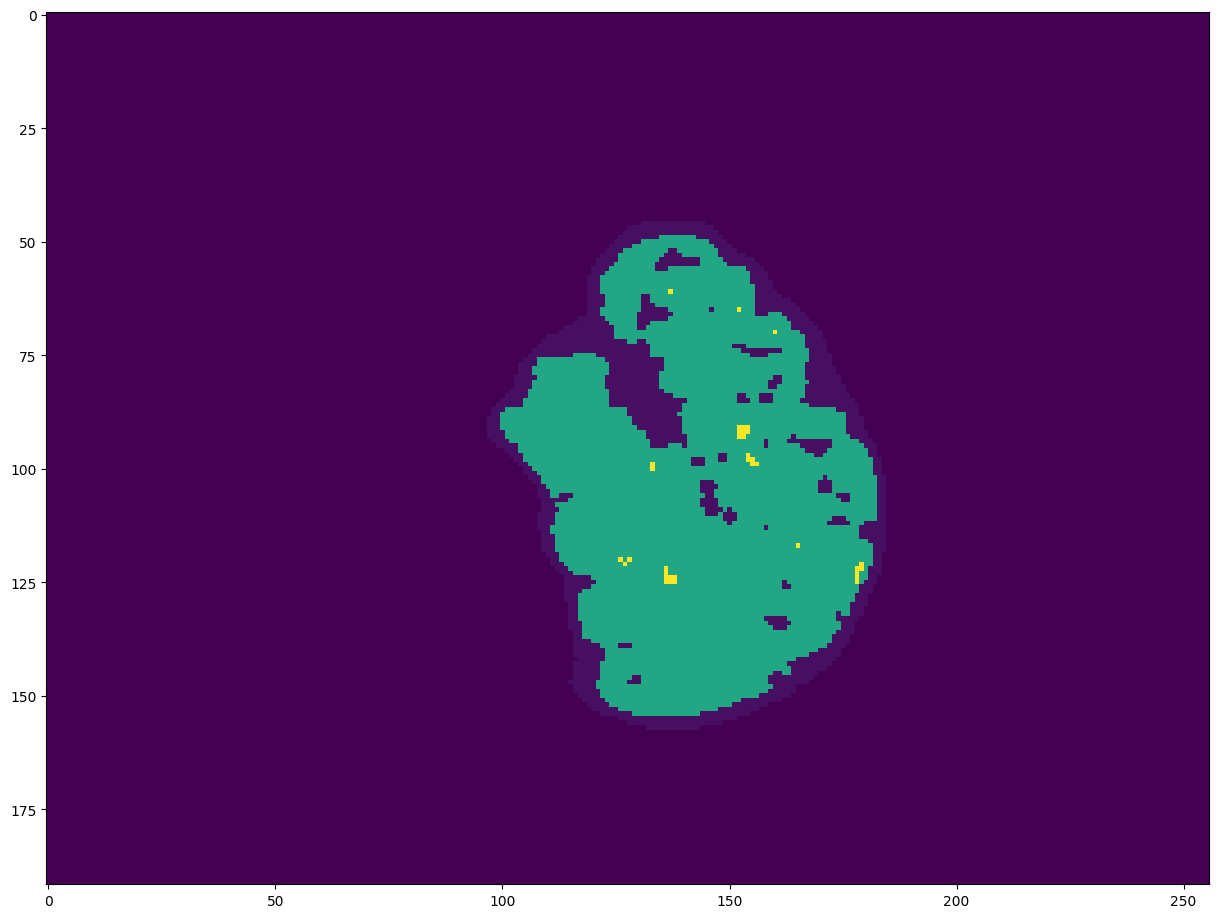

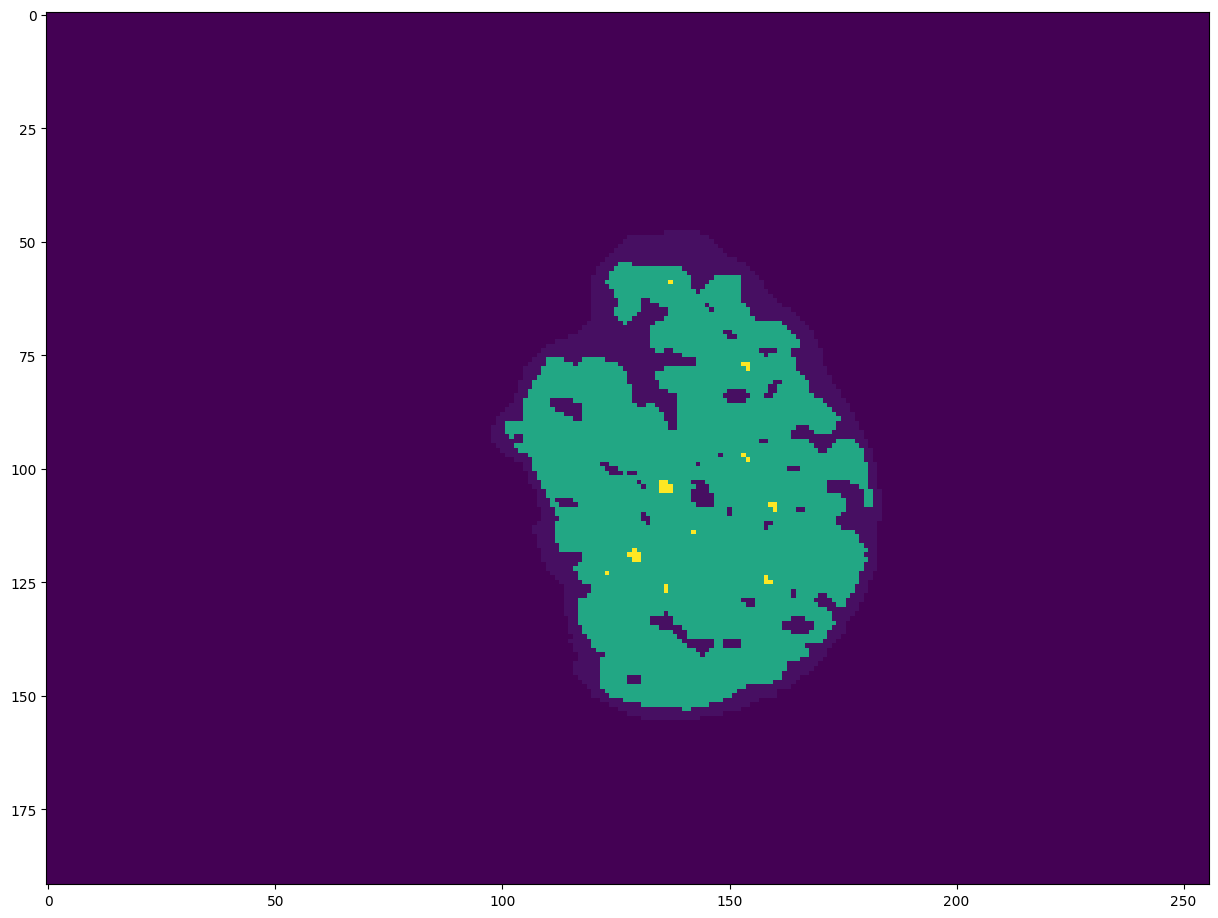

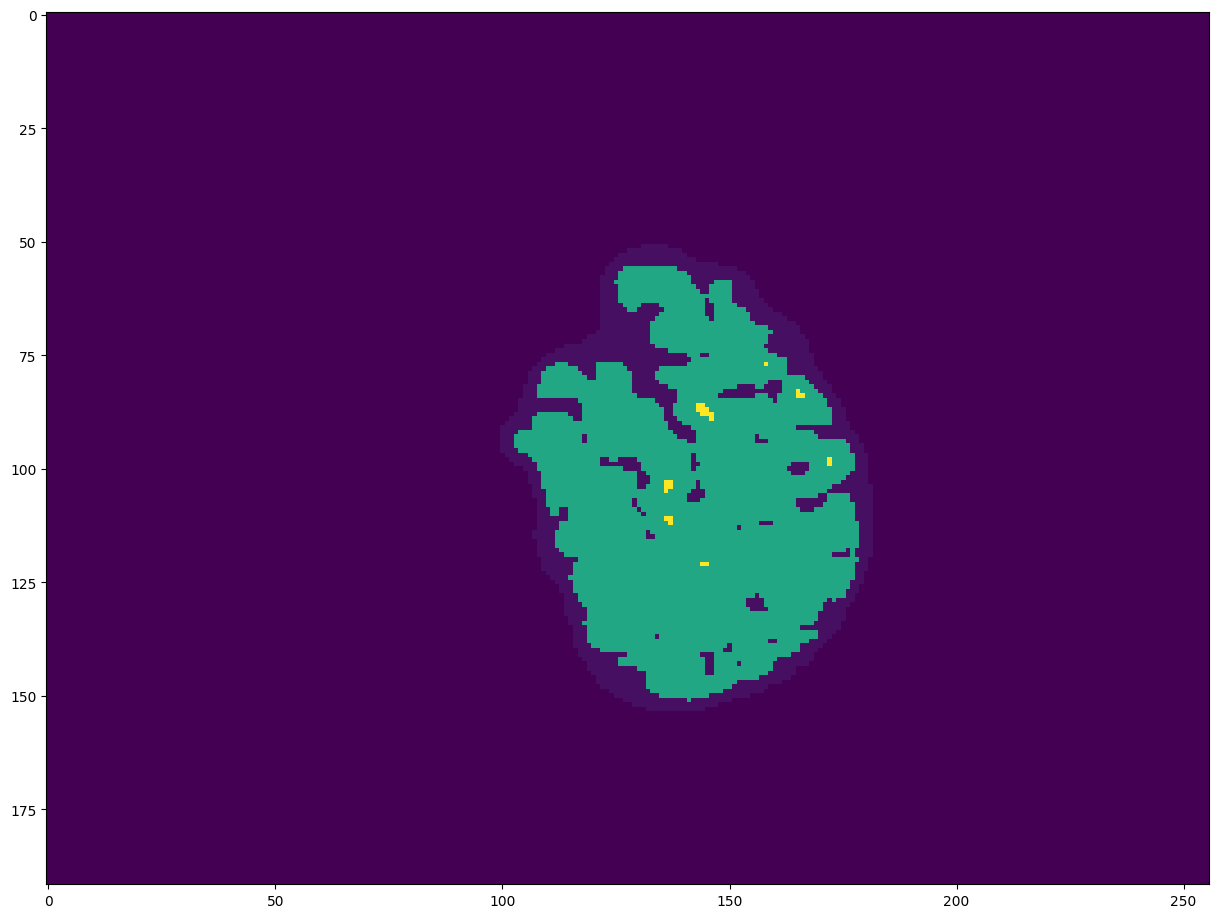

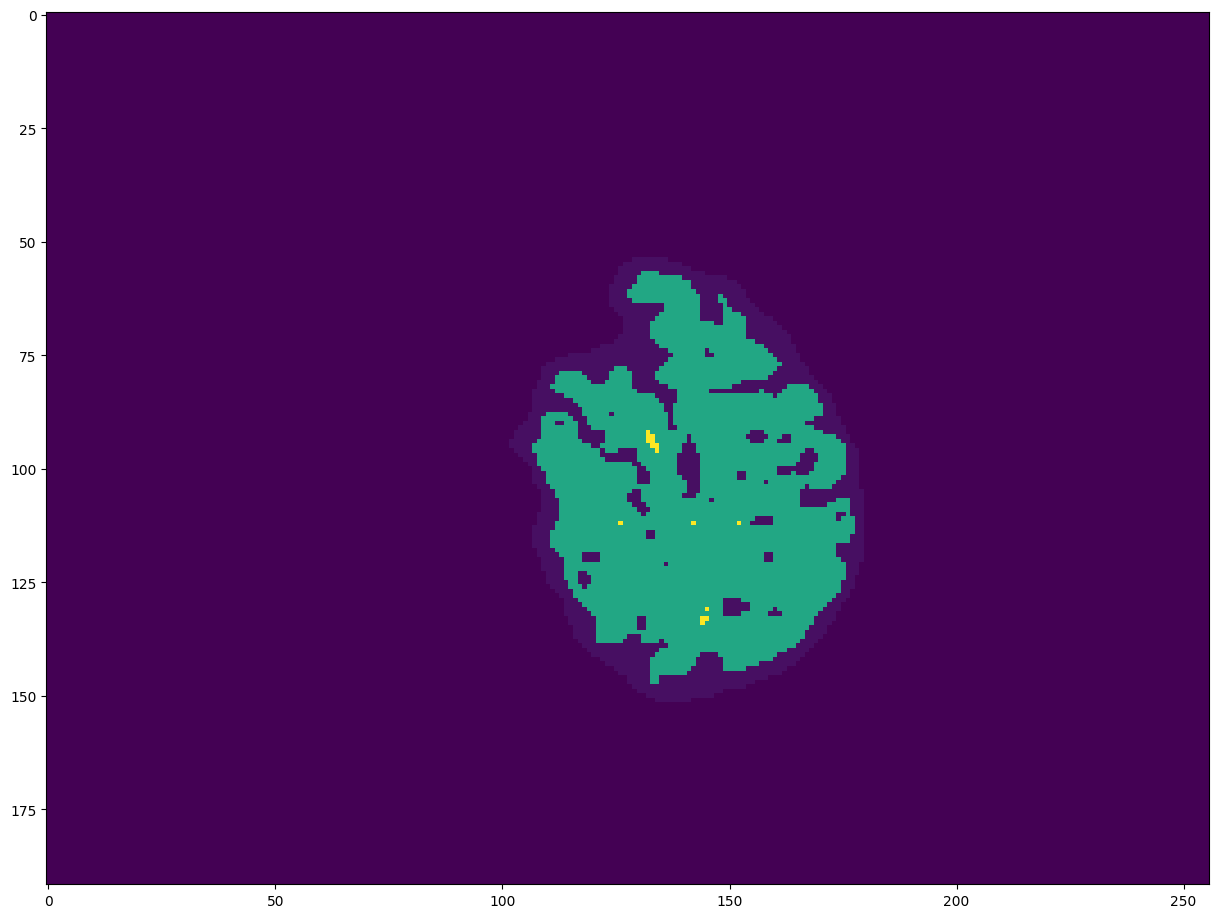

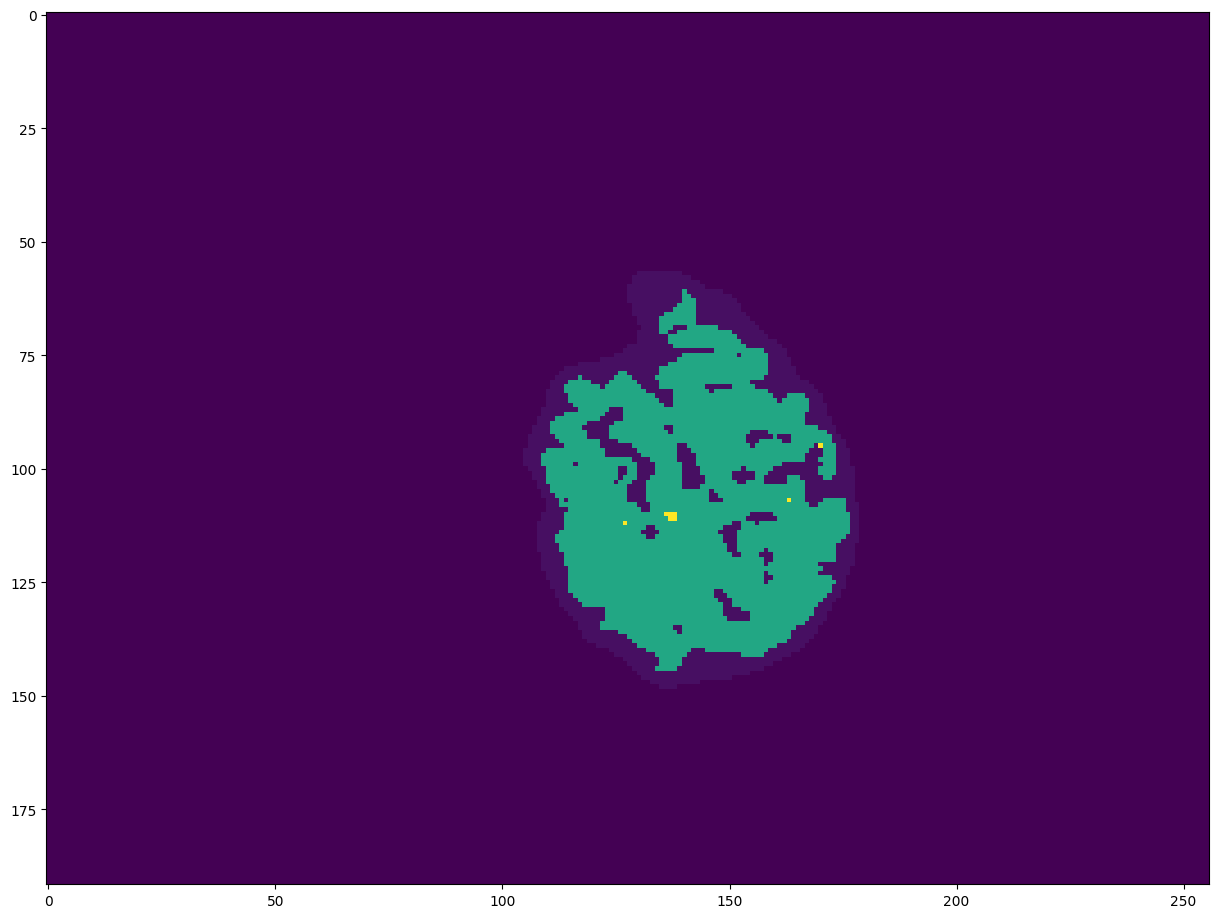

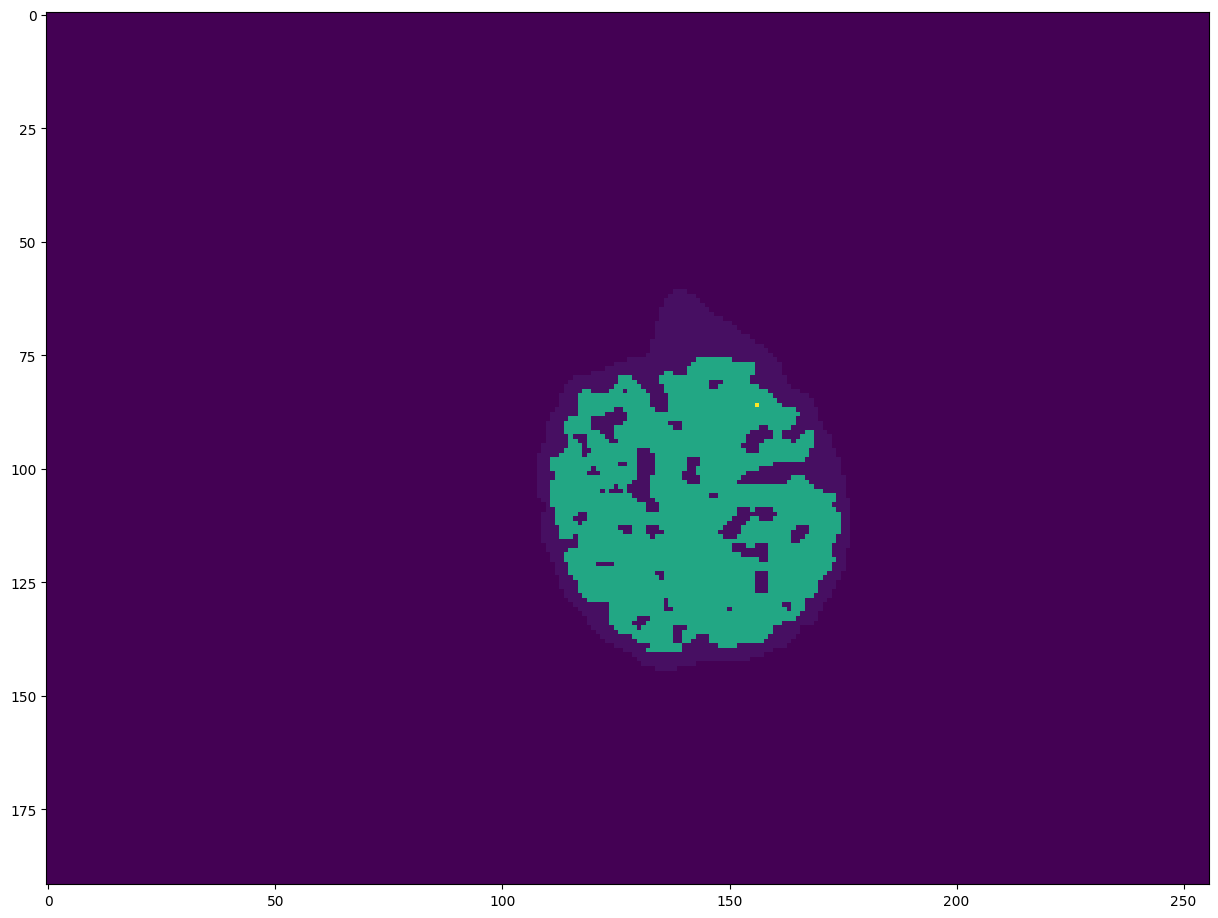

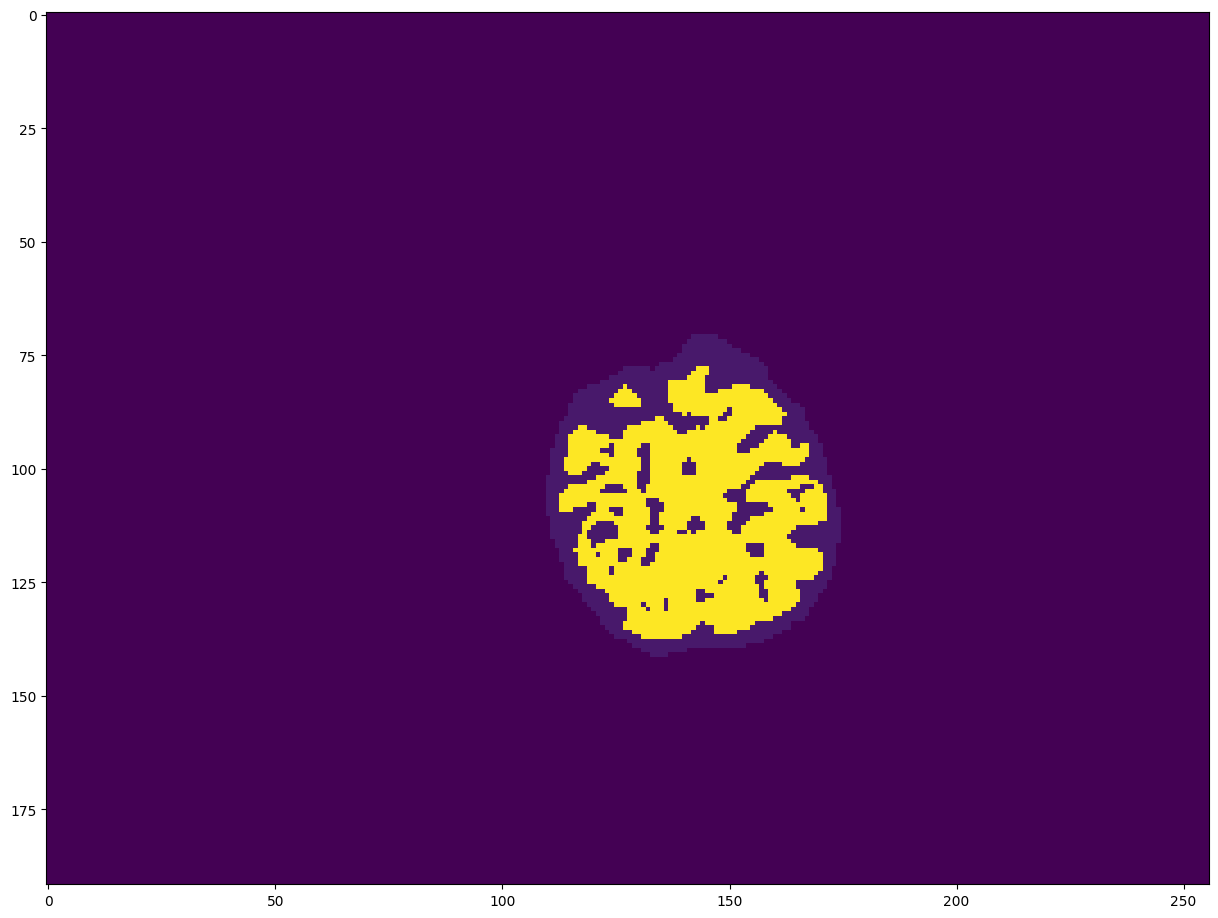

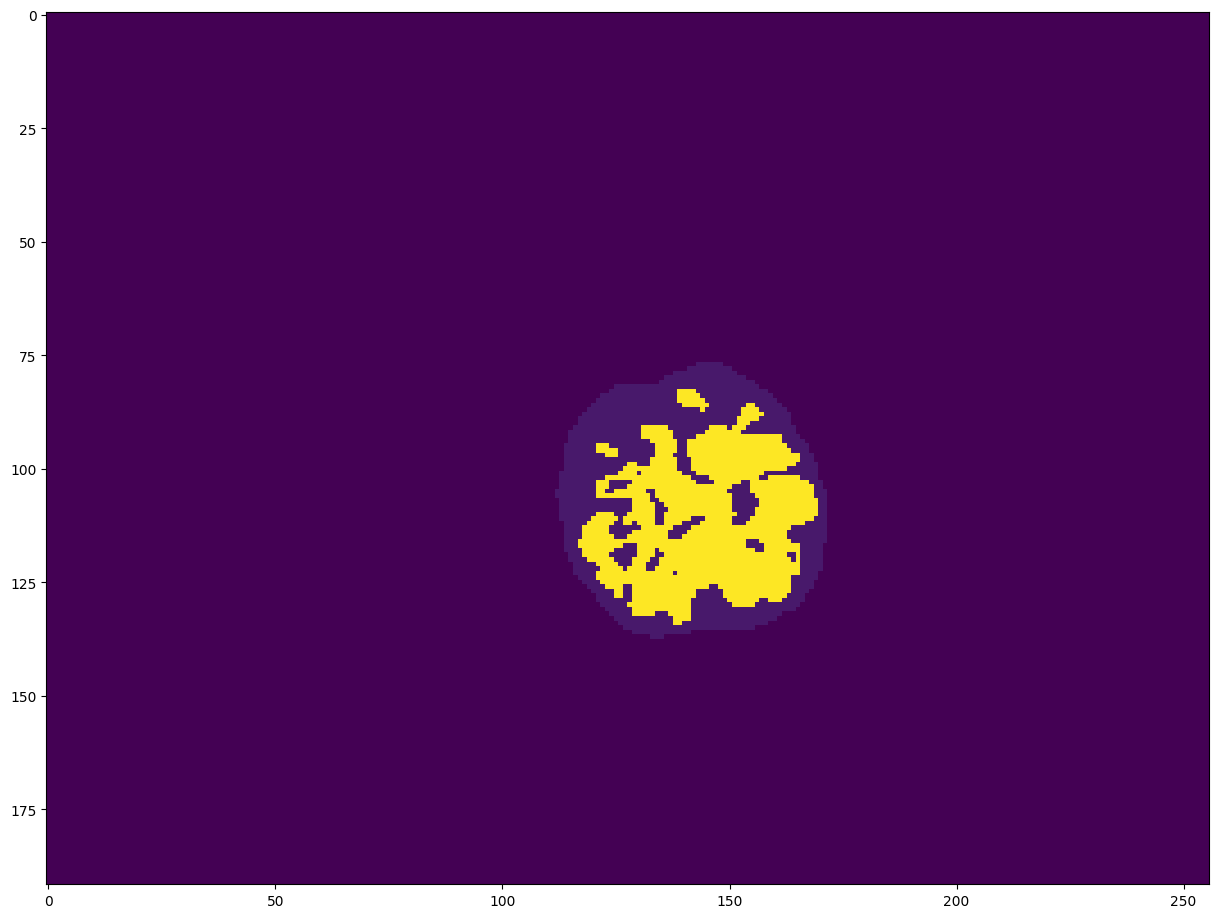

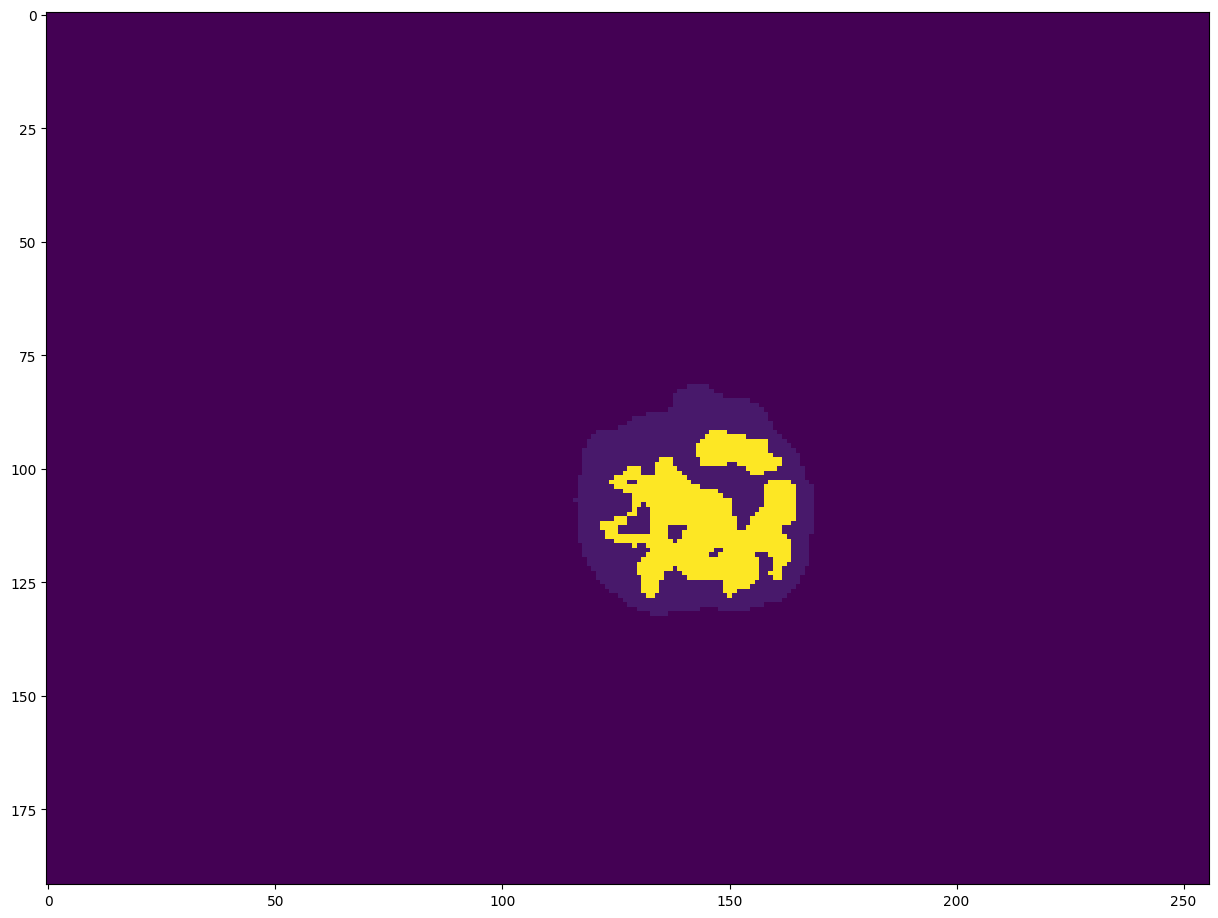

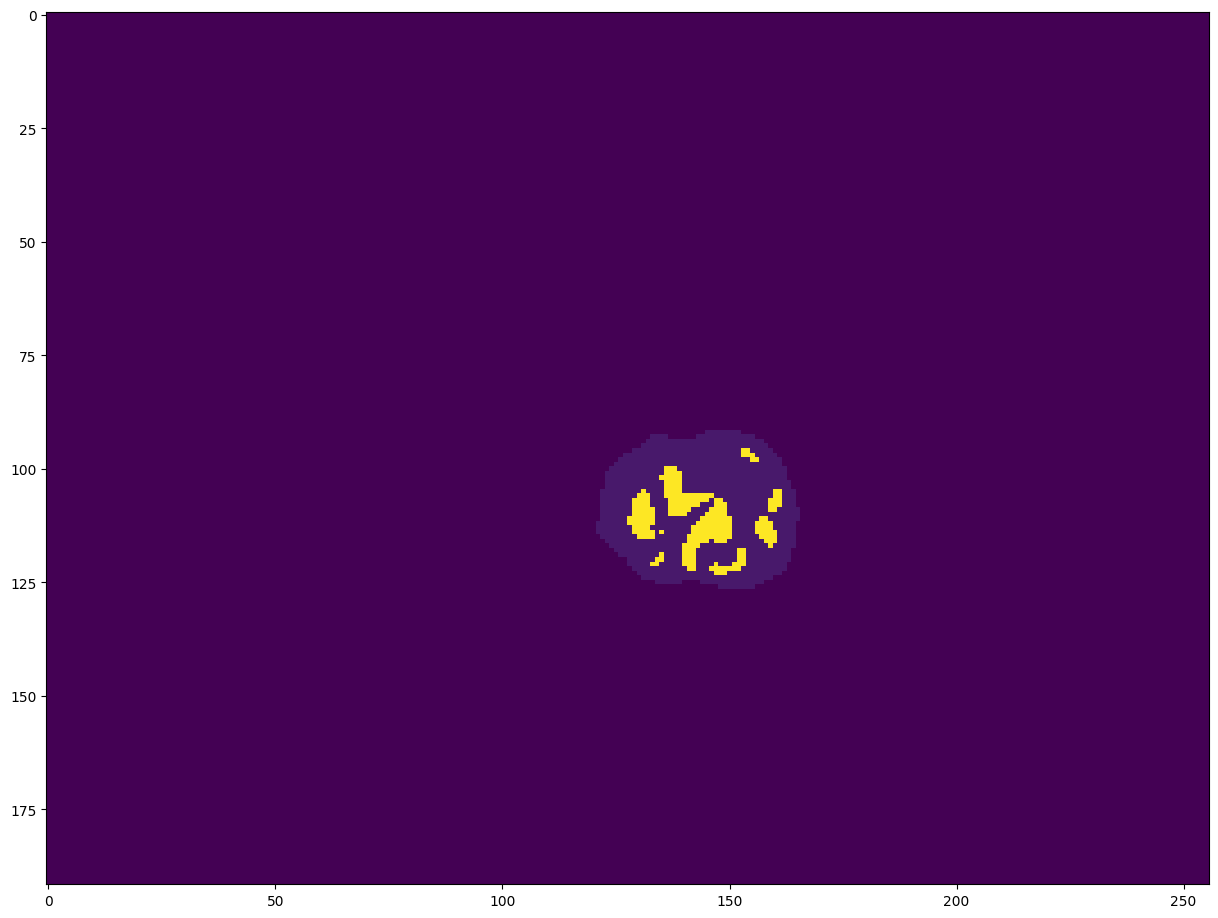

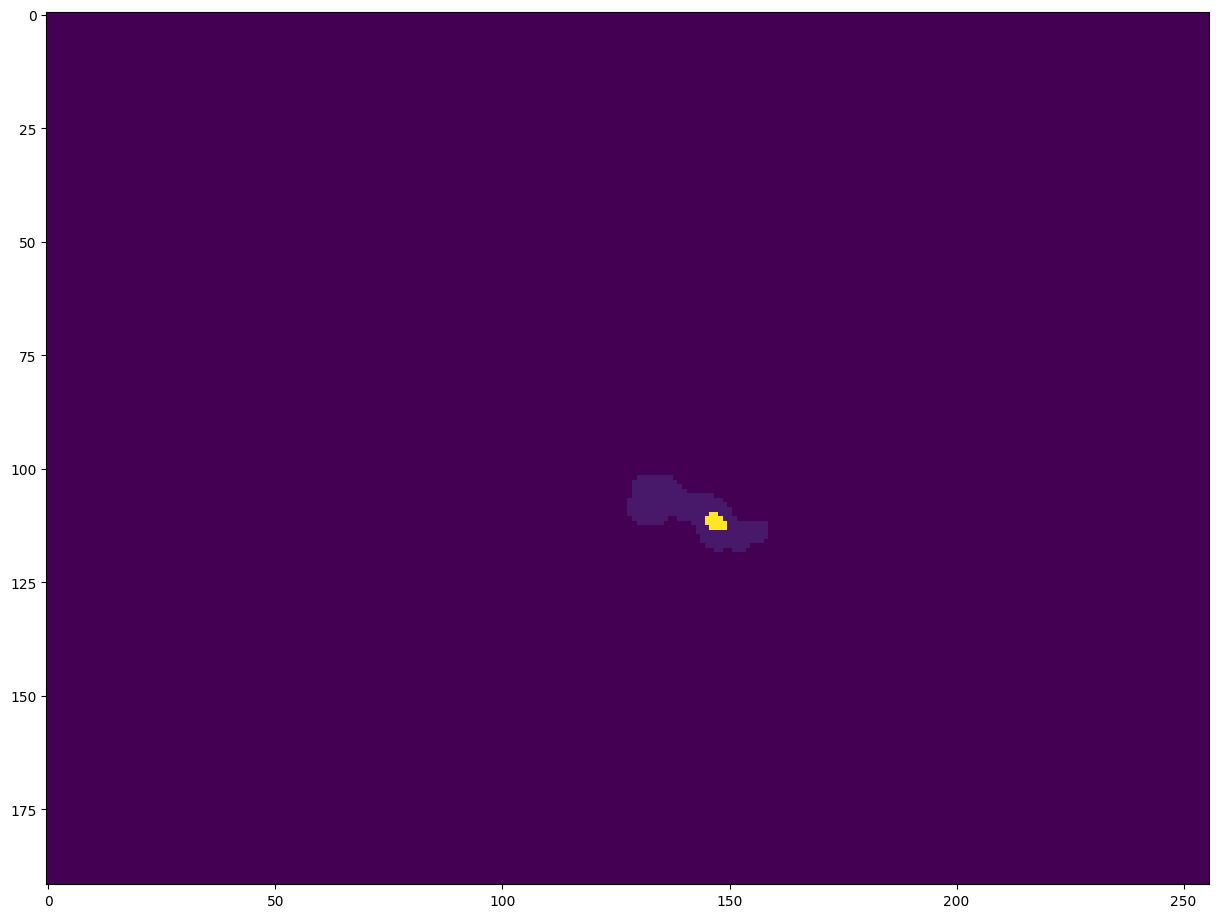

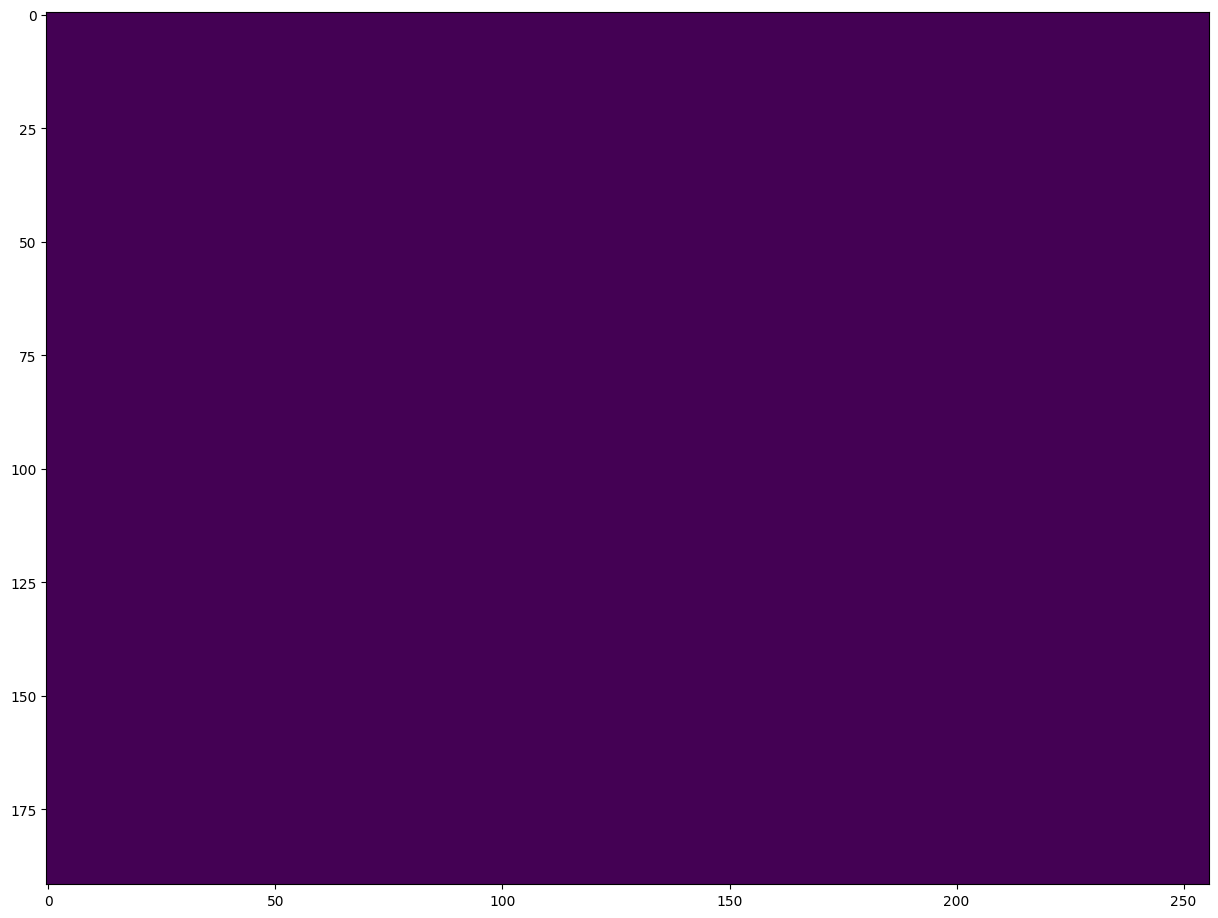

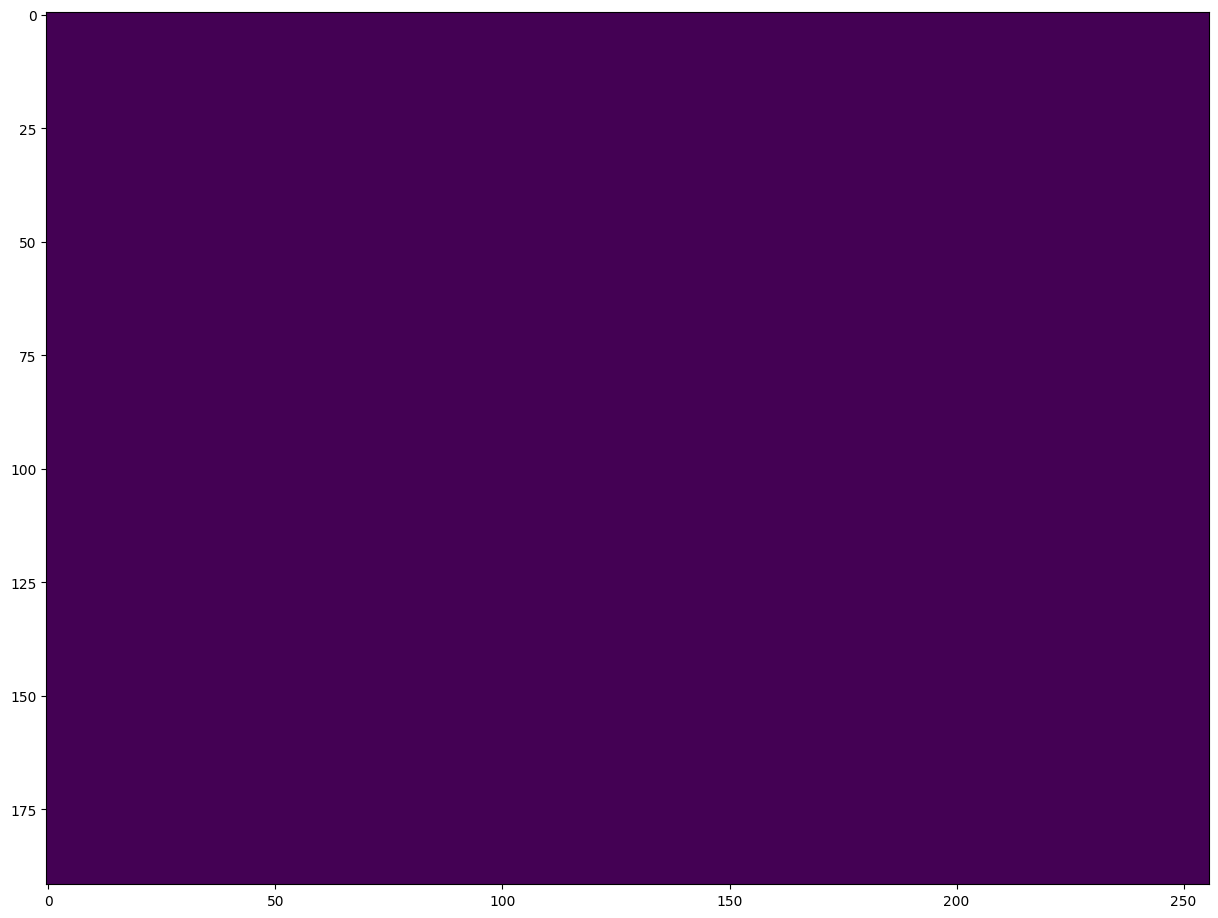

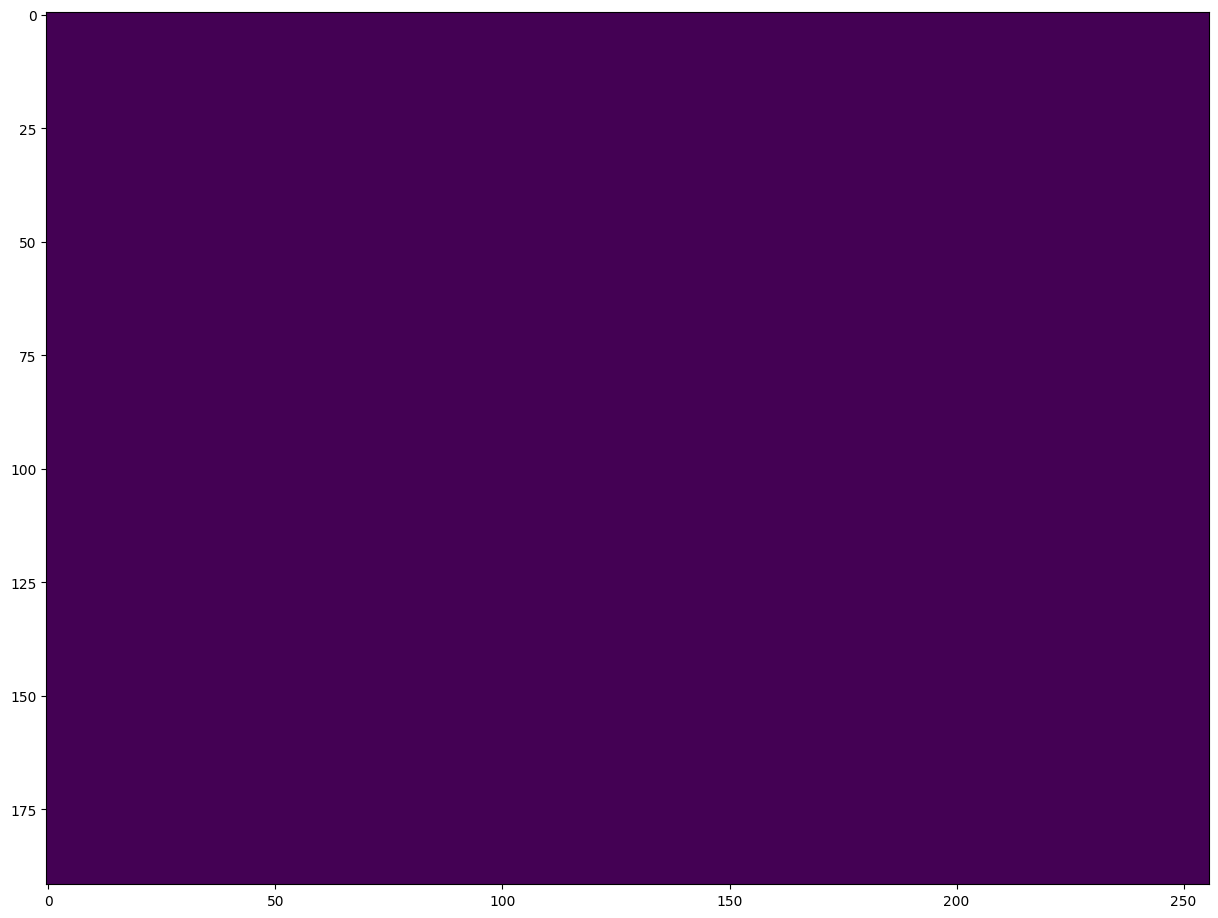

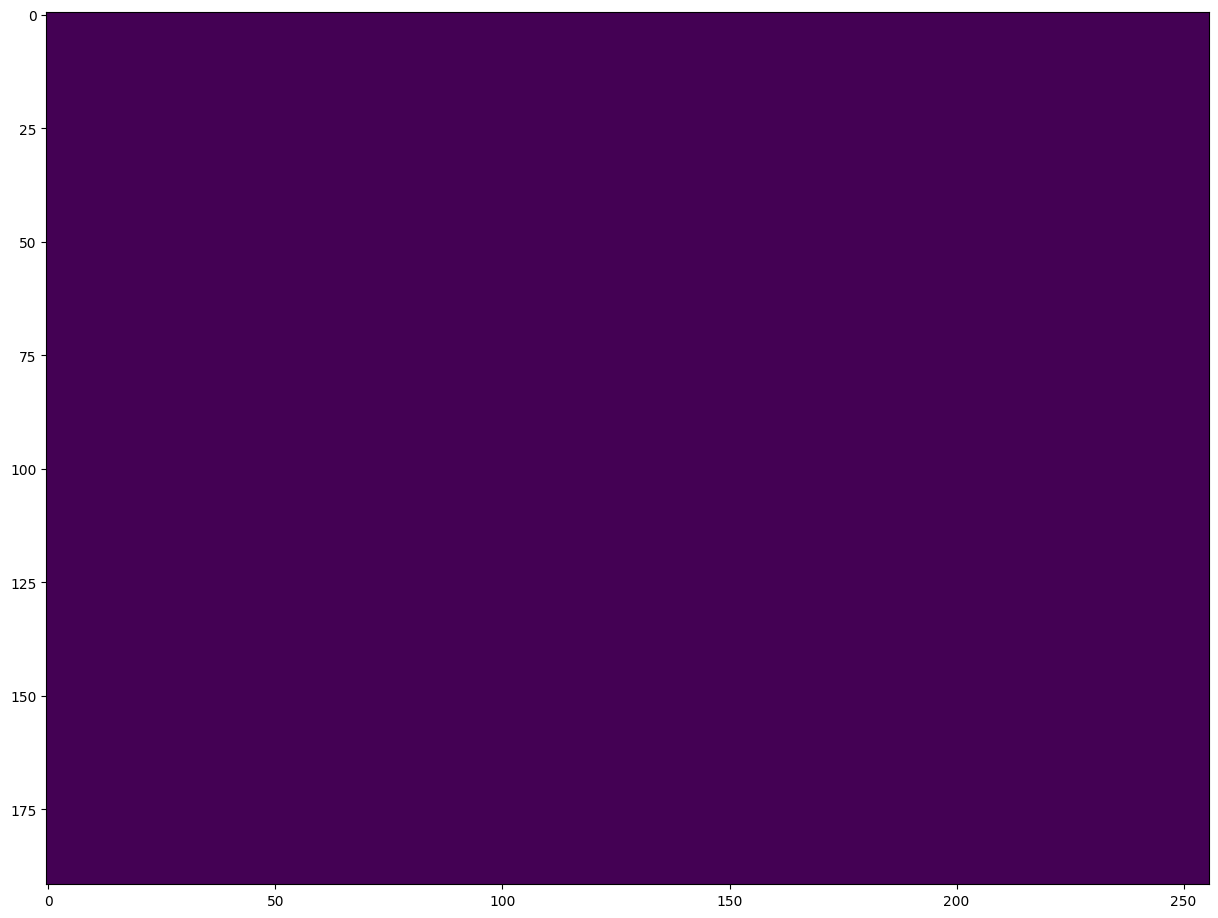

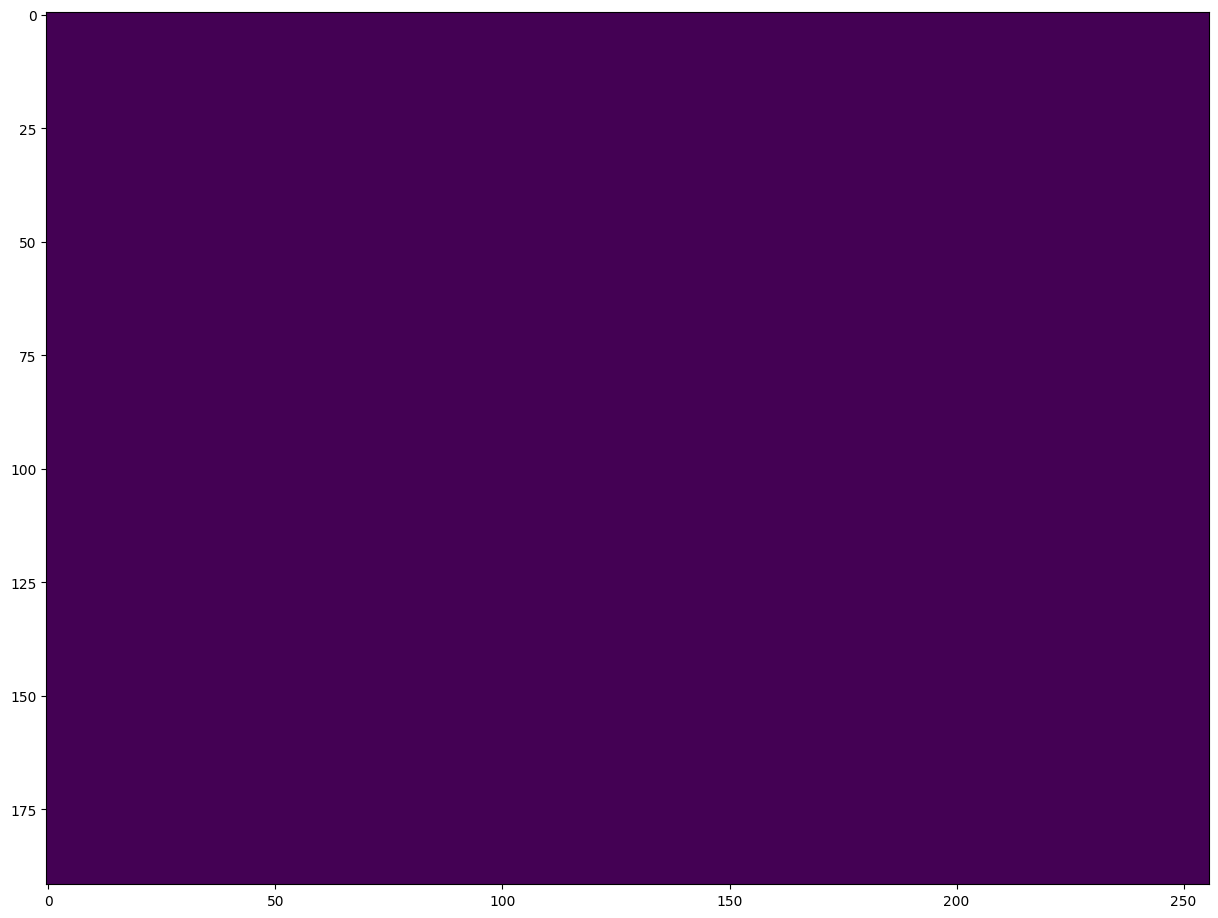

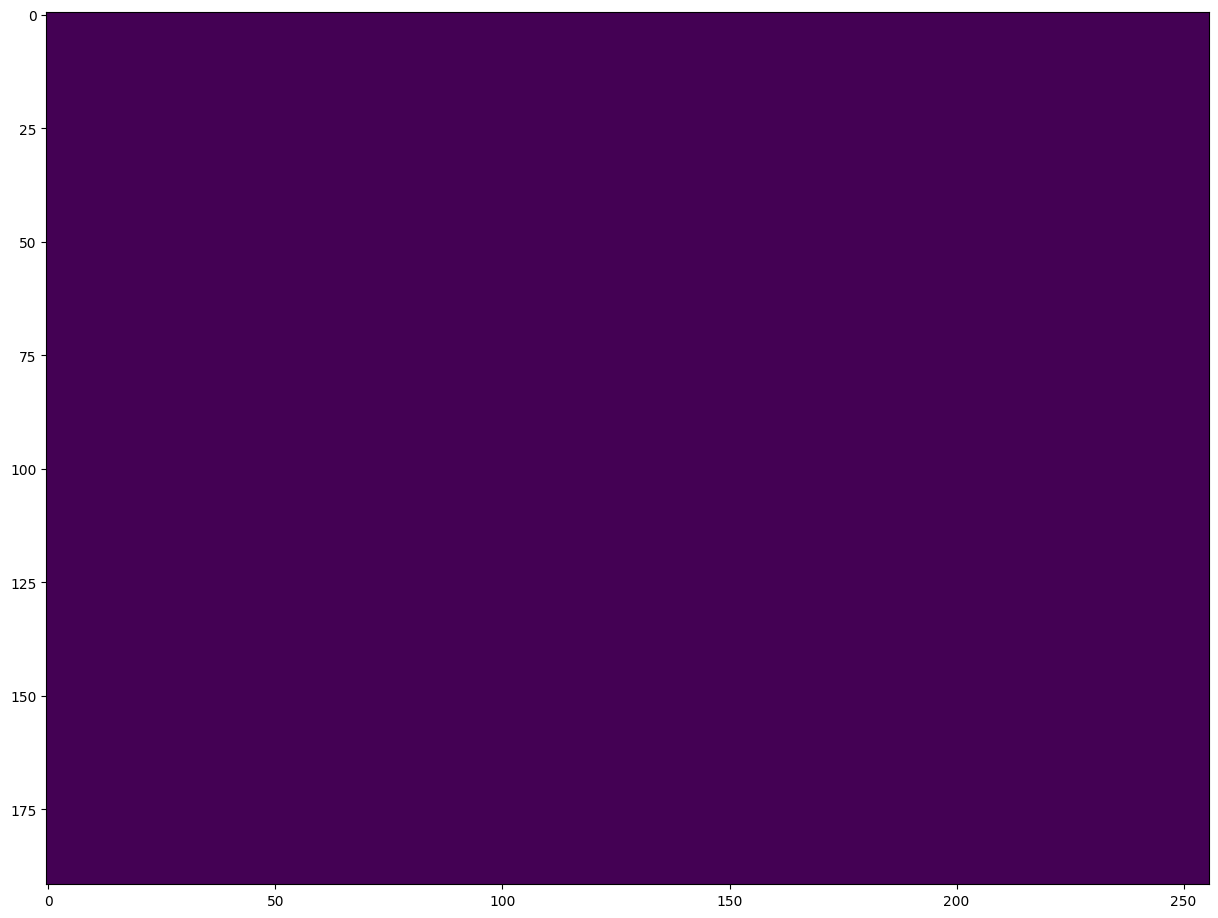

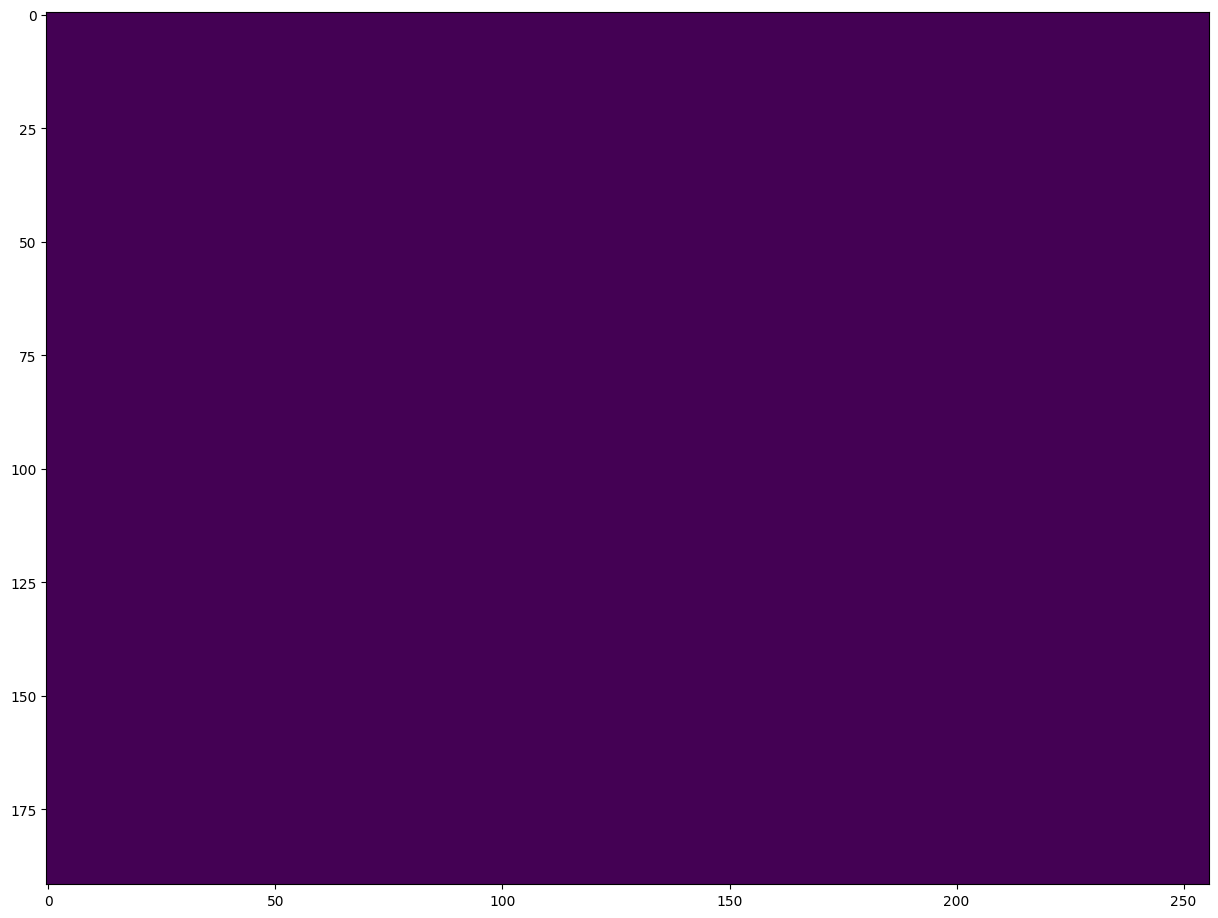

In [24]:
img = result["subject-11"]
for i in range(0,144,2):
    plt.figure(figsize=(15,20))
    plt.imshow(img[i,...])
    plt.show()